## Import Libraries

BERT for classification: 

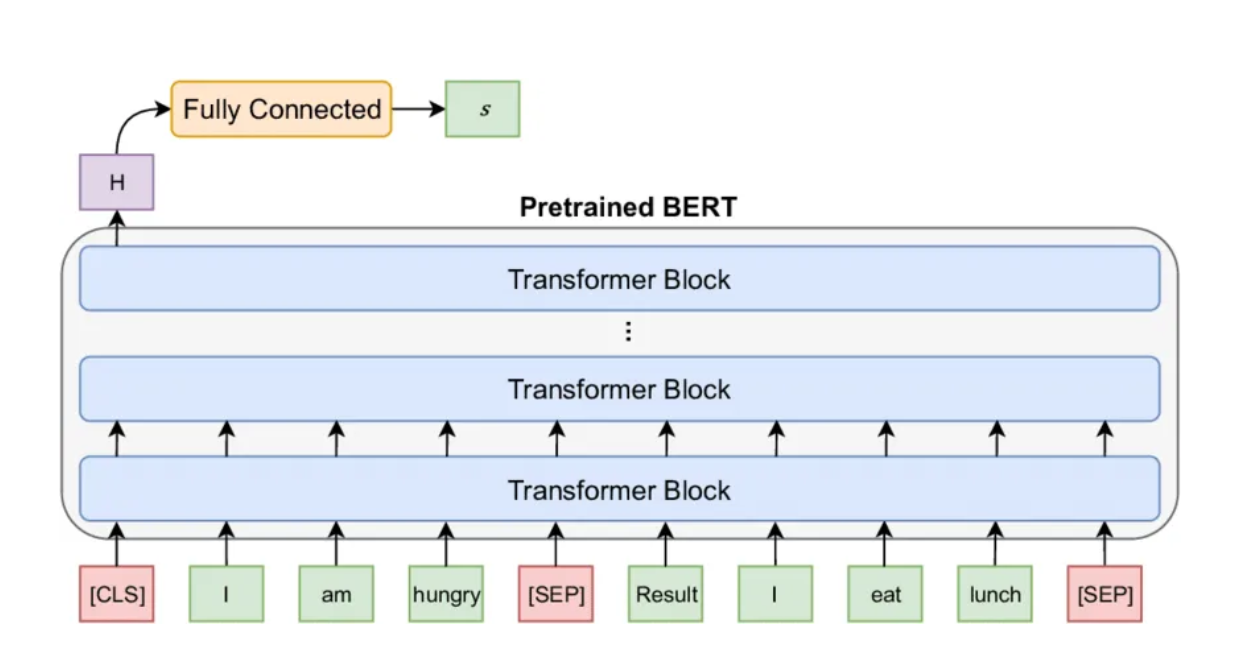
- https://medium.com/@pyroswolf200/fine-tuning-bert-on-imdb-review-dataset-309e90b6dac0

The IMDb Movie Reviews dataset is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative. In this article we will try to classify film review sentences as good or bad.

#### Without all the model, just loading from HG

In [1]:
#ShoW each Cell's Execution Time
# !pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-07-08 18:00:47 +03:00)


In [2]:
import torch
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print(f" DEVICE: {DEVICE}. GPU: {torch.cuda.get_device_name(0)} is available.")    
else:
    DEVICE = 'cpu'
    print(f" DEVICE: {DEVICE}. No GPU available. Training will run on CPU."  )    

 DEVICE: cuda:0. GPU: NVIDIA GeForce RTX 4050 Laptop GPU is available.
time: 1.58 s (started: 2024-07-08 18:00:48 +03:00)


In [3]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler
from transformers import  BertTokenizer, BertModel #,BertForSequenceClassification, AutoTokenizer 
from datasets import load_dataset
from torch.utils.data import Subset

import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import re


c:\Users\user\anaconda3\envs\torch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


time: 1.92 s (started: 2024-07-08 18:00:49 +03:00)


In [4]:
import sys
sys.path.append('./src') #link to GTL libraries
import src.guided_transfer_learning as gtl

time: 0 ns (started: 2024-07-08 18:00:51 +03:00)


#### Functions:

In [5]:
# Iterate over all parameters in the model
def check_trainable_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name} is || TRAINABLE || ")
        else:
            print(f"{name} is || NOT TRAINABLE || ")

def count_trainable_layers(model):
    trainable_layers = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_layers += 1
    return trainable_layers

def unfreeze_BERT_layers(bert, nb_layer_to_unfreeze):
    
    if (0 < nb_layer_to_unfreeze <= len(bert.encoder.layer)):
        # Unfreeze the last 'nb_layer_to_unfreeze' layers
        for layer in bert.encoder.layer[-nb_layer_to_unfreeze:]:
            for param in layer.parameters():
                param.requires_grad = True
        # Freeze the remaining layers
        for layer in bert.encoder.layer[:len(bert.encoder.layer) - nb_layer_to_unfreeze]:
            for param in layer.parameters():
                param.requires_grad = False
    else:
        print(" Number of unfreeze layers is larger than number of layers or less than 1.")
     

# Define the plotting function
def plot_loss(numbers): 
    plt.figure(figsize=(8, 5)) 
    plt.plot(range(1, len(numbers) + 1), numbers, marker='o', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss (Epochs)')
    plt.grid(True)
    plt.show()

def plot_acc_loss(results):
    # Create a figure and axis objects for the loss and accuracy plots
    fig, axs = plt.subplots(1,2, figsize=(16, 4))

    # Plot the loss values
    axs[0].plot(results[0], label='Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')

    # Plot the accuracy values
    axs[1].plot(results[1], label='Accuracy', color='orange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training Accuracy')

    # Show the plots
    plt.show()

def plot_results(results):
    # Unpack the results
    train_loss, train_acc = results['train_resutls']
    val_loss, val_acc = results['validatoin_results']

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot the training and validation accuracy
    axs[0].plot(train_acc, label='Training Accuracy')
    axs[0].plot(val_acc, label='Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].legend()

    # Plot the training and validation loss
    axs[1].plot(train_loss, label='Training Loss')
    axs[1].plot(val_loss, label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].legend()

    # Show the plot
    plt.show()

time: 0 ns (started: 2024-07-08 18:00:51 +03:00)


In [6]:
# Define custom model architecture
class ClassificationBERT(nn.Module):
    """
    will create a classification model built on BERT with all BERT layers freezed 
    """
    def __init__(self, bert, num_labels):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(bert.config.hidden_size, num_labels) 
        
        #freeze embedding first layers
        self.bert.embeddings.word_embeddings.weight.requires_grad = False
        self.bert.embeddings.position_embeddings.weight.requires_grad = False
        self.bert.embeddings.token_type_embeddings.weight.requires_grad = False
        self.bert.embeddings.LayerNorm.weight.requires_grad = False
        self.bert.embeddings.LayerNorm.bias.requires_grad = False

        for layer in self.bert.encoder.layer[:]:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        logits = self.classifier(output)
        return logits

time: 0 ns (started: 2024-07-08 18:00:51 +03:00)


In [7]:
# Initialize model, loss_function, and optimizer
num_labels = 2
bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ClassificationBERT_model = ClassificationBERT(bert, num_labels) 
ClassificationBERT_model.to(DEVICE)

c:\Users\user\anaconda3\envs\torch-env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ClassificationBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

time: 2.28 s (started: 2024-07-08 18:00:51 +03:00)


#### IMDB

In [8]:
# Load the IMDB dataset
imdb_dataset = load_dataset('imdb')

time: 16.4 s (started: 2024-07-08 18:00:53 +03:00)


In [9]:
#remove the unwanted characters
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

# Define a preprocessing function to tokenize the text and encode it as input ids and attention masks 
def imdb_preprocess_function(examples):
    # inputs = tokenizer(examples['text'], truncation=True, padding='max_length', return_tensors='pt')
    examples['text'] = [process(text) for text in examples['text']] 
    inputs = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=64, add_special_tokens=True, return_attention_mask=True, return_tensors='pt')
    return {'input_ids': inputs['input_ids'].squeeze(), 'attention_mask': inputs['attention_mask'].squeeze(), 'labels': torch.tensor(examples['label'])}

time: 0 ns (started: 2024-07-08 18:01:10 +03:00)


In [10]:
#Example:
input = {'text':'Hello there, BERT is the best!', 'label':0}
tokenized_text = imdb_preprocess_function(input)
print(tokenized_text)

{'input_ids': tensor([[ 101, 1044,  102,  ...,    0,    0,    0],
        [ 101, 1041,  102,  ...,    0,    0,    0],
        [ 101, 1048,  102,  ...,    0,    0,    0],
        ...,
        [ 101, 1055,  102,  ...,    0,    0,    0],
        [ 101, 1056,  102,  ...,    0,    0,    0],
        [ 101,  102,    0,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0]]), 'labels': tensor(0)}
time: 0 ns (started: 2024-07-08 18:01:10 +03:00)


In [11]:
# Convert datasets to torch Dataset
class CustomDatasetClass(Dataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
        self.labels = dataset['labels']

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels':torch.tensor(self.labels[idx], dtype=torch.long)
            }
    def __len__(self):
        return len(self.input_ids)

time: 0 ns (started: 2024-07-08 18:01:10 +03:00)


In [14]:
# Preprocess the train and test datasets
imdb_train_dataset = imdb_dataset['train'].map(imdb_preprocess_function, batched=True)
imdb_val_dataset = imdb_dataset['test'].map(imdb_preprocess_function, batched=True)

time: 344 ms (started: 2024-07-08 13:27:29 +03:00)


In [15]:
imdb_train_dataset = CustomDatasetClass(imdb_train_dataset)
imdb_val_dataset = CustomDatasetClass(imdb_val_dataset)

time: 1.81 s (started: 2024-07-08 13:27:29 +03:00)


In [16]:
imdb_train_dataset.__getitem__(0)

{'input_ids': tensor([  101,  1045, 12524,  1045,  2572,  8025,  3756,  2013,  2026,  2678,
          3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,  2043,
          2009,  2001,  2034,  2207,  1999,  3476,  1045,  2036,  2657,  2008,
          2012,  2034,  2009,  2001,  8243,  2011,  2149,  8205,  2065,  2009,
          2412,  2699,  2000,  4607,  2023,  2406,  3568,  2108,  1037,  5470,
          1997,  3152,  2641,  6801,  1045,  2428,  2018,  2000,  2156,  2023,
          2005,  2870,  1996,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor(0)}

time: 15 ms (started: 2024-07-08 13:27:31 +03:00)


In [17]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

time: 16 ms (started: 2024-07-08 13:27:31 +03:00)


In [32]:
# Define the batch size and other data loader parameters
batch_size = 32
train_num_samples = 20000
val_num_samples = 2000

train_random_sampler = RandomSampler(imdb_train_dataset,num_samples=train_num_samples)
val_random_sampler = RandomSampler(imdb_val_dataset, num_samples=val_num_samples)

# Create data loaders for training and testing datasets
imdb_train_loader = DataLoader(imdb_train_dataset, batch_size=batch_size,sampler=train_random_sampler)  #, shuffle=True)
imdb_val_loader = DataLoader(imdb_val_dataset, batch_size=batch_size,sampler=val_random_sampler)#, shuffle=True)

time: 0 ns (started: 2024-07-08 13:30:20 +03:00)


In [33]:
for batch in imdb_train_loader:
    print(batch['labels'])
    break

tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1])
time: 15 ms (started: 2024-07-08 13:30:21 +03:00)


In [25]:
# Define the training function
def train_model(model, optimizer, loss_function, epochs, train_loader, validation_loder, train_loader_sampler=None, validation_loader_sampler=None, verbose=True, with_GTL=False, guidance_matrix=None,patience=3):
    """ If the training or validation loaders have samplers, must pass the samplers to the function"""
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    skip = 5000 if epochs > 10000 else 500 if epochs > 1000 else 20 if epochs > 100 else 3 if epochs > 10 else 1
    model.train() # Set the model to training mode
    train_loss_vals = []; train_acc_vals = []; val_loss_vals = []; val_acc_vals = [];

    #For each epoch
    for epoch in range(epochs):
        epoch_loss = 0.0;epoch_loss_sum = 0.0; epoch_acc = 0; epoch_acc_sum = 0.0; 
        print(f"Epoch: {epoch+1} \nTraining: ", end= '') 

        #Batch training       
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            loss = loss_function(outputs, labels)

            model.zero_grad()
            loss.backward()

            if with_GTL and guidance_matrix is None:
                print('Guidance matrix is not provided')
                return None
            if with_GTL and guidance_matrix is not None:
                gtl.apply_guidance(model, guidance_matrix) 
            optimizer.step()
            predictions = torch.argmax(outputs, dim=1)
            epoch_loss_sum += loss.item()
            epoch_acc_sum += (predictions == labels).sum().item()

        #Calculate accuracy and loss  
        epoch_loss = epoch_loss_sum / len(train_loader) 
        epoch_acc = epoch_acc_sum / len(train_loader_sampler)  if train_loader_sampler else epoch_acc_sum/len(train_loader.dataset) 
        train_loss_vals.append(epoch_loss)
        train_acc_vals.append(epoch_acc) 
        
        val_loss, val_acc = evaluate_model(model,validation_loder, loss_function, validation_loader_sampler)
        val_loss_vals.append(val_loss)
        val_acc_vals.append(val_acc)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print(f'Early stopping after {epochs_without_improvement+1} epochs without improvement.')
                print(f'- Training loss: {epoch_loss:.2f} - Training acc: {epoch_acc:.2f} - Validation loss: {val_loss:.2f} - Validation acc: {val_acc:.2f}\n')
                break
        time.sleep(12)
        if verbose and ((epoch+1)%skip == 0 or epoch == 0 or epoch == epochs-1):
            print(f'- Training loss: {epoch_loss:.2f} - Training acc: {epoch_acc:.2f} - Validation loss: {val_loss:.2f} - Validation acc: {val_acc:.2f}\n')
    return {'train_resutls':[train_loss_vals, train_acc_vals], 'validatoin_results': [val_loss_vals,val_acc_vals]}

# Define the evaluation function
def evaluate_model(model, validation_loder, loss_function, validation_loader_sampler=None, versbose=False):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0;total_acc = 0 ;
    print("Evaluating: ", end= '')
    with torch.no_grad():
        for batch in tqdm(validation_loder):
            input_ids = batch['input_ids'].to(device=DEVICE)
            attention_mask = batch['attention_mask'].to(device=DEVICE)
            labels = batch['labels'].to(device=DEVICE)
            outputs = model(input_ids, attention_mask)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            total_acc += (predictions == labels).sum().item()
    avg_loss = total_loss / len(validation_loder)
    accuracy = total_acc / len(validation_loader_sampler) if validation_loader_sampler else total_acc/len(validation_loder.dataset)
    if versbose:
        print(f'Test loss: {avg_loss:.2f} Test acc: {accuracy:.2f}') 
    return avg_loss, accuracy

time: 0 ns (started: 2024-07-08 18:06:07 +03:00)


In [73]:
epochs = 12
optimizer = AdamW(ClassificationBERT_model.parameters(),lr=3e-6)
loss_function = nn.CrossEntropyLoss() 
res = train_model(ClassificationBERT_model, 
                  optimizer, 
                  loss_function, 
                  train_loader=imdb_train_loader, 
                  validation_loder=imdb_val_loader, 
                  train_loader_sampler=train_random_sampler, 
                  validation_loader_sampler=val_random_sampler, 
                  epochs=epochs, 
                  with_GTL=False, 
                  verbose=True, 
                  patience=3)


Epoch: 1 
Training: 

100%|██████████| 625/625 [00:44<00:00, 13.90it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 14.21it/s]


- Training loss: 0.61 - Training acc: 0.69 - Validation loss: 0.58 - Validation acc: 0.73

Epoch: 2 
Training: 

100%|██████████| 625/625 [00:44<00:00, 14.10it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 14.03it/s]


Epoch: 3 
Training: 

100%|██████████| 625/625 [00:44<00:00, 13.94it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 14.13it/s]


- Training loss: 0.56 - Training acc: 0.74 - Validation loss: 0.56 - Validation acc: 0.73

Epoch: 4 
Training: 

100%|██████████| 625/625 [00:44<00:00, 13.91it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 13.97it/s]


Epoch: 5 
Training: 

100%|██████████| 625/625 [00:44<00:00, 13.93it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 14.02it/s]


Epoch: 6 
Training: 

100%|██████████| 625/625 [00:45<00:00, 13.66it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 14.01it/s]


- Training loss: 0.53 - Training acc: 0.75 - Validation loss: 0.53 - Validation acc: 0.73

Epoch: 7 
Training: 

100%|██████████| 625/625 [00:46<00:00, 13.44it/s]


Evaluating: 

100%|██████████| 125/125 [00:09<00:00, 13.40it/s]


Epoch: 8 
Training: 

100%|██████████| 625/625 [00:45<00:00, 13.70it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 13.99it/s]


Epoch: 9 
Training: 

100%|██████████| 625/625 [00:45<00:00, 13.77it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 13.95it/s]


- Training loss: 0.52 - Training acc: 0.75 - Validation loss: 0.52 - Validation acc: 0.75

Epoch: 10 
Training: 

100%|██████████| 625/625 [00:44<00:00, 13.91it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 13.90it/s]


Epoch: 11 
Training: 

100%|██████████| 625/625 [00:44<00:00, 13.94it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 13.92it/s]


Epoch: 12 
Training: 

100%|██████████| 625/625 [00:44<00:00, 13.90it/s]


Evaluating: 

100%|██████████| 125/125 [00:08<00:00, 13.93it/s]


- Training loss: 0.51 - Training acc: 0.75 - Validation loss: 0.51 - Validation acc: 0.75

time: 13min 13s (started: 2024-07-07 14:13:07 +03:00)


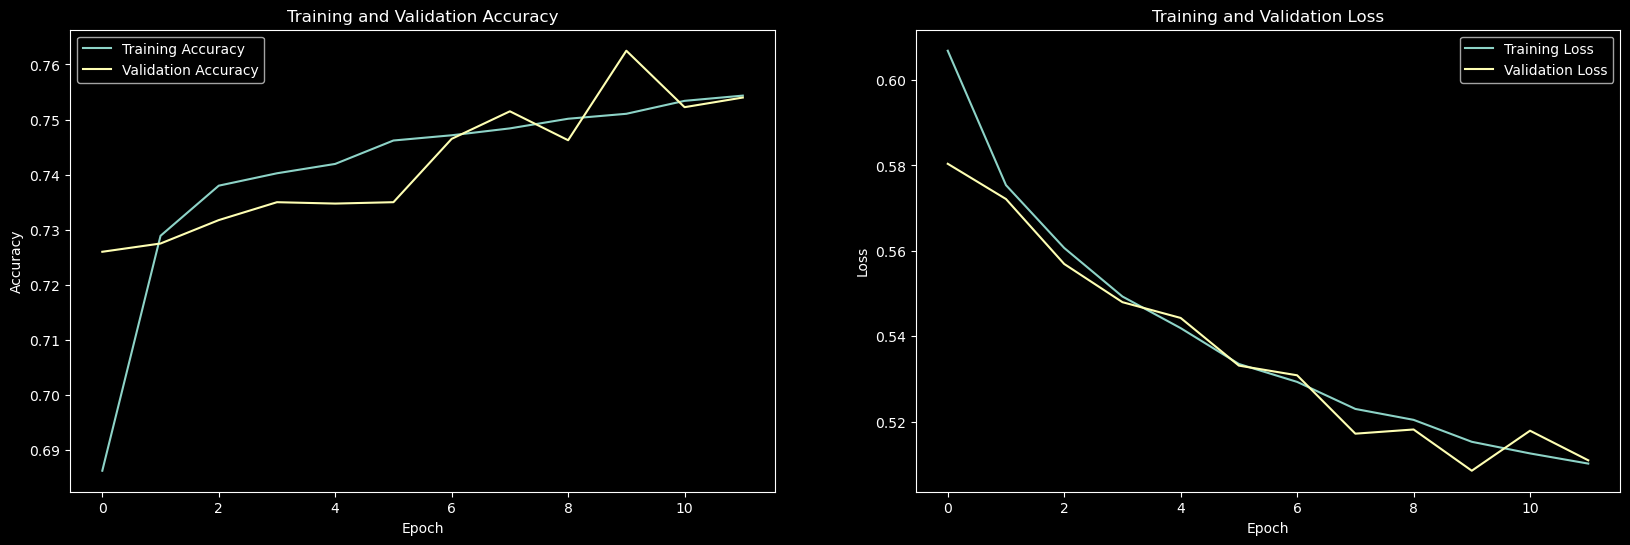

time: 172 ms (started: 2024-07-07 14:26:20 +03:00)


In [74]:
plot_results(res)

In [83]:
eval_resutls = evaluate_model(ClassificationBERT_model,
                              imdb_val_loader, 
                              loss_function=loss_function, 
                              validation_loader_sampler=val_random_sampler, 
                              versbose=True)

Evaluating: 

100%|██████████| 63/63 [00:04<00:00, 13.23it/s]

Test loss: 0.51 Test acc: 0.75
time: 4.77 s (started: 2024-07-07 14:32:18 +03:00)


- Testing a text output from BERT-2 outputs

In [76]:
test_text = ['I love BERT.'] 
inputs = tokenizer.encode_plus(test_text, add_special_tokens=True, max_length=512,padding='max_length',return_tensors='pt').to(DEVICE)

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
logits = ClassificationBERT_model(input_ids, attention_mask=attention_mask)
probs =  torch.nn.functional.softmax(logits, dim=1)
probs

tensor([[0.5921, 0.4079]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

time: 31 ms (started: 2024-07-07 14:26:30 +03:00)


In [78]:
for batch in imdb_train_loader:
    print(batch['input_ids'])
    print(batch['labels'])
    break

tensor([[  101,  2543,  1998,  ...,  2011,  1996,   102],
        [  101,  2024,  2017,  ...,  2030,  4009,   102],
        [  101,  2043,  1045,  ...,  2003, 29490,   102],
        ...,
        [  101,  1045,  2310,  ...,  7916,  4369,   102],
        [  101,  2023,  3185,  ...,  3475,  1056,   102],
        [  101,  1037,  6919,  ...,  2196,  2387,   102]])
tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 1])
time: 15 ms (started: 2024-07-07 14:27:31 +03:00)


#### Goemotions Dataset:

- Get Dataset for training the Guidance matrix

In [12]:
goemotions_dataset = load_dataset('go_emotions') 

time: 14.3 s (started: 2024-07-08 18:04:02 +03:00)


In [13]:
goemotions_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

time: 0 ns (started: 2024-07-08 18:04:16 +03:00)


In [14]:
goemotions_label_to_id = {
    'admiration': 0,
    'amusement': 1,
    'anger': 2,
    'annoyance': 3,
    'approval': 4,
    'caring': 5,
    'confusion': 6,
    'curiosity': 7,
    'desire': 8,
    'disappointment': 9,
    'disapproval': 10,
    'disgust': 11,
    'embarrassment': 12,
    'excitement': 13,
    'fear': 14,
    'gratitude': 15,
    'grief': 16,
    'joy': 17,
    'love': 18,
    'nervousness': 19,
    'optimism': 20,
    'pride': 21,
    'realization': 22,
    'relief': 23,
    'remorse': 24,
    'sadness': 25,
    'surprise': 26,
    'neutral': 27
}

time: 0 ns (started: 2024-07-08 18:04:16 +03:00)


In [15]:
for i in range(1000,1050):
    print(goemotions_dataset['train'].__getitem__(i))

{'text': 'I changed from [NAME] to [NAME] last night because I panicked. I am very pleased with my decision.', 'labels': [4], 'id': 'eetas5k'}
{'text': 'Omg i hope this is about [NAME]. I would LOVE to see [NAME] and [NAME] go head to head', 'labels': [20], 'id': 'ee2k7jn'}
{'text': 'Finale', 'labels': [27], 'id': 'ef637gp'}
{'text': 'Which suggests nothing in itself. The same mods you claim are abusive are probably as hyperbolic about the racism issue as you are.', 'labels': [2, 3], 'id': 'ed6urto'}
{'text': 'I double dog dare him.', 'labels': [27], 'id': 'ed4hvmx'}
{'text': 'Believe you me. TLJ is much, much worse.', 'labels': [9, 11], 'id': 'ee74ui2'}
{'text': "I don't really want to do anything.", 'labels': [10], 'id': 'ednshbf'}
{'text': 'I’d buy a cheap version of it.', 'labels': [4], 'id': 'eesuzje'}
{'text': 'Not to mention that the full video is part of the kids PR campaign according to [NAME] idiot', 'labels': [9], 'id': 'eexo5ja'}
{'text': 'How did U quit being obsessed? It’

In [16]:
# Load pre-trained BERT model and adding a dense layer  
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

time: 219 ms (started: 2024-07-08 18:04:16 +03:00)


c:\Users\user\anaconda3\envs\torch-env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
labels = goemotions_dataset['train']['labels'][:20]
print([example[0] for example in labels]  )
print([example for example in labels])

[27, 27, 2, 14, 3, 26, 15, 8, 0, 27, 6, 1, 27, 5, 3, 3, 15, 2, 27, 6]
[[27], [27], [2], [14], [3], [26], [15], [8, 20], [0], [27], [6], [1, 4], [27], [5], [3], [3, 12], [15], [2], [27], [6, 22]]
time: 63 ms (started: 2024-07-08 18:04:20 +03:00)


In [18]:
# Define a preprocessing function to tokenize the text and encode it as input ids and attention masks  
def goemotions_preprocess_function(examples):
    # inputs = tokenizer(examples['text'], truncation=True, padding='max_length', return_tensors='pt')
    inputs = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=64, add_special_tokens=True, return_attention_mask=True, return_tensors='pt')
    new_labels =  [example[0] for example in examples['labels']]  
    return {'input_ids': inputs['input_ids'].squeeze(), 'attention_mask': inputs['attention_mask'].squeeze(), 'labels': torch.tensor(new_labels)}

time: 0 ns (started: 2024-07-08 18:04:24 +03:00)


In [19]:
# Preprocess the train and test datasets
goemotions_train_dataset = goemotions_dataset['train'].map(goemotions_preprocess_function, batched=True) 
goemotions_val_dataset = goemotions_dataset['validation'].map(goemotions_preprocess_function, batched=True) 
goemotions_test_dataset = goemotions_dataset['test'].map(goemotions_preprocess_function, batched=True) 

time: 453 ms (started: 2024-07-08 18:04:25 +03:00)


In [20]:
goemotions_train_dataset = CustomDatasetClass(goemotions_train_dataset)
goemotions_validation_dataset = CustomDatasetClass(goemotions_val_dataset)
goemotions_test_dataset = CustomDatasetClass(goemotions_test_dataset)

time: 2.02 s (started: 2024-07-08 18:04:29 +03:00)


In [21]:
goemotions_validation_dataset.__getitem__(0)

{'input_ids': tensor([ 101, 2003, 2023, 1999, 2047, 5979, 1029, 1029, 1045, 2428, 2514, 2066,
         2023, 2003, 2047, 5979, 1012,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(27)}

time: 31 ms (started: 2024-07-08 18:04:31 +03:00)


In [107]:
# does loader if launched two times return same result ?? 

time: 16 ms (started: 2024-07-08 14:40:52 +03:00)


#### Testing the Convergence of the model:
If the model does not converge, the calculation of the Guidance matrix will not make sense.


- Train only classifier with all layers frozen

In [111]:
# Define custom model architecture
class ClassificationBERT(nn.Module):
    """
    will create a classification model built on BERT with all BERT layers freezed 
    """
    def __init__(self, bert, num_labels):
        super().__init__()
        self.bert = bert
        self.dropout_1 = nn.Dropout(0.2)
        self.classifier_1 = nn.Linear(bert.config.hidden_size, num_labels)
        
        #freeze embedding first layers
        self.bert.embeddings.word_embeddings.weight.requires_grad = False
        self.bert.embeddings.position_embeddings.weight.requires_grad = False
        self.bert.embeddings.token_type_embeddings.weight.requires_grad = False
        self.bert.embeddings.LayerNorm.weight.requires_grad = False
        self.bert.embeddings.LayerNorm.bias.requires_grad = False

        for layer in self.bert.encoder.layer[:]:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout_1(pooled_output)
        logits = self.classifier_1(output) 
        
        return logits

time: 0 ns (started: 2024-07-08 16:32:58 +03:00)


In [112]:
# To add:
# Data Analysis of goemotions_train_dataset

time: 16 ms (started: 2024-07-08 16:33:00 +03:00)


In [113]:
num_labels = 28  # number of labels in the datasetclass_indices = list(range(28))
loss_function = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation
# loss_function = nn.BCEWithLogitsLoss()
nb_of_layers_to_unfreeze = 12  # number of layers to unfreeze in the BERT model
batch_size = 16  # batch size for data loader
lr_train_classifier = 1e-4
lr_fine_tuning = 5e-5
epochs_train_classifier = 5
epochs_fine_tuning = 50 

time: 0 ns (started: 2024-07-08 16:33:43 +03:00)


In [114]:
train_num_samples = 40000 # samples to train, taken randomly from training set
val_num_samples = 5000 # samples to test, taken randomly from test set 

train_random_sampler = RandomSampler(goemotions_train_dataset,num_samples=train_num_samples)
val_random_sampler = RandomSampler(goemotions_validation_dataset, num_samples=val_num_samples)
goemotions_train_loader = DataLoader(goemotions_train_dataset, batch_size=batch_size, sampler=train_random_sampler)
goemotions_val_loader = DataLoader(goemotions_validation_dataset, batch_size=batch_size, sampler=val_random_sampler)

time: 63 ms (started: 2024-07-08 16:33:47 +03:00)


- Train Classifier with BERT Freezed 

In [115]:
bert = BertModel.from_pretrained('bert-base-uncased') # BERT freezed 
print("- BERT downloaded.")
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels).to(DEVICE)
# Freeze all, train classifier only
print("- Starting training model with BERT frozen.\n")
goemotions_train_losses_classifier = train_model(ClassificationBERT_, 
                                                 AdamW(ClassificationBERT_.parameters(),lr=lr_train_classifier),
                                                 loss_function,
                                                 epochs=epochs_train_classifier,
                                                 train_loader=goemotions_train_loader,
                                                 validation_loder=goemotions_val_loader,
                                                 train_loader_sampler=train_random_sampler,
                                                 validation_loader_sampler=val_random_sampler,
                                                 verbose=True )

print("- Classifier training with BERT frozen is finished.\n")

c:\Users\user\anaconda3\envs\torch-env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


- BERT downloaded.
- Starting training model with BERT frozen.

Epoch: 1 
Training: 

100%|██████████| 2500/2500 [01:32<00:00, 27.02it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.76it/s]


- Training loss: 2.28 - Training acc: 0.37 - Validation loss: 2.00 - Validation acc: 0.42

Epoch: 2 
Training: 

100%|██████████| 2500/2500 [01:31<00:00, 27.41it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.80it/s]


- Training loss: 1.93 - Training acc: 0.43 - Validation loss: 1.85 - Validation acc: 0.45

Epoch: 3 
Training: 

100%|██████████| 2500/2500 [01:32<00:00, 27.13it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.22it/s]


- Training loss: 1.83 - Training acc: 0.45 - Validation loss: 1.82 - Validation acc: 0.46

Epoch: 4 
Training: 

100%|██████████| 2500/2500 [01:34<00:00, 26.51it/s]


Evaluating: 

100%|██████████| 313/313 [00:12<00:00, 25.80it/s]


- Training loss: 1.78 - Training acc: 0.46 - Validation loss: 1.78 - Validation acc: 0.46

Epoch: 5 
Training: 

100%|██████████| 2500/2500 [01:31<00:00, 27.22it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.60it/s]


- Training loss: 1.74 - Training acc: 0.47 - Validation loss: 1.75 - Validation acc: 0.47

- Classifier training with BERT frozen is finished.

time: 9min 48s (started: 2024-07-08 16:34:26 +03:00)


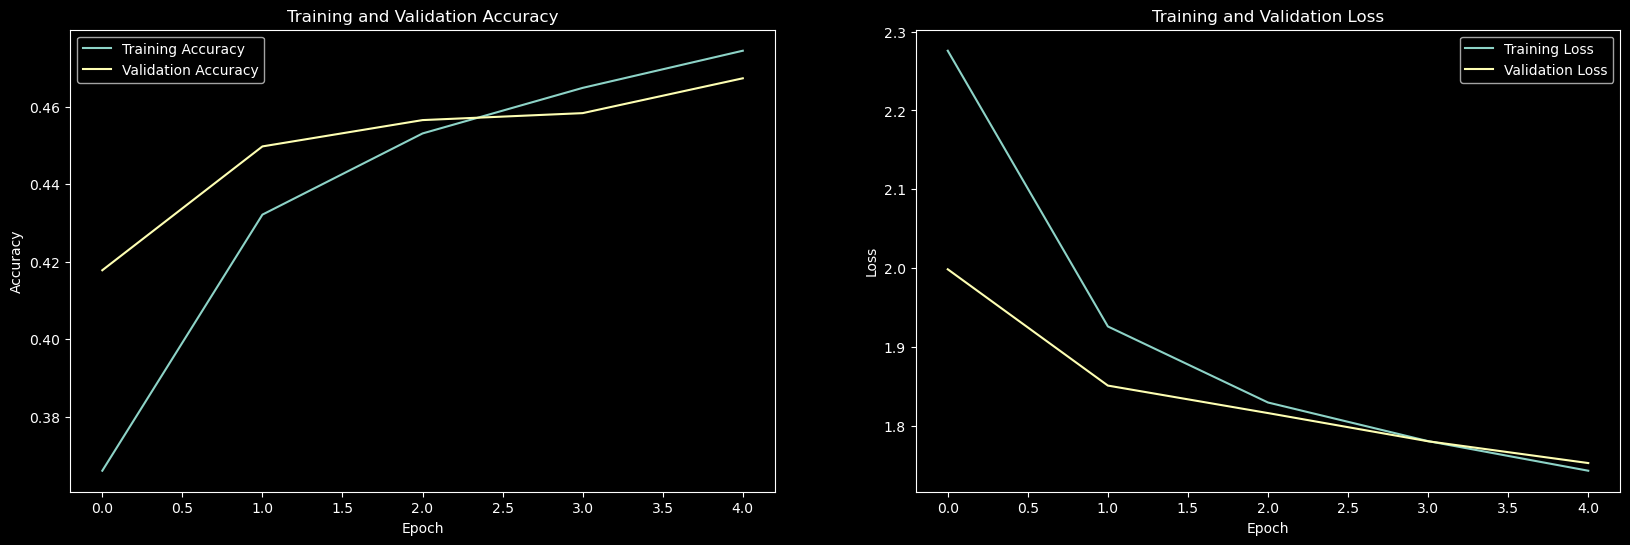

time: 281 ms (started: 2024-07-08 16:44:39 +03:00)


In [116]:
plot_results(goemotions_train_losses_classifier)

- Unfreeze some layers and Fine-tune

In [117]:
# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)
print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.\n")
goemotions_train_losses_fine_tune = train_model(ClassificationBERT_,
                                                AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                                                loss_function,
                                                epochs=epochs_fine_tuning,
                                                train_loader=goemotions_train_loader,
                                                validation_loder=goemotions_val_loader,
                                                train_loader_sampler=train_random_sampler,
                                                validation_loader_sampler=val_random_sampler,
                                                verbose=True,
                                                patience=4)
print("- BERTFine-tuning finished.\n") 

- Starting training model with 12 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 2500/2500 [05:48<00:00,  7.17it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.97it/s]


- Training loss: 1.50 - Training acc: 0.55 - Validation loss: 1.43 - Validation acc: 0.56

Epoch: 2 
Training: 

100%|██████████| 2500/2500 [05:42<00:00,  7.31it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.63it/s]


Epoch: 3 
Training: 

100%|██████████| 2500/2500 [05:41<00:00,  7.31it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.59it/s]


- Training loss: 0.73 - Training acc: 0.76 - Validation loss: 1.66 - Validation acc: 0.55

Epoch: 4 
Training: 

100%|██████████| 2500/2500 [05:45<00:00,  7.25it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.30it/s]


Epoch: 5 
Training: 

100%|██████████| 2500/2500 [05:42<00:00,  7.30it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.52it/s]


Epoch: 6 
Training: 

100%|██████████| 2500/2500 [05:43<00:00,  7.28it/s]


Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.68it/s]

Early stopping after 5 epochs without improvement.
- Training loss: 0.14 - Training acc: 0.95 - Validation loss: 2.53 - Validation acc: 0.54

- BERTFine-tuning finished.

time: 36min 31s (started: 2024-07-08 16:48:00 +03:00)


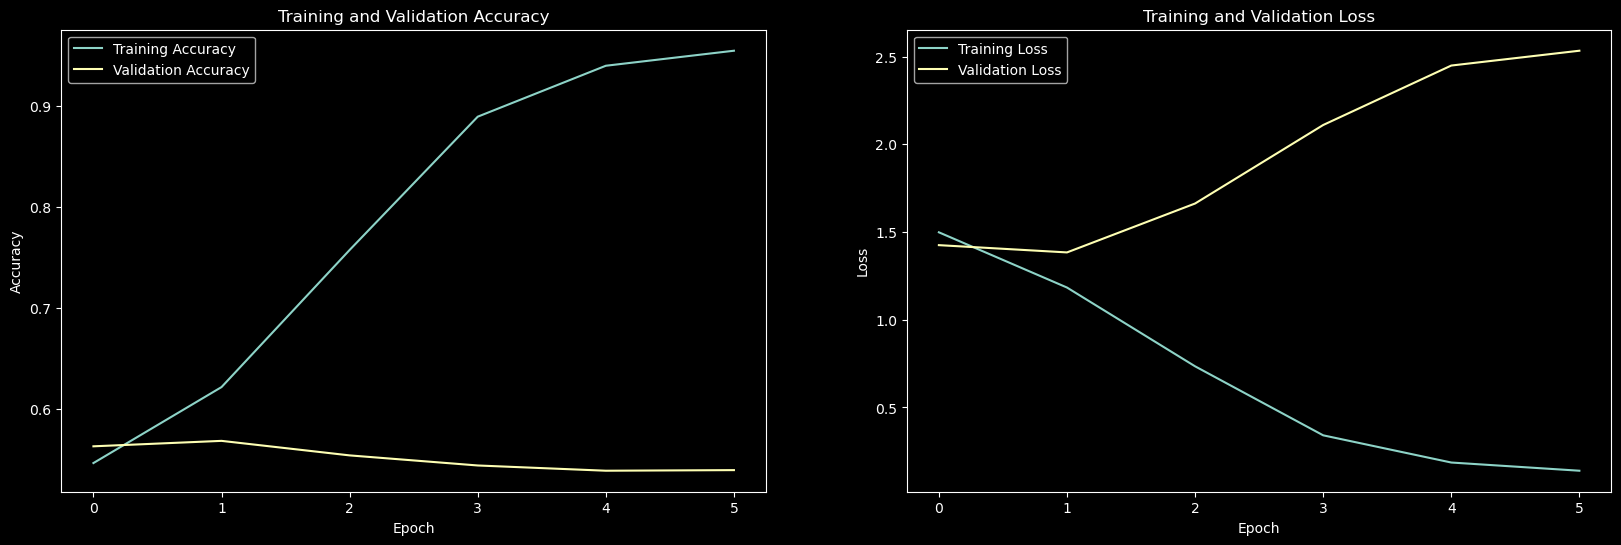

time: 156 ms (started: 2024-07-08 17:25:27 +03:00)


In [118]:
plot_results(goemotions_train_losses_fine_tune)

In [120]:
eval_resutls = evaluate_model(ClassificationBERT_,
                              goemotions_val_loader, 
                              loss_function=loss_function, 
                              validation_loader_sampler=val_random_sampler, 
                              versbose=True)

Evaluating: 

100%|██████████| 313/313 [00:11<00:00, 27.77it/s]


Test loss: 2.55 Test acc: 0.54
time: 11.3 s (started: 2024-07-08 17:27:22 +03:00)


#### The dataset of texts we have for classification using BERT is inherently limited in its ability to achieve an accuracy of more than 54%. This is due to the nature of the data and the complexity of the problem being addressed (28 classes).

In [ ]:
train_num_samples = 40000 # samples to train, taken randomly from training set
val_num_samples = 5000 # samples to test, taken randomly from test set 
test_num_samples =  2000

train_random_sampler = RandomSampler(goemotions_train_dataset,num_samples=train_num_samples)
val_random_sampler = RandomSampler(goemotions_val_dataset, num_samples=val_num_samples)
test_random_sampler = RandomSampler(goemotions_test_dataset, num_samples=test_num_samples)

goemotions_train_loader = DataLoader(goemotions_train_dataset, batch_size=batch_size, sampler=train_random_sampler)
goemotions_val_loader = DataLoader(goemotions_val_dataset, batch_size=batch_size, sampler=val_random_sampler)
goemtions_test_loader = DataLoader(goemotions_test_dataset,  batch_size=batch_size,sampler=test_random_sampler)

#### Scouts in For Loop:

In [ ]:
# take 8 labels for downstream task
# train on the the remaining 20 

# 5 scouts each with 8 labels. scout_indexes, 
# scout_indexes = [[0,1,2,3,4,5,6,7], [8,9,10,11,12,13,14,15] , [16,17,18,19,0,1,2,3], [etc.]]  

In [22]:
# Preprocess the train and test datasets
goemotions_train_dataset = goemotions_dataset['train'].map(goemotions_preprocess_function, batched=True) 
goemotions_val_dataset = goemotions_dataset['validation'].map(goemotions_preprocess_function, batched=True) 
goemotions_test_dataset = goemotions_dataset['test'].map(goemotions_preprocess_function, batched=True) 

goemotions_train_dataset = CustomDatasetClass(goemotions_train_dataset)
goemotions_validation_dataset = CustomDatasetClass(goemotions_val_dataset)
goemotions_test_dataset = CustomDatasetClass(goemotions_test_dataset)

time: 2.3 s (started: 2024-07-08 18:04:53 +03:00)


In [23]:
# class_indices = list(range(num_labels))  # list of indices for all classes in the dataset
# nb_classes_for_scout = 8  # number of classes to use for each scout
# num_samples = 32  # number of samples to use for each scout

nb_scouts = 5  # number of scouts to create
num_labels = 28  # number of labels in the datasetclass_indices = list(range(28))
loss_function = nn.CrossEntropyLoss() #combines the softmax activation fn and the neg. log-likelihood loss in a single operation
train_num_samples = 10000 
val_num_samples = 3000 
batch_size = 16  # batch size for data loader
lr_train_classifier = 1e-4
lr_fine_tuning = 5e-5
epochs_train_classifier = 2
epochs_fine_tuning = 8  
nb_of_layers_to_unfreeze = 12  # number of layers to unfreeze in the BERT model

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased') #should get a diff. BERT base for each model
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels).to(DEVICE)
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)
my_scouts = gtl.create_scouts(ClassificationBERT_, should_save_guidance=True, should_save_scouts=False, use_squared_differences=True)

time: 1.08 s (started: 2024-07-08 18:05:46 +03:00)


In [26]:
for i in range(nb_scouts):
    print(f"================================\nScout nb {i} Start!")
    #### chossing random classes and taking random inputs from these classes 
    # random_class_indices = random.sample(class_indices,nb_classes_for_scout)
    # train_random_samples = [i for i, item in enumerate(goemotions_train_dataset) if item['labels'] in random_class_indices ] 
    # goemotions_train_subset = Subset(goemotions_train_dataset, train_random_samples)
    # train_random_sampler = RandomSampler(goemotions_train_subset, num_samples=num_samples)
    # goemotions_subset_train_loader = DataLoader(goemotions_train_subset, batch_size=batch_size, sampler=train_random_sampler)
    ##############################################################################################################################
    #### Chooisng random examples for the scouts from all the classes: (taking from just certain classes will depend on certian weights and when adding the scouts this could cancel the info gotten from each scout)
    train_random_sampler = RandomSampler(goemotions_train_dataset,num_samples=train_num_samples)
    val_random_sampler = RandomSampler(goemotions_validation_dataset, num_samples=val_num_samples)
    goemotions_train_loader = DataLoader(goemotions_train_dataset, batch_size=batch_size, sampler=train_random_sampler)
    goemotions_val_loader = DataLoader(goemotions_validation_dataset, batch_size=batch_size, sampler=val_random_sampler)

    ##############################################################################################################################
    bert = BertModel.from_pretrained('bert-base-uncased') # BERT freezed 
    print("- BERT downloaded.")
    ClassificationBERT_scout = ClassificationBERT(bert, num_labels=num_labels).to(DEVICE)
    ##############################################################################################################################
    # Freeze all, train classifier only
    print("- Starting training model with BERT frozen.\n")
    goemotions_train_losses_classifier = train_model(ClassificationBERT_scout, 
                                                 AdamW(ClassificationBERT_scout.parameters(),lr=lr_train_classifier),
                                                 loss_function,
                                                 epochs=epochs_train_classifier,
                                                 train_loader=goemotions_train_loader,
                                                 validation_loder=goemotions_val_loader,
                                                 train_loader_sampler=train_random_sampler,
                                                 validation_loader_sampler=val_random_sampler,
                                                 verbose=True) 
    print("- Classifier training with BERT frozen is finished.\n") 
    ##############################################################################################################################
    # Unfreeze certain layers and train encoder layers
    unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
    print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.\n") 
    ##############################################################################################################################
    goemotions_train_losses_fine_tune = train_model(ClassificationBERT_scout,
                                                AdamW(ClassificationBERT_scout.parameters(),lr=lr_fine_tuning),
                                                loss_function,
                                                epochs=epochs_fine_tuning,
                                                train_loader=goemotions_train_loader,
                                                validation_loder=goemotions_val_loader,
                                                train_loader_sampler=train_random_sampler,
                                                validation_loader_sampler=val_random_sampler,
                                                verbose=True,
                                                patience=3) 
    print("- Fine-tuning of BERT is finished.\n") 
    print(f"================================\nScout nb {i} End!")
    my_scouts.add_scout(ClassificationBERT_scout) 

Scout nb 0 Start!
- BERT downloaded.
- Starting training model with BERT frozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [00:22<00:00, 27.38it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 28.11it/s]


- Training loss: 2.59 - Training acc: 0.31 - Validation loss: 2.34 - Validation acc: 0.35

Epoch: 2 
Training: 

100%|██████████| 625/625 [00:22<00:00, 27.82it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 28.07it/s]


- Training loss: 2.22 - Training acc: 0.38 - Validation loss: 2.14 - Validation acc: 0.40

- Classifier training with BERT frozen is finished.

- Starting training model with 12 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.17it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.72it/s]


- Training loss: 1.70 - Training acc: 0.50 - Validation loss: 1.53 - Validation acc: 0.53

Epoch: 2 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.23it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.38it/s]


- Training loss: 1.43 - Training acc: 0.56 - Validation loss: 1.49 - Validation acc: 0.54

Epoch: 3 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.23it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.47it/s]


- Training loss: 1.30 - Training acc: 0.60 - Validation loss: 1.44 - Validation acc: 0.56

Epoch: 4 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.22it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.35it/s]


- Training loss: 1.20 - Training acc: 0.63 - Validation loss: 1.43 - Validation acc: 0.57

Epoch: 5 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.21it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.32it/s]


- Training loss: 1.09 - Training acc: 0.66 - Validation loss: 1.45 - Validation acc: 0.56

Epoch: 6 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.20it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.54it/s]


- Training loss: 0.99 - Training acc: 0.70 - Validation loss: 1.45 - Validation acc: 0.56

Epoch: 7 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.20it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.44it/s]


Early stopping after 4 epochs without improvement.
- Training loss: 0.91 - Training acc: 0.73 - Validation loss: 1.49 - Validation acc: 0.57

- Fine-tuning of BERT is finished.

Scout nb 0 End!
Scout nb 1 Start!
- BERT downloaded.
- Starting training model with BERT frozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [00:23<00:00, 26.43it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 26.64it/s]


- Training loss: 2.58 - Training acc: 0.32 - Validation loss: 2.31 - Validation acc: 0.37

Epoch: 2 
Training: 

100%|██████████| 625/625 [00:23<00:00, 26.54it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.66it/s]


- Training loss: 2.23 - Training acc: 0.37 - Validation loss: 2.12 - Validation acc: 0.39

- Classifier training with BERT frozen is finished.

- Starting training model with 12 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [01:25<00:00,  7.31it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.88it/s]


- Training loss: 1.69 - Training acc: 0.50 - Validation loss: 1.58 - Validation acc: 0.54

Epoch: 2 
Training: 

100%|██████████| 625/625 [01:24<00:00,  7.38it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.94it/s]


- Training loss: 1.43 - Training acc: 0.57 - Validation loss: 1.43 - Validation acc: 0.57

Epoch: 3 
Training: 

100%|██████████| 625/625 [01:24<00:00,  7.35it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.52it/s]


- Training loss: 1.29 - Training acc: 0.60 - Validation loss: 1.43 - Validation acc: 0.57

Epoch: 4 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.20it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 26.74it/s]


- Training loss: 1.22 - Training acc: 0.62 - Validation loss: 1.42 - Validation acc: 0.57

Epoch: 5 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.10it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 26.96it/s]


- Training loss: 1.11 - Training acc: 0.66 - Validation loss: 1.44 - Validation acc: 0.56

Epoch: 6 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.11it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 26.86it/s]


- Training loss: 1.01 - Training acc: 0.70 - Validation loss: 1.43 - Validation acc: 0.57

Epoch: 7 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.12it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.62it/s]


Early stopping after 4 epochs without improvement.
- Training loss: 0.89 - Training acc: 0.73 - Validation loss: 1.51 - Validation acc: 0.56

- Fine-tuning of BERT is finished.

Scout nb 1 End!
Scout nb 2 Start!
- BERT downloaded.
- Starting training model with BERT frozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [00:24<00:00, 25.52it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 25.98it/s]


- Training loss: 2.57 - Training acc: 0.32 - Validation loss: 2.37 - Validation acc: 0.35

Epoch: 2 
Training: 

100%|██████████| 625/625 [00:24<00:00, 25.94it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 24.89it/s]


- Training loss: 2.21 - Training acc: 0.39 - Validation loss: 2.14 - Validation acc: 0.40

- Classifier training with BERT frozen is finished.

- Starting training model with 12 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [01:29<00:00,  7.00it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.28it/s]


- Training loss: 1.68 - Training acc: 0.51 - Validation loss: 1.51 - Validation acc: 0.56

Epoch: 2 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.13it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.43it/s]


- Training loss: 1.44 - Training acc: 0.57 - Validation loss: 1.41 - Validation acc: 0.58

Epoch: 3 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.19it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.35it/s]


- Training loss: 1.33 - Training acc: 0.59 - Validation loss: 1.43 - Validation acc: 0.56

Epoch: 4 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.19it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.42it/s]


- Training loss: 1.21 - Training acc: 0.63 - Validation loss: 1.43 - Validation acc: 0.56

Epoch: 5 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.18it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.27it/s]


Early stopping after 4 epochs without improvement.
- Training loss: 1.12 - Training acc: 0.66 - Validation loss: 1.47 - Validation acc: 0.55

- Fine-tuning of BERT is finished.

Scout nb 2 End!
Scout nb 3 Start!
- BERT downloaded.
- Starting training model with BERT frozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [00:23<00:00, 26.52it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.01it/s]


- Training loss: 2.60 - Training acc: 0.31 - Validation loss: 2.34 - Validation acc: 0.36

Epoch: 2 
Training: 

100%|██████████| 625/625 [00:23<00:00, 26.90it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.34it/s]


- Training loss: 2.22 - Training acc: 0.38 - Validation loss: 2.14 - Validation acc: 0.39

- Classifier training with BERT frozen is finished.

- Starting training model with 12 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.12it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 26.57it/s]


- Training loss: 1.72 - Training acc: 0.50 - Validation loss: 1.53 - Validation acc: 0.55

Epoch: 2 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.17it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.58it/s]


- Training loss: 1.46 - Training acc: 0.56 - Validation loss: 1.46 - Validation acc: 0.55

Epoch: 3 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.22it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.87it/s]


- Training loss: 1.31 - Training acc: 0.60 - Validation loss: 1.41 - Validation acc: 0.57

Epoch: 4 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.25it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 27.86it/s]


- Training loss: 1.22 - Training acc: 0.63 - Validation loss: 1.44 - Validation acc: 0.57

Epoch: 5 
Training: 

100%|██████████| 625/625 [01:30<00:00,  6.94it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 26.99it/s]


- Training loss: 1.12 - Training acc: 0.65 - Validation loss: 1.53 - Validation acc: 0.54

Epoch: 6 
Training: 

100%|██████████| 625/625 [01:26<00:00,  7.23it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 26.02it/s]


Early stopping after 4 epochs without improvement.
- Training loss: 0.99 - Training acc: 0.69 - Validation loss: 1.47 - Validation acc: 0.55

- Fine-tuning of BERT is finished.

Scout nb 3 End!
Scout nb 4 Start!
- BERT downloaded.
- Starting training model with BERT frozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [00:23<00:00, 26.34it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 26.64it/s]


- Training loss: 2.59 - Training acc: 0.31 - Validation loss: 2.36 - Validation acc: 0.34

Epoch: 2 
Training: 

100%|██████████| 625/625 [00:23<00:00, 27.02it/s]


Evaluating: 

100%|██████████| 188/188 [00:06<00:00, 28.01it/s]


- Training loss: 2.24 - Training acc: 0.37 - Validation loss: 2.12 - Validation acc: 0.39

- Classifier training with BERT frozen is finished.

- Starting training model with 12 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 625/625 [01:27<00:00,  7.14it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 26.07it/s]


- Training loss: 1.71 - Training acc: 0.50 - Validation loss: 1.55 - Validation acc: 0.54

Epoch: 2 
Training: 

100%|██████████| 625/625 [01:42<00:00,  6.08it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 24.84it/s]


- Training loss: 1.42 - Training acc: 0.57 - Validation loss: 1.44 - Validation acc: 0.56

Epoch: 3 
Training: 

100%|██████████| 625/625 [01:45<00:00,  5.93it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 25.05it/s]


- Training loss: 1.31 - Training acc: 0.60 - Validation loss: 1.45 - Validation acc: 0.56

Epoch: 4 
Training: 

100%|██████████| 625/625 [01:45<00:00,  5.90it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 24.09it/s]


- Training loss: 1.20 - Training acc: 0.63 - Validation loss: 1.48 - Validation acc: 0.55

Epoch: 5 
Training: 

100%|██████████| 625/625 [01:45<00:00,  5.95it/s]


Evaluating: 

100%|██████████| 188/188 [00:07<00:00, 25.37it/s]


Early stopping after 4 epochs without improvement.
- Training loss: 1.11 - Training acc: 0.66 - Validation loss: 1.47 - Validation acc: 0.55

- Fine-tuning of BERT is finished.

Scout nb 4 End!
time: 1h 27s (started: 2024-07-08 18:06:37 +03:00)


In [27]:
raw_guidance_matrix = my_scouts.create_raw_guidance(DEVICE)
# print(raw_guidance_matrix)
# print(gtl.get_guidance_values(raw_guidance_matrix))

time: 594 ms (started: 2024-07-08 19:07:04 +03:00)


- Plot Classifier from Guidance Matrix:

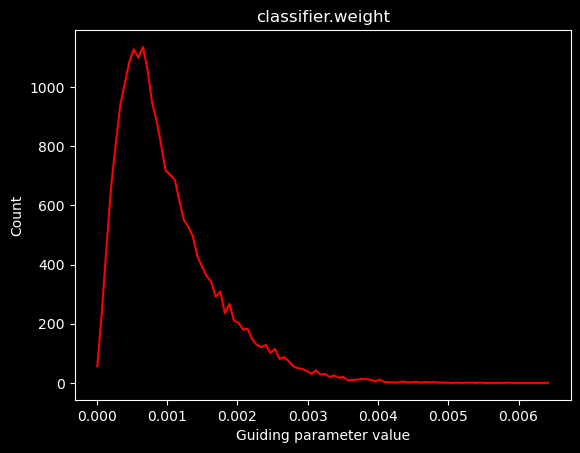

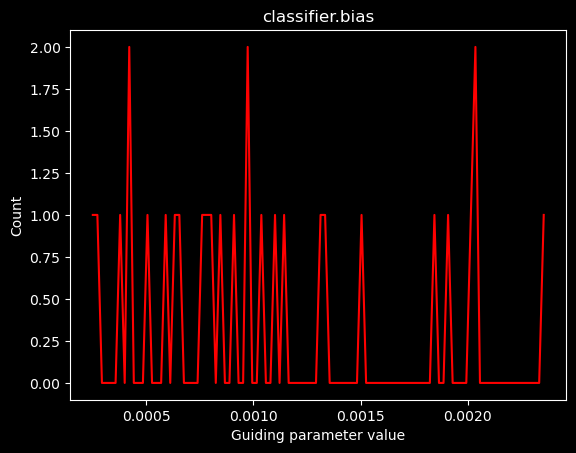

time: 282 ms (started: 2024-07-08 19:07:05 +03:00)


In [28]:
gtl.plot_guidance_distribution(raw_guidance_matrix, name='classifier.weight')
gtl.plot_guidance_distribution(raw_guidance_matrix, name='classifier.bias') 

- Plot all BERT Layers from Guidance Matrix:

In [29]:
encoder_sub_layers_list = ['attention.self.query.weight',
'attention.self.query.bias' ,
'attention.self.key.weight',
 'attention.self.key.bias' ,
 'attention.self.value.weight',  
 'attention.self.value.bias' ,
 'attention.output.dense.weight',  
 'attention.output.dense.bias' ,
 'attention.output.LayerNorm.weight',  
 'attention.output.LayerNorm.bias'  ,
 'intermediate.dense.weight'  ,
 'intermediate.dense.bias'  ,
 'output.dense.weight'  ,
 'output.dense.bias'  ,
 'output.LayerNorm.weight',  
 'output.LayerNorm.bias',  ]

time: 0 ns (started: 2024-07-08 19:07:05 +03:00)


#### Plots

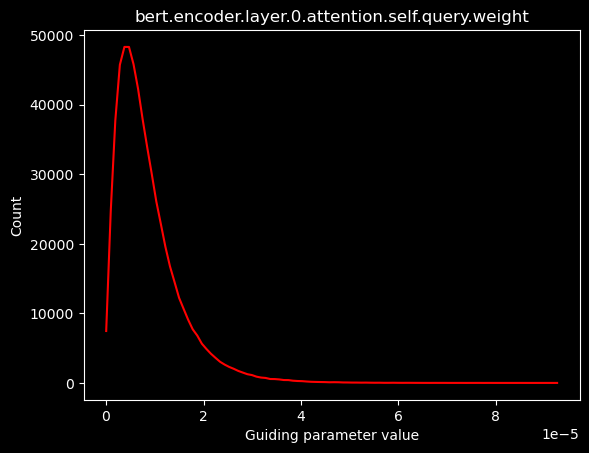

bert.encoder.layer.0.attention.self.query.weight


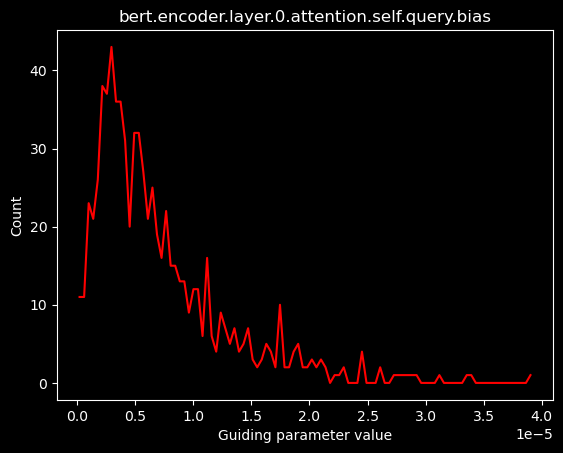

bert.encoder.layer.0.attention.self.query.bias


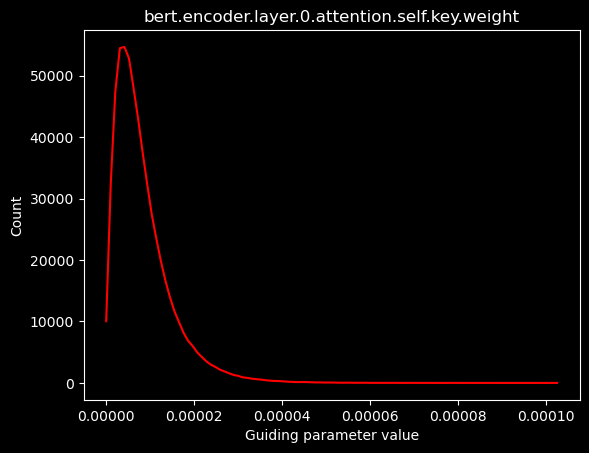

bert.encoder.layer.0.attention.self.key.weight


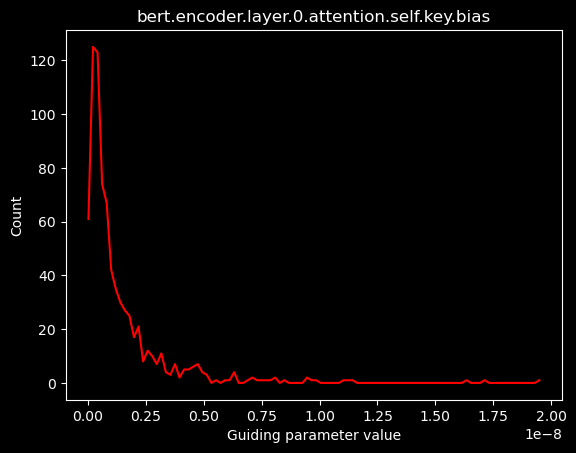

bert.encoder.layer.0.attention.self.key.bias


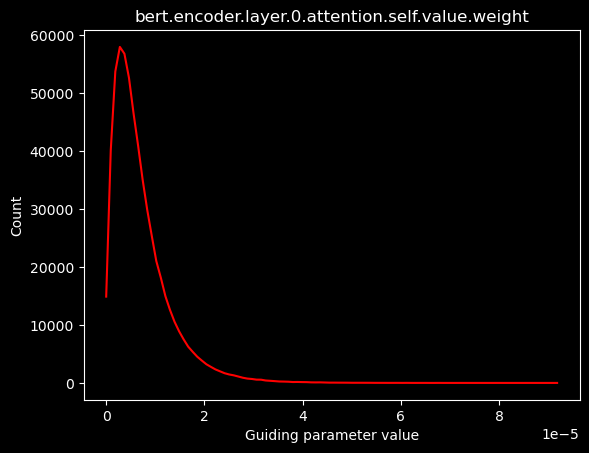

bert.encoder.layer.0.attention.self.value.weight


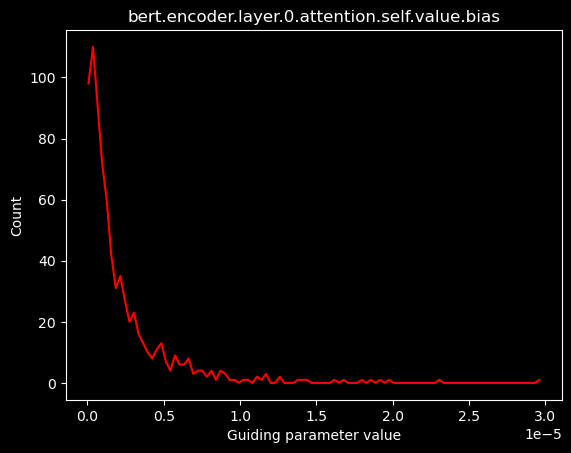

bert.encoder.layer.0.attention.self.value.bias


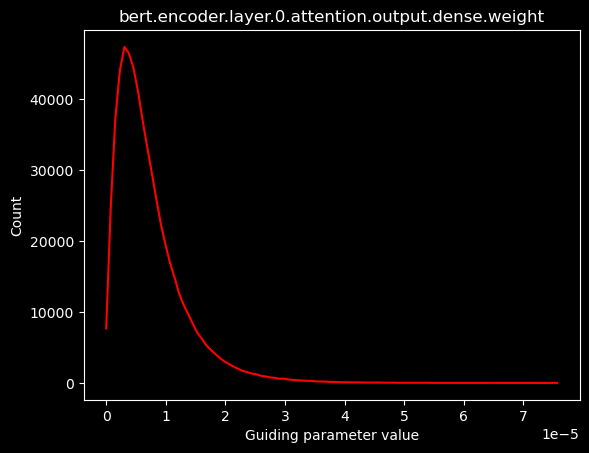

bert.encoder.layer.0.attention.output.dense.weight


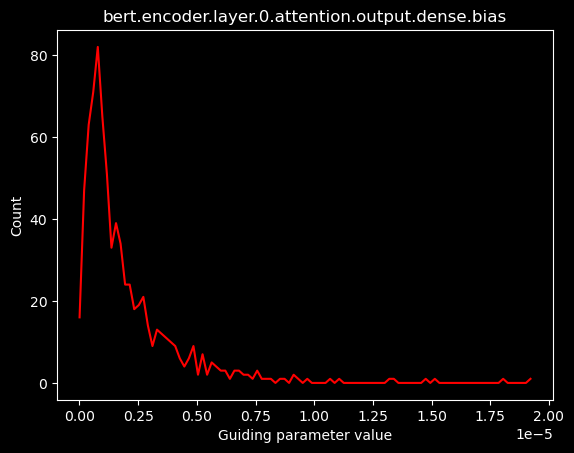

bert.encoder.layer.0.attention.output.dense.bias


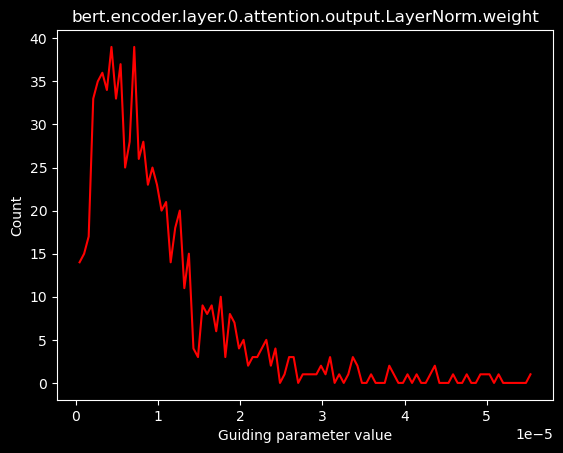

bert.encoder.layer.0.attention.output.LayerNorm.weight


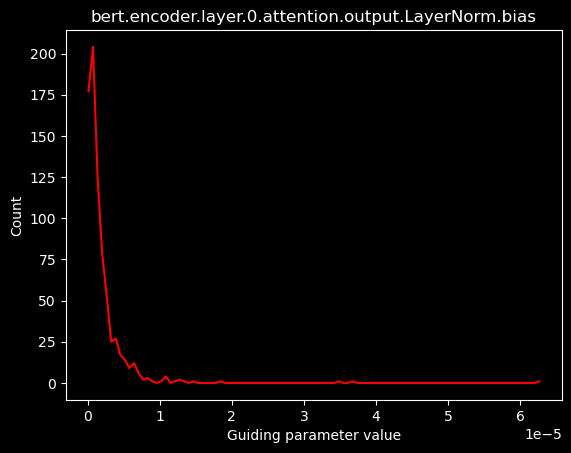

bert.encoder.layer.0.attention.output.LayerNorm.bias


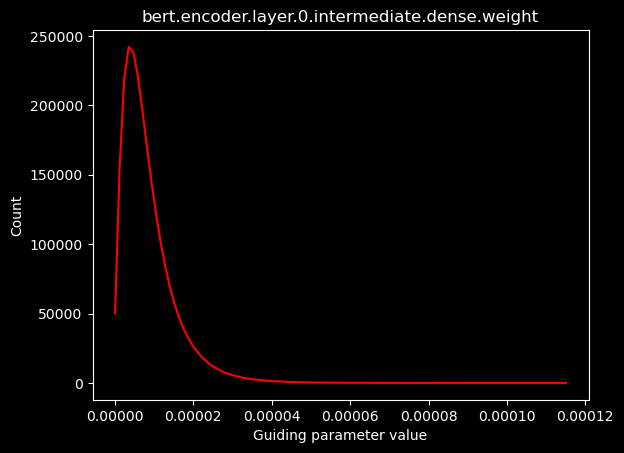

bert.encoder.layer.0.intermediate.dense.weight


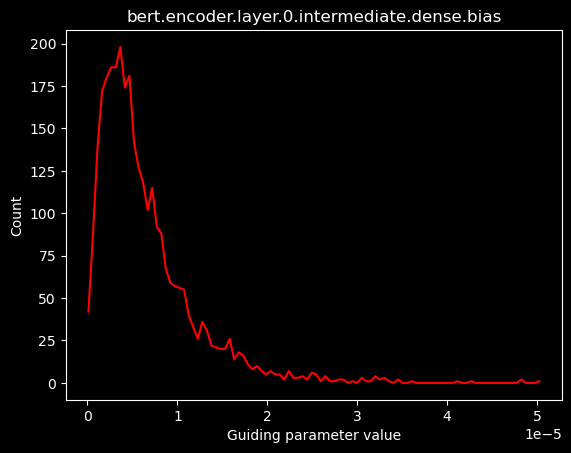

bert.encoder.layer.0.intermediate.dense.bias


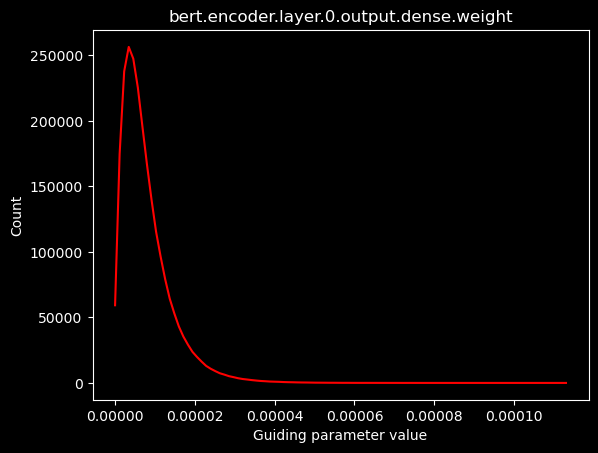

bert.encoder.layer.0.output.dense.weight


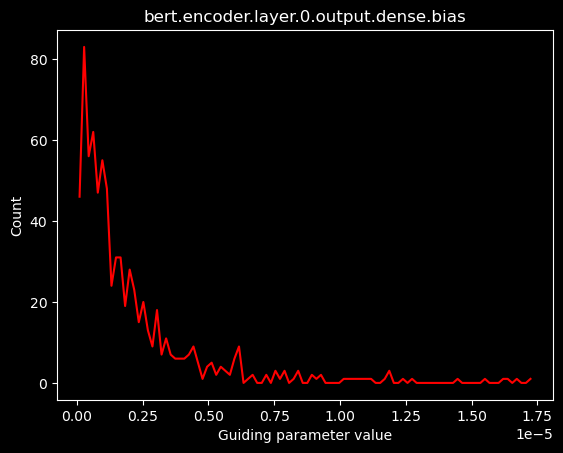

bert.encoder.layer.0.output.dense.bias


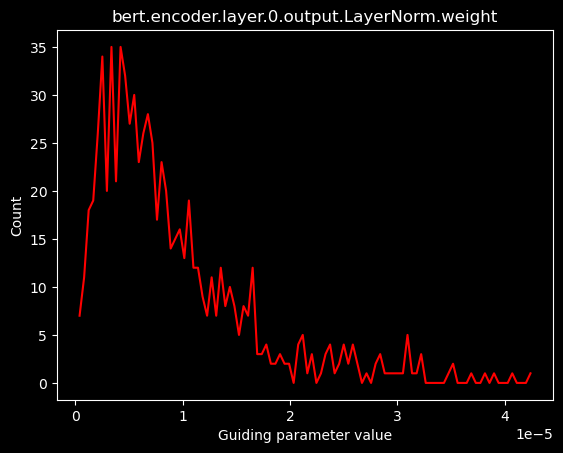

bert.encoder.layer.0.output.LayerNorm.weight


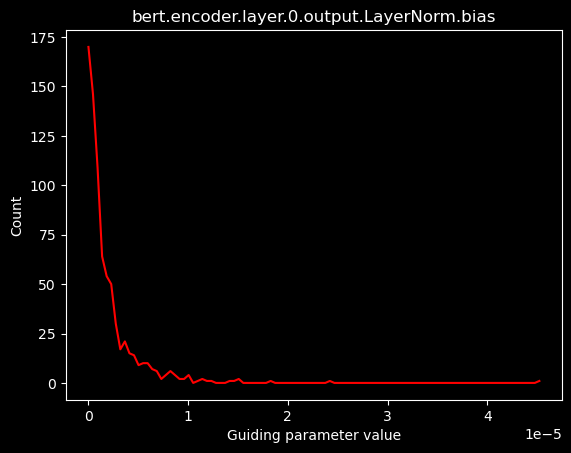

bert.encoder.layer.0.output.LayerNorm.bias


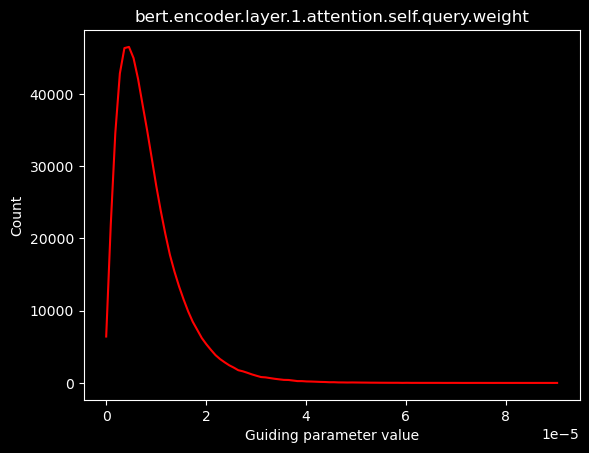

bert.encoder.layer.1.attention.self.query.weight


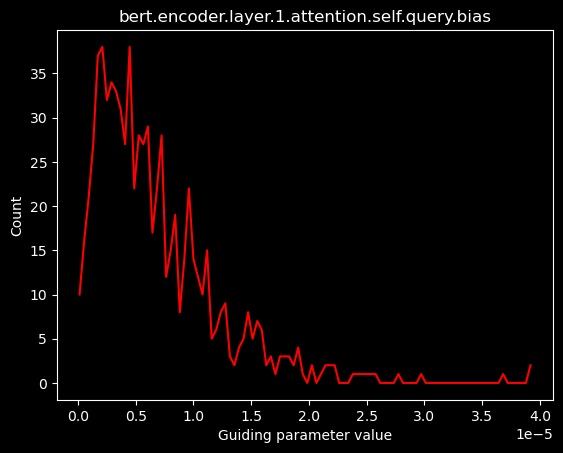

bert.encoder.layer.1.attention.self.query.bias


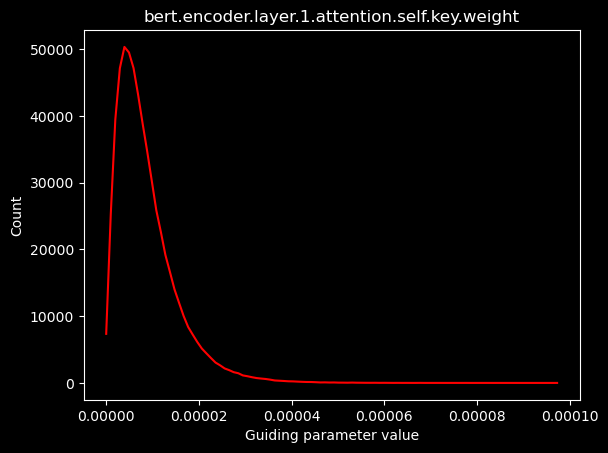

bert.encoder.layer.1.attention.self.key.weight


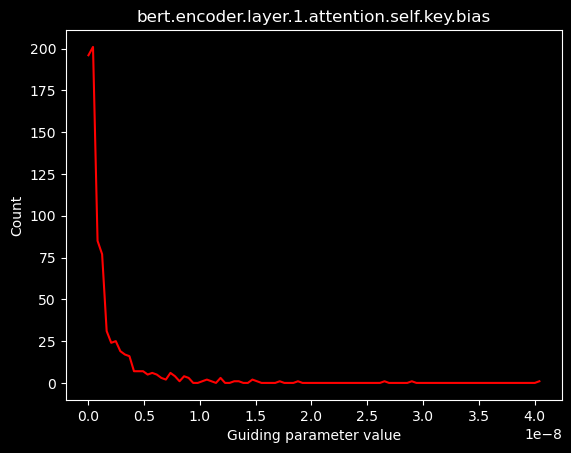

bert.encoder.layer.1.attention.self.key.bias


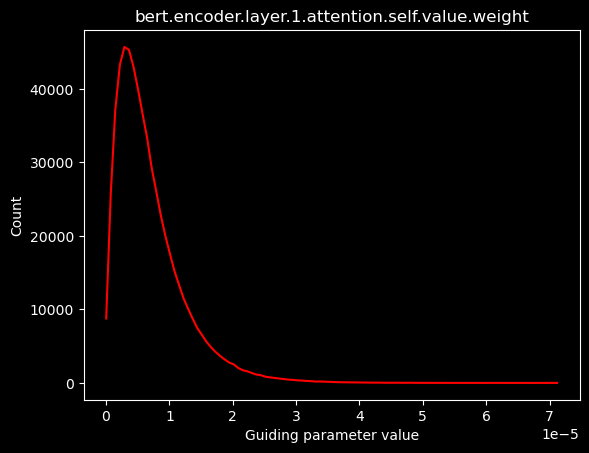

bert.encoder.layer.1.attention.self.value.weight


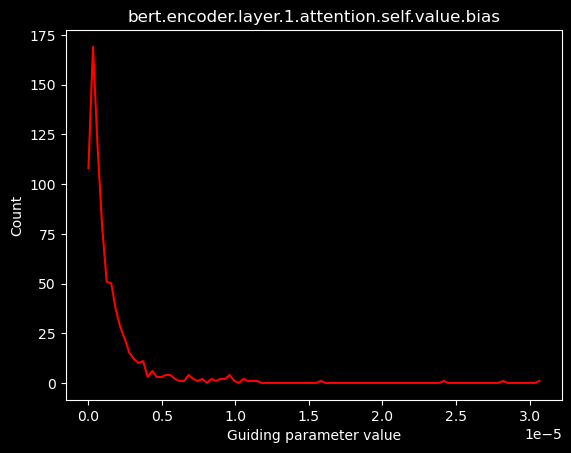

bert.encoder.layer.1.attention.self.value.bias


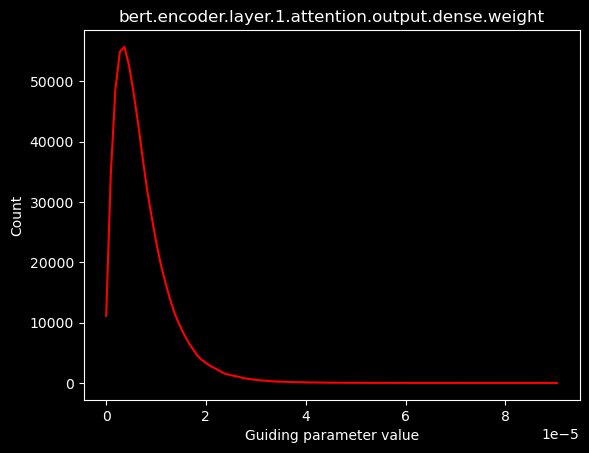

bert.encoder.layer.1.attention.output.dense.weight


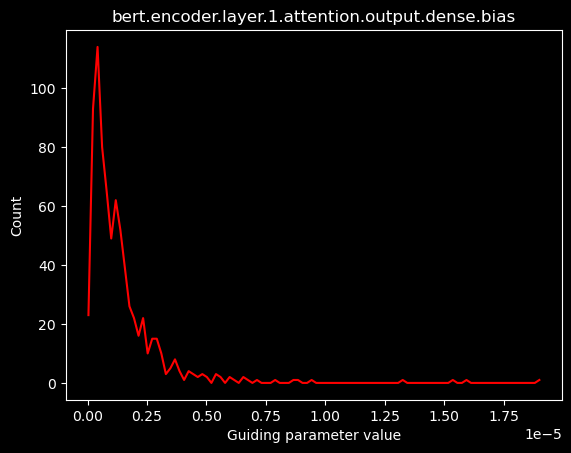

bert.encoder.layer.1.attention.output.dense.bias


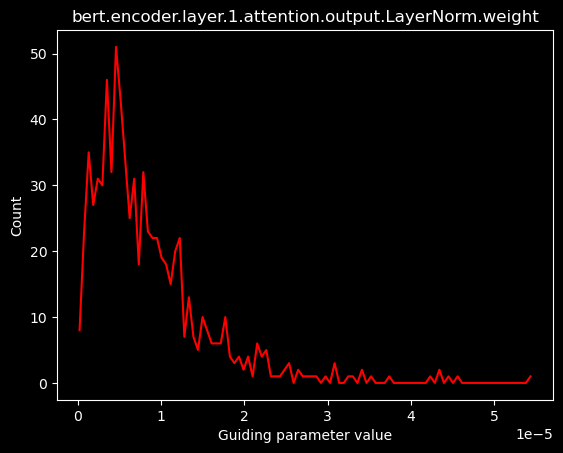

bert.encoder.layer.1.attention.output.LayerNorm.weight


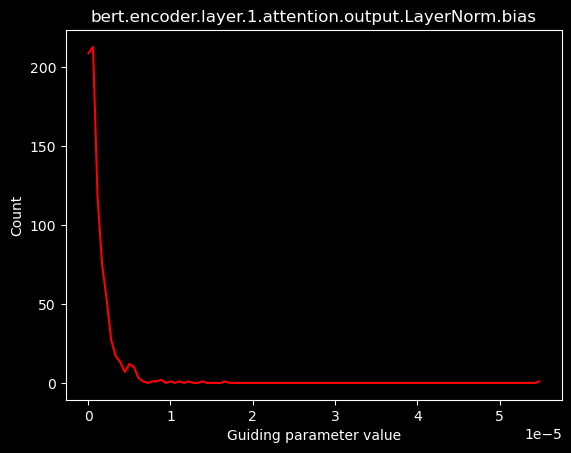

bert.encoder.layer.1.attention.output.LayerNorm.bias


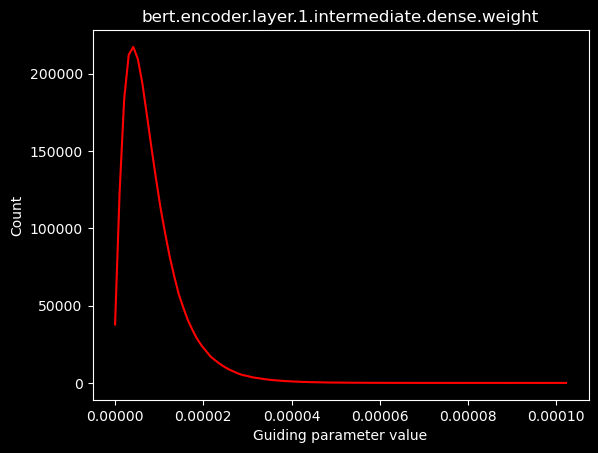

bert.encoder.layer.1.intermediate.dense.weight


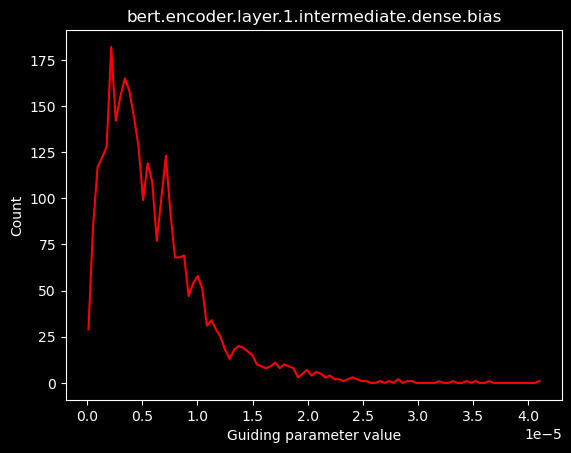

bert.encoder.layer.1.intermediate.dense.bias


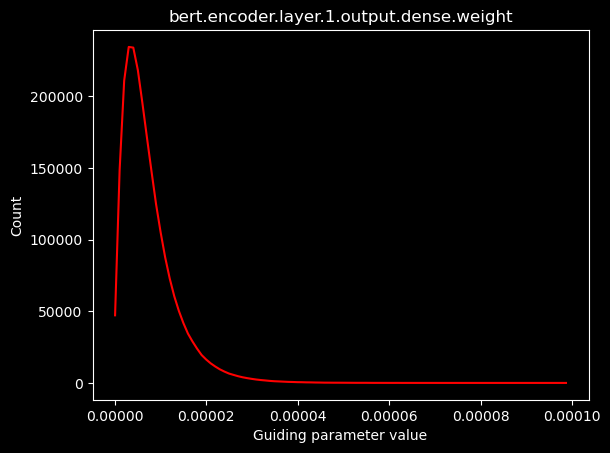

bert.encoder.layer.1.output.dense.weight


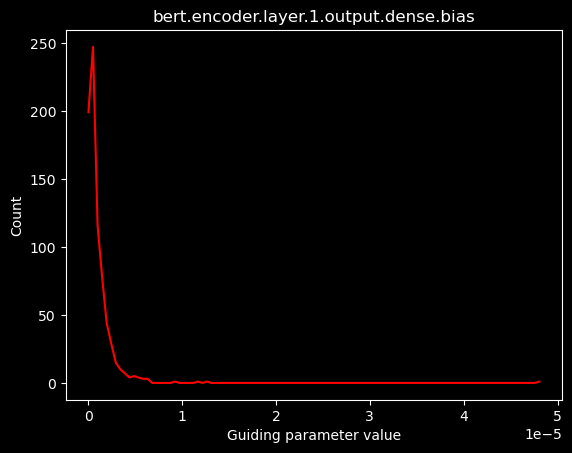

bert.encoder.layer.1.output.dense.bias


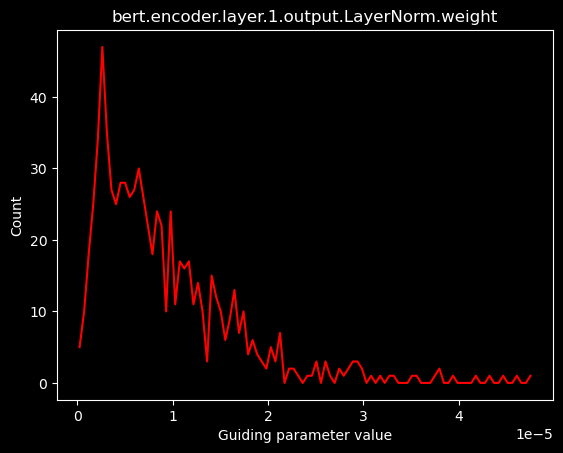

bert.encoder.layer.1.output.LayerNorm.weight


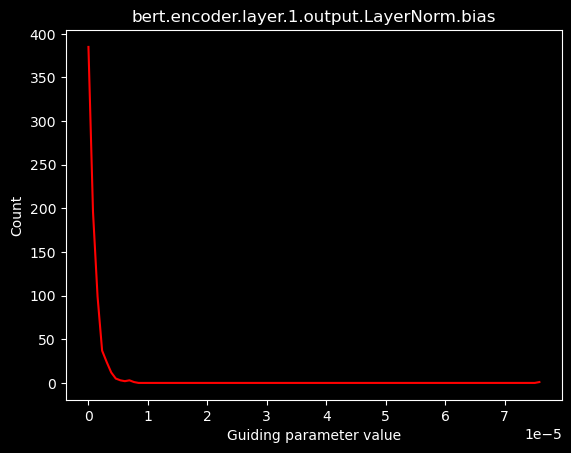

bert.encoder.layer.1.output.LayerNorm.bias


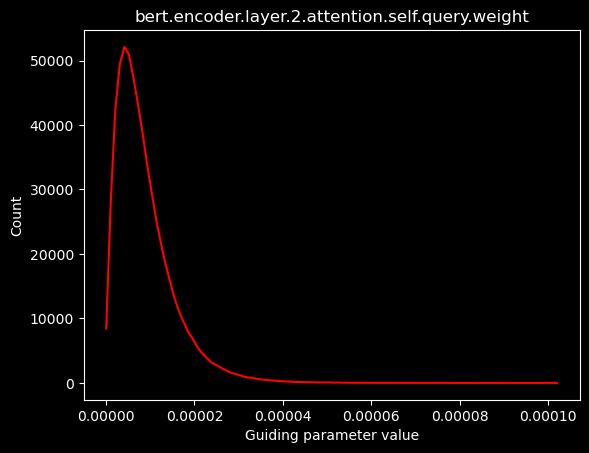

bert.encoder.layer.2.attention.self.query.weight


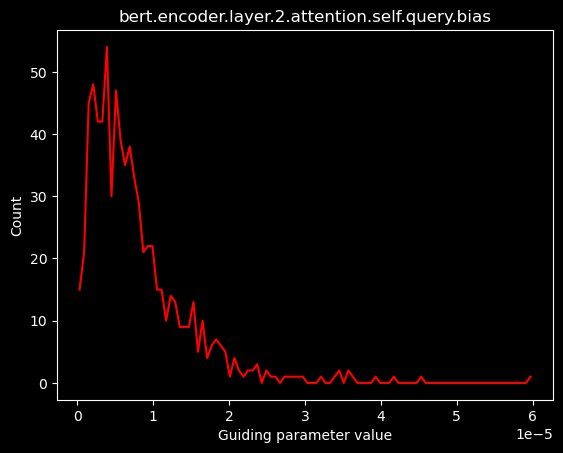

bert.encoder.layer.2.attention.self.query.bias


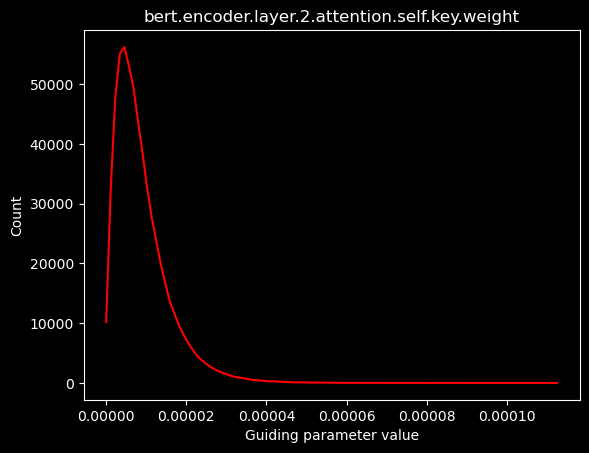

bert.encoder.layer.2.attention.self.key.weight


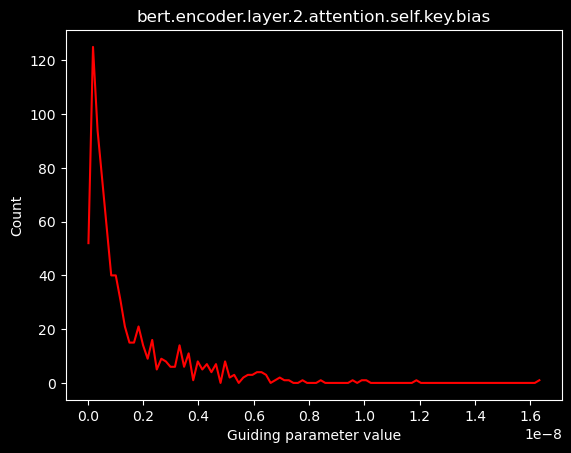

bert.encoder.layer.2.attention.self.key.bias


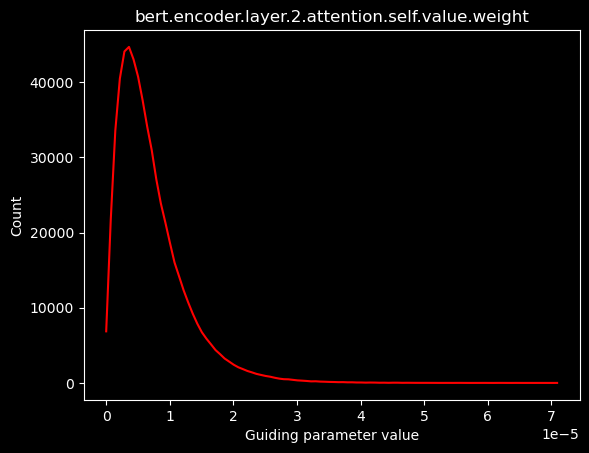

bert.encoder.layer.2.attention.self.value.weight


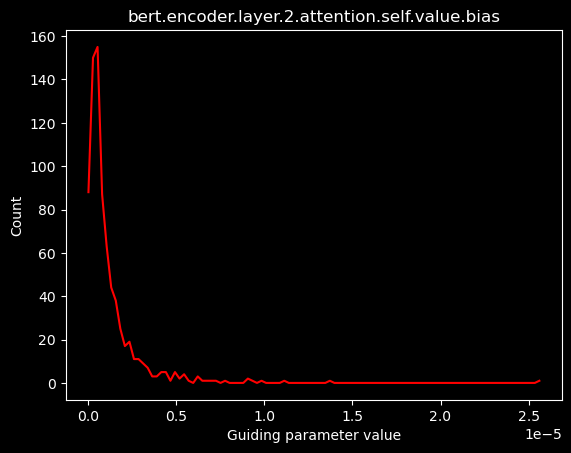

bert.encoder.layer.2.attention.self.value.bias


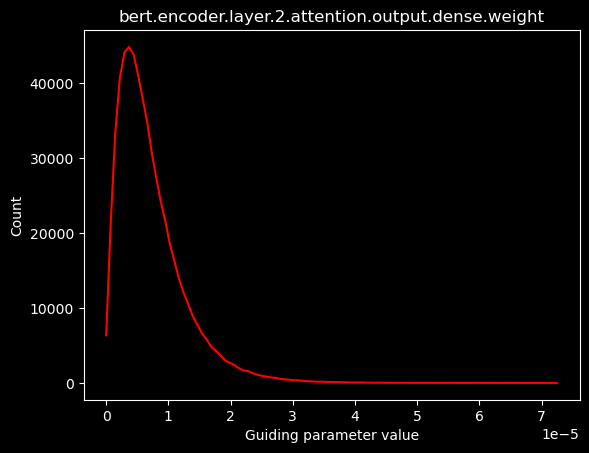

bert.encoder.layer.2.attention.output.dense.weight


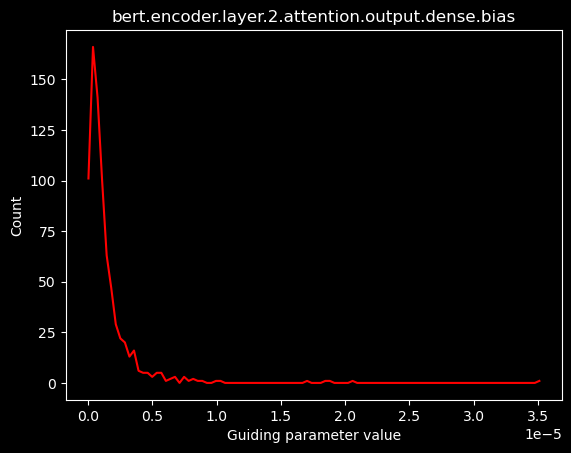

bert.encoder.layer.2.attention.output.dense.bias


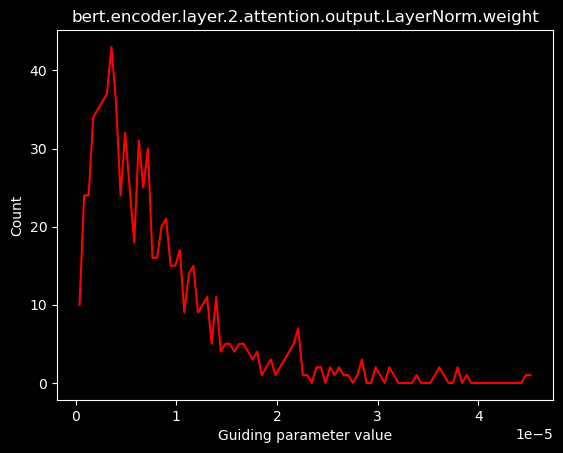

bert.encoder.layer.2.attention.output.LayerNorm.weight


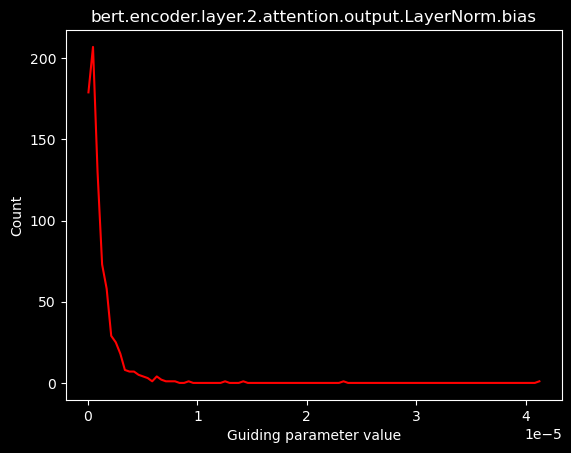

bert.encoder.layer.2.attention.output.LayerNorm.bias


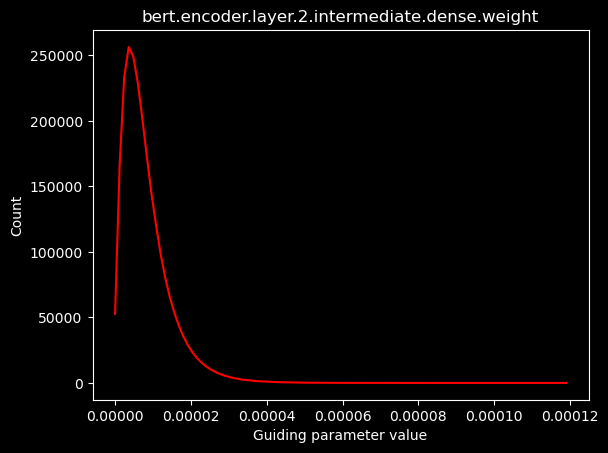

bert.encoder.layer.2.intermediate.dense.weight


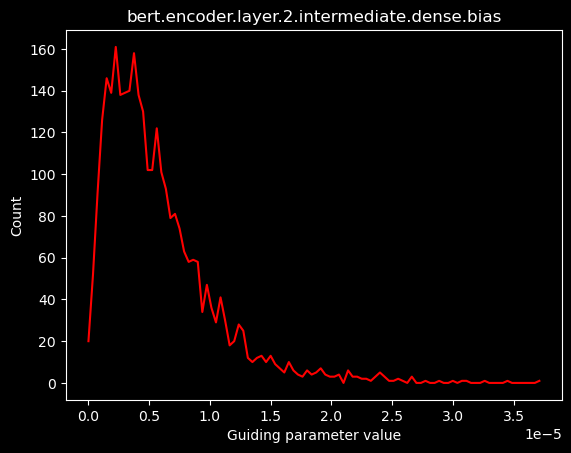

bert.encoder.layer.2.intermediate.dense.bias


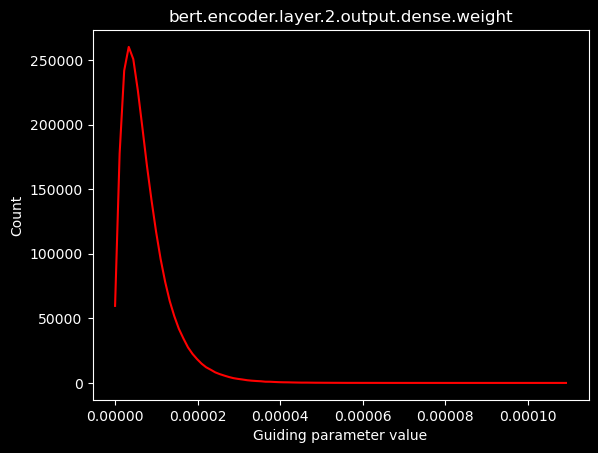

bert.encoder.layer.2.output.dense.weight


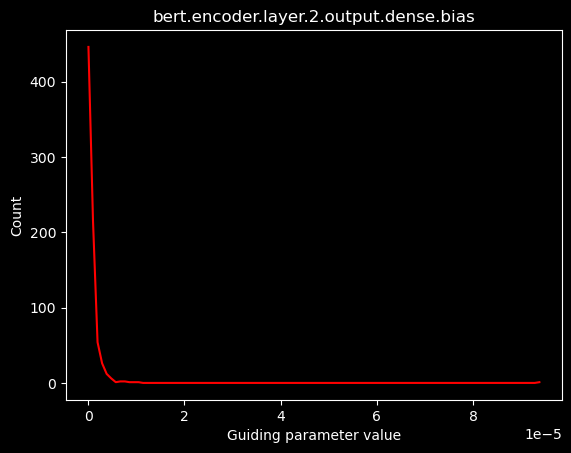

bert.encoder.layer.2.output.dense.bias


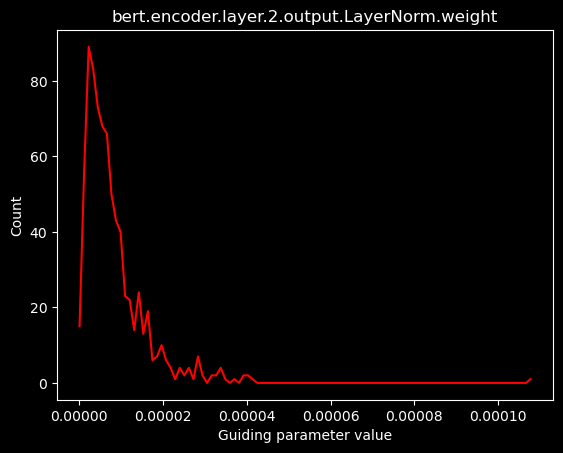

bert.encoder.layer.2.output.LayerNorm.weight


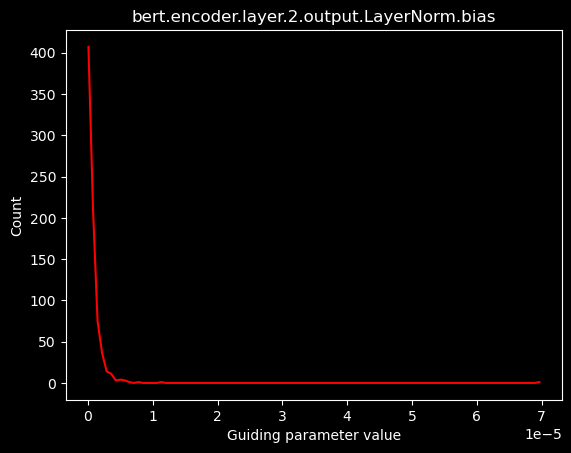

bert.encoder.layer.2.output.LayerNorm.bias


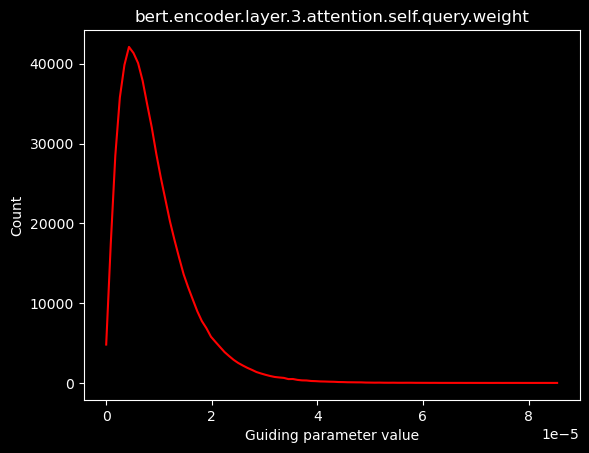

bert.encoder.layer.3.attention.self.query.weight


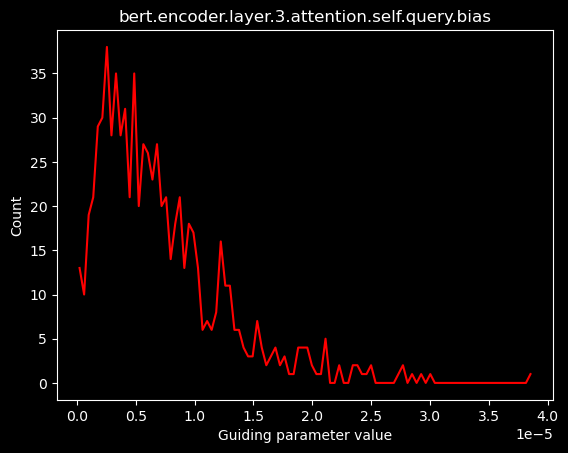

bert.encoder.layer.3.attention.self.query.bias


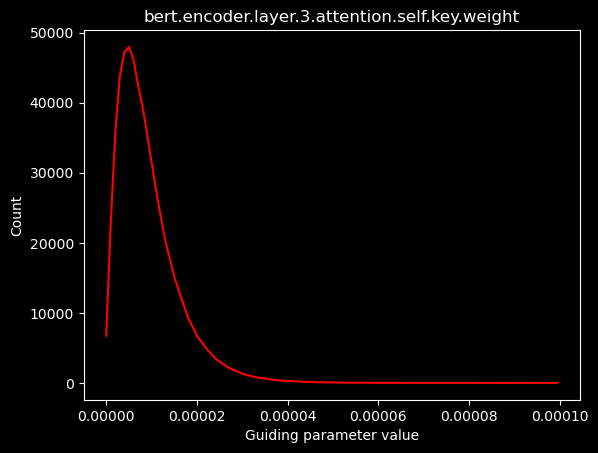

bert.encoder.layer.3.attention.self.key.weight


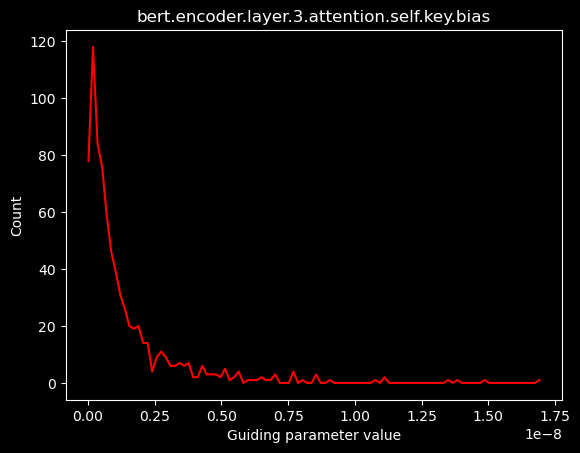

bert.encoder.layer.3.attention.self.key.bias


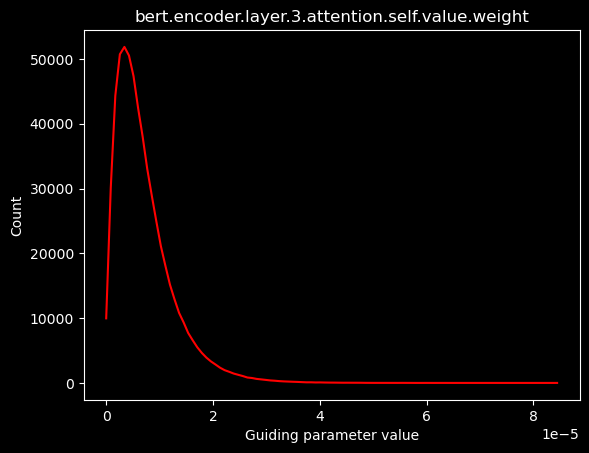

bert.encoder.layer.3.attention.self.value.weight


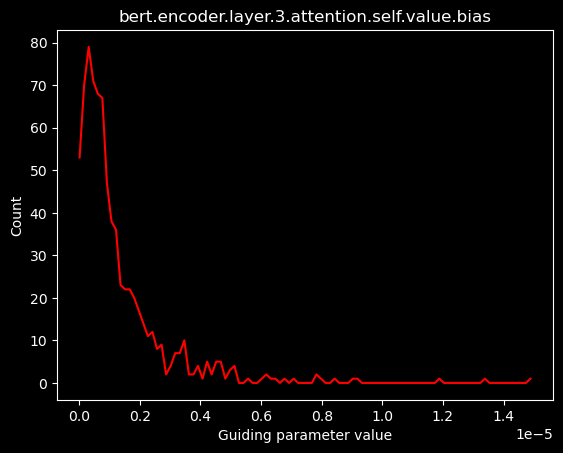

bert.encoder.layer.3.attention.self.value.bias


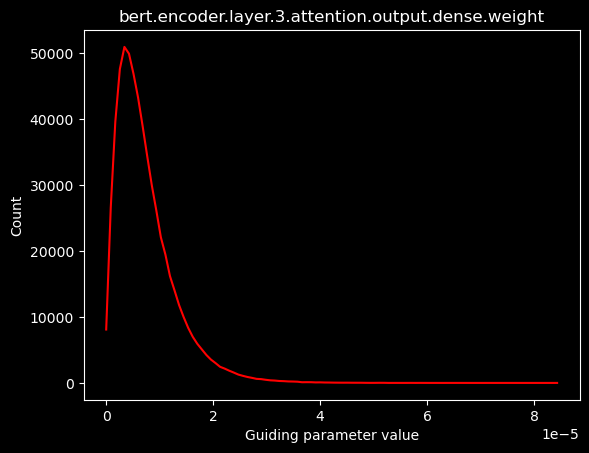

bert.encoder.layer.3.attention.output.dense.weight


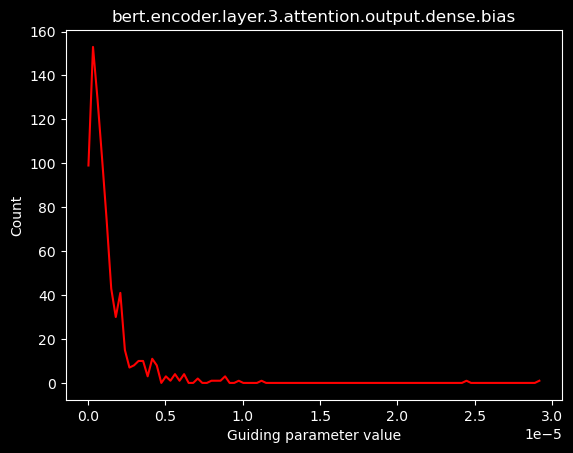

bert.encoder.layer.3.attention.output.dense.bias


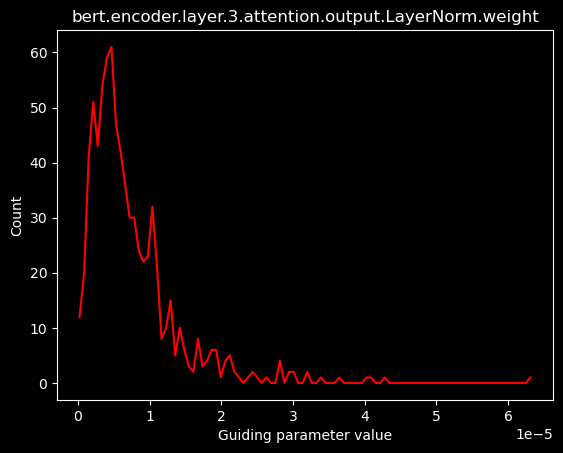

bert.encoder.layer.3.attention.output.LayerNorm.weight


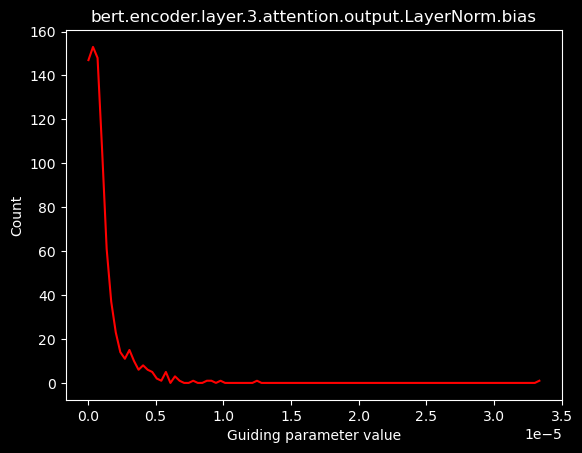

bert.encoder.layer.3.attention.output.LayerNorm.bias


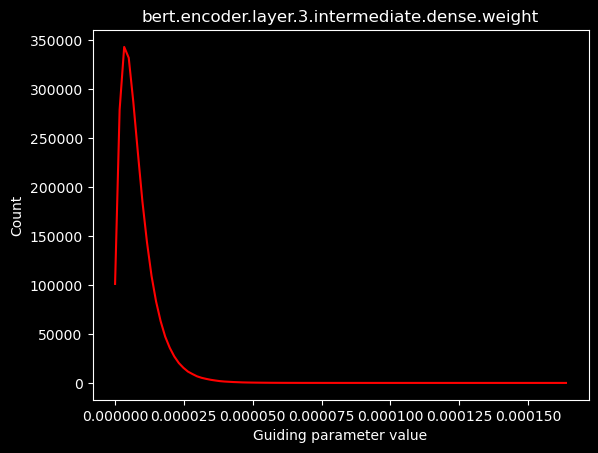

bert.encoder.layer.3.intermediate.dense.weight


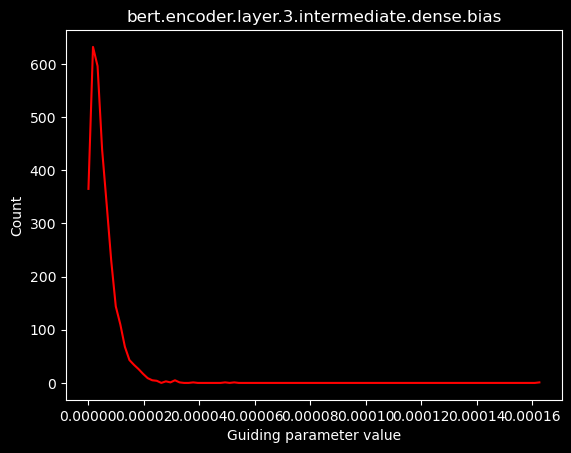

bert.encoder.layer.3.intermediate.dense.bias


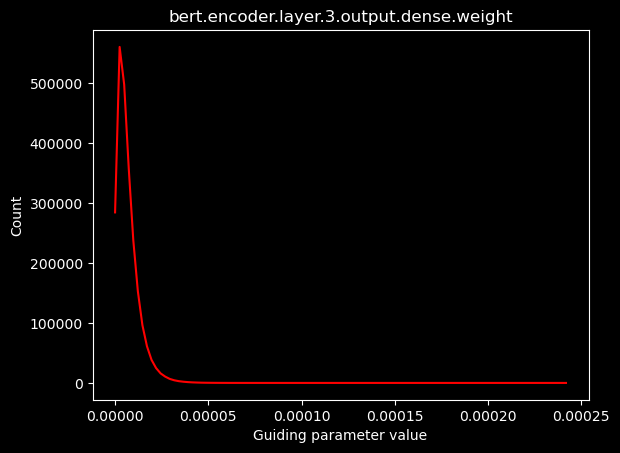

bert.encoder.layer.3.output.dense.weight


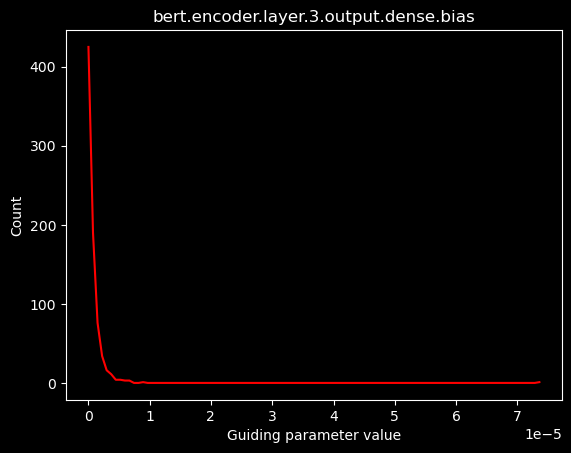

bert.encoder.layer.3.output.dense.bias


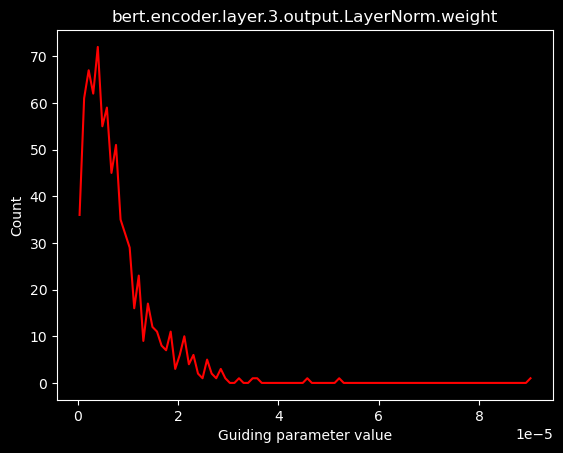

bert.encoder.layer.3.output.LayerNorm.weight


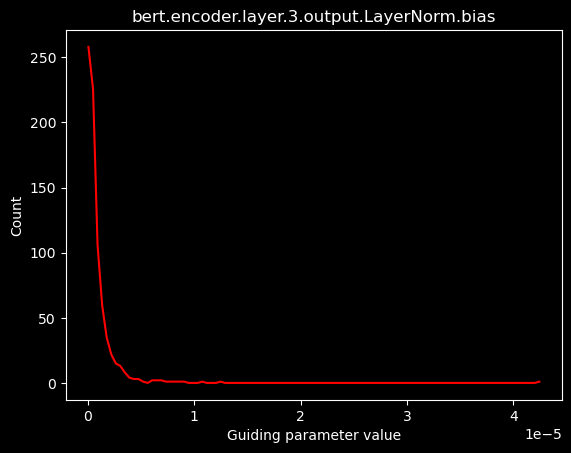

bert.encoder.layer.3.output.LayerNorm.bias


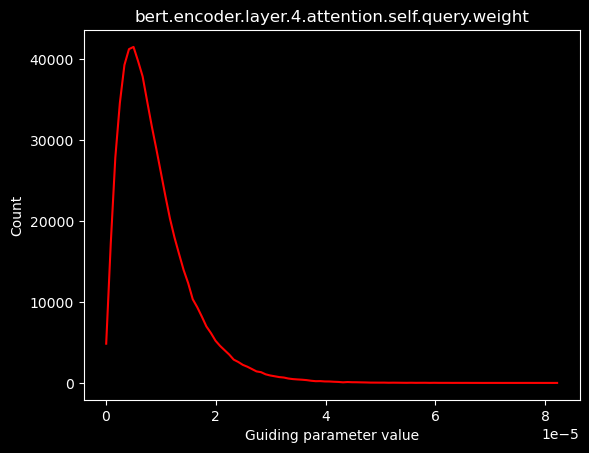

bert.encoder.layer.4.attention.self.query.weight


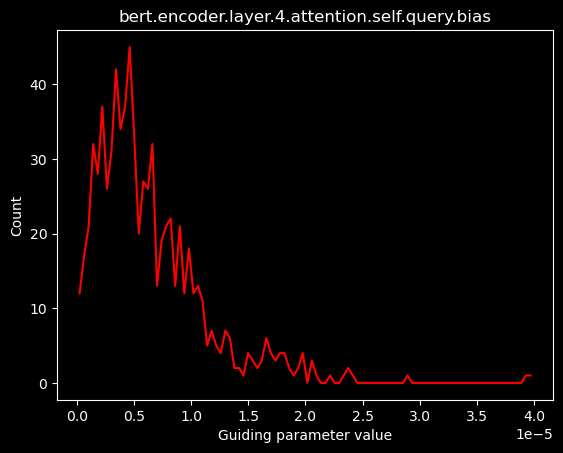

bert.encoder.layer.4.attention.self.query.bias


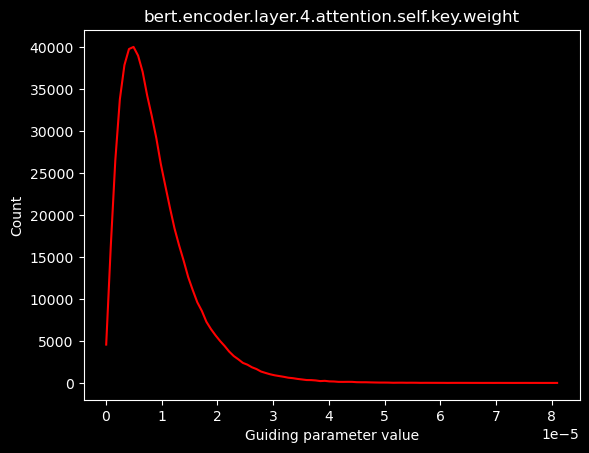

bert.encoder.layer.4.attention.self.key.weight


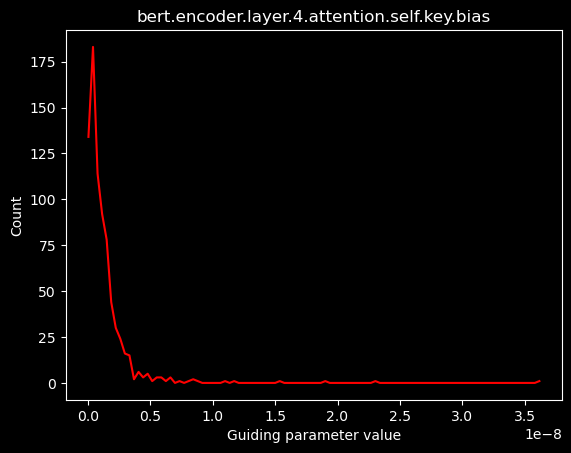

bert.encoder.layer.4.attention.self.key.bias


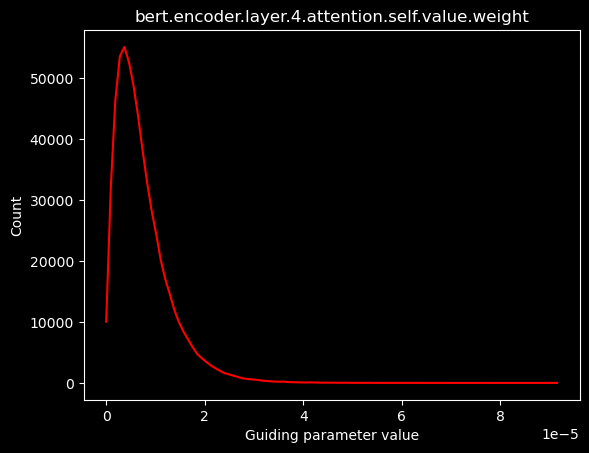

bert.encoder.layer.4.attention.self.value.weight


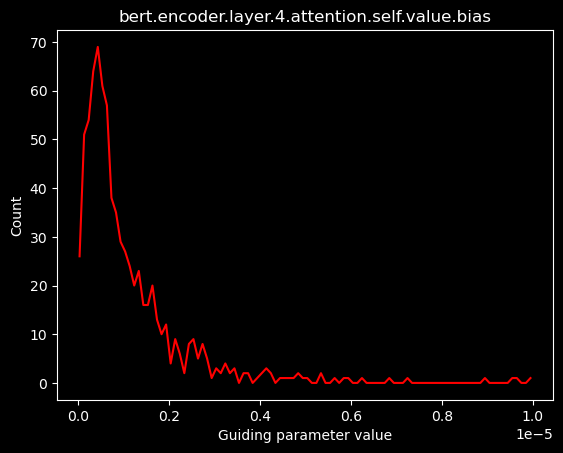

bert.encoder.layer.4.attention.self.value.bias


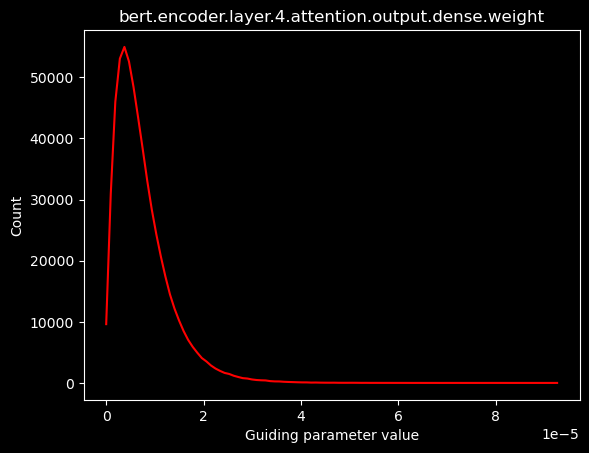

bert.encoder.layer.4.attention.output.dense.weight


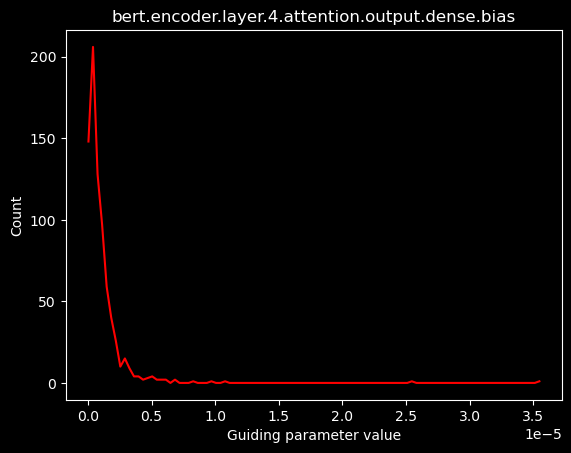

bert.encoder.layer.4.attention.output.dense.bias


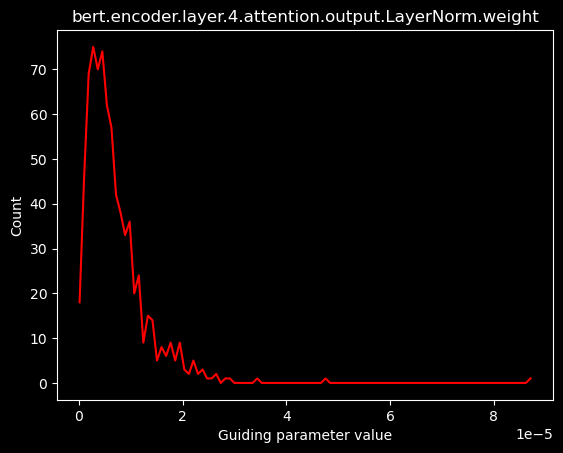

bert.encoder.layer.4.attention.output.LayerNorm.weight


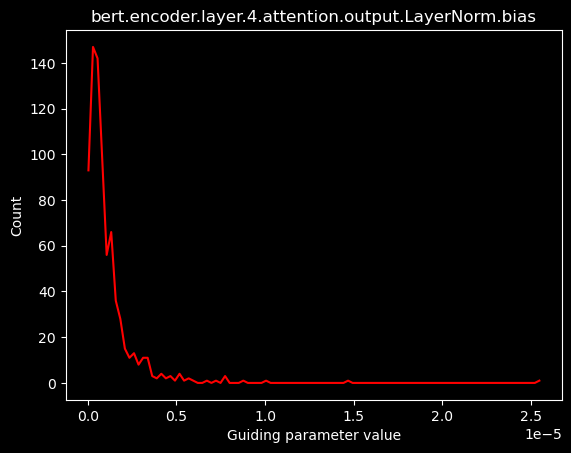

bert.encoder.layer.4.attention.output.LayerNorm.bias


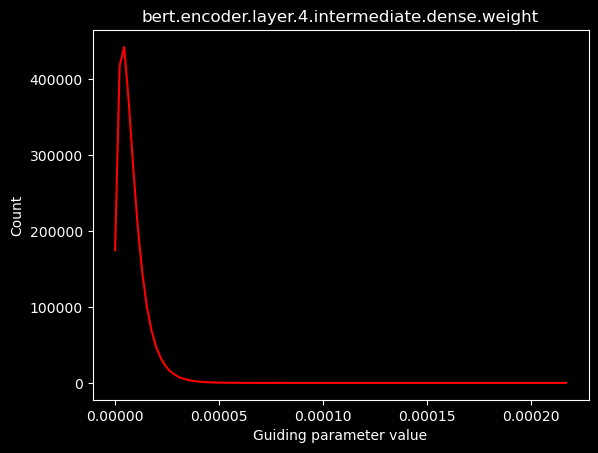

bert.encoder.layer.4.intermediate.dense.weight


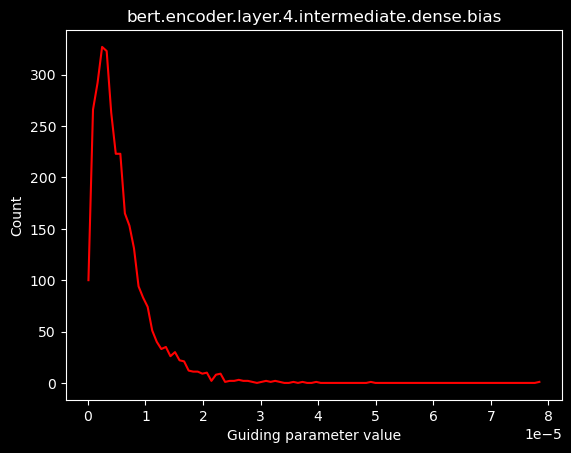

bert.encoder.layer.4.intermediate.dense.bias


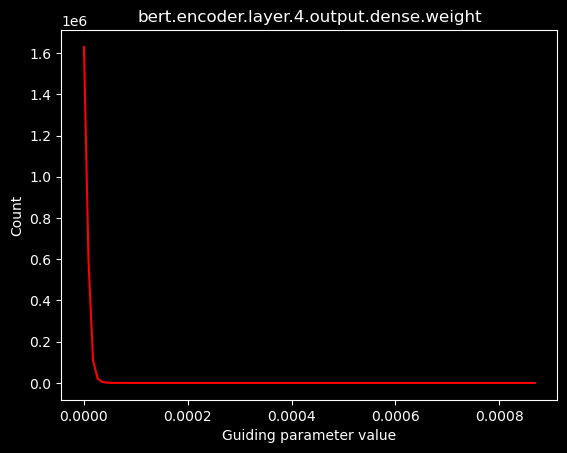

bert.encoder.layer.4.output.dense.weight


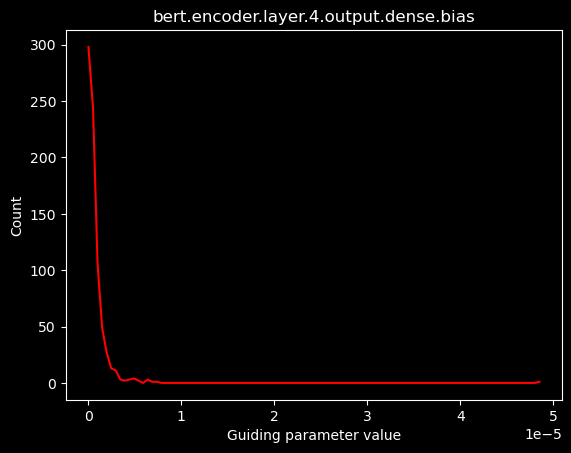

bert.encoder.layer.4.output.dense.bias


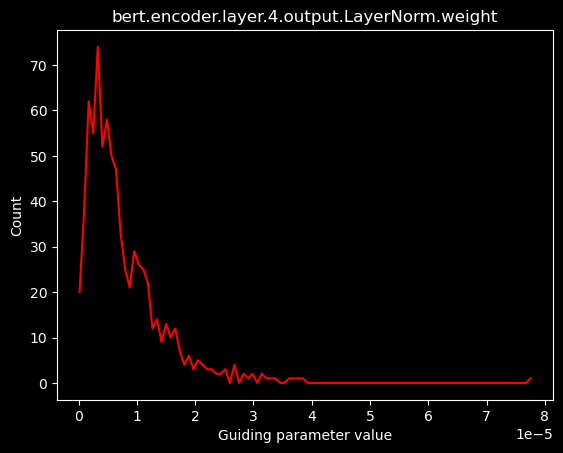

bert.encoder.layer.4.output.LayerNorm.weight


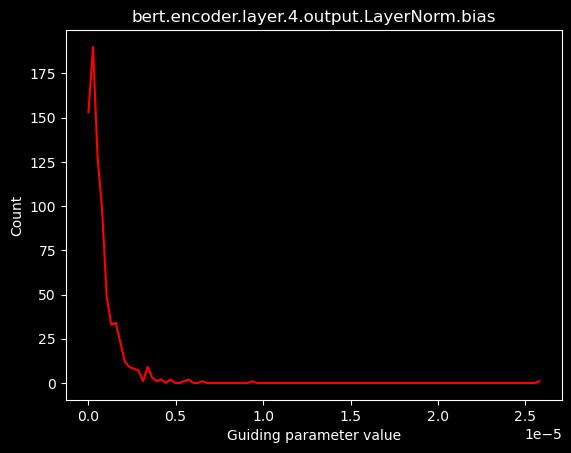

bert.encoder.layer.4.output.LayerNorm.bias


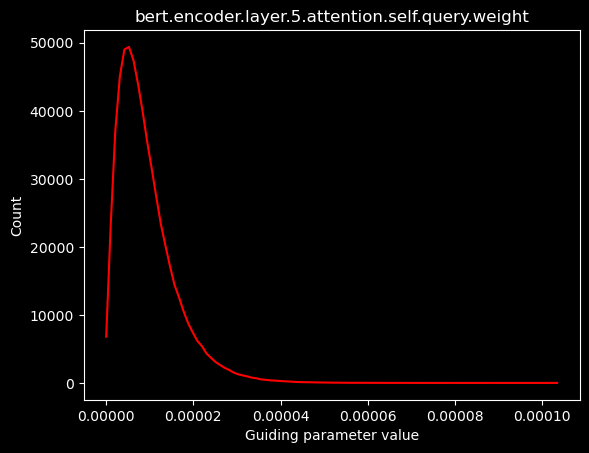

bert.encoder.layer.5.attention.self.query.weight


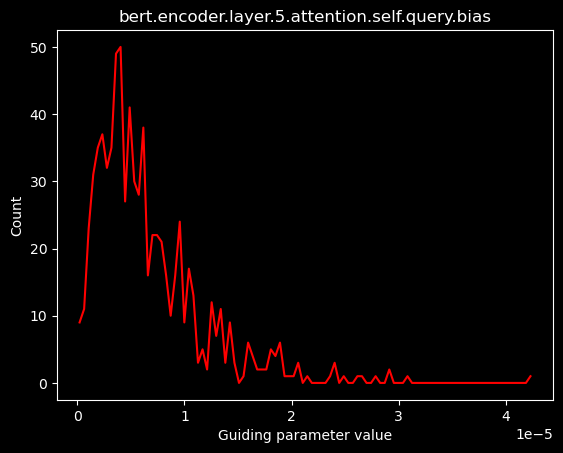

bert.encoder.layer.5.attention.self.query.bias


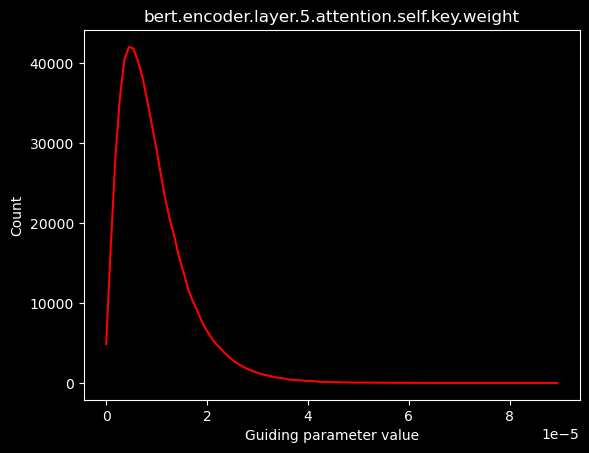

bert.encoder.layer.5.attention.self.key.weight


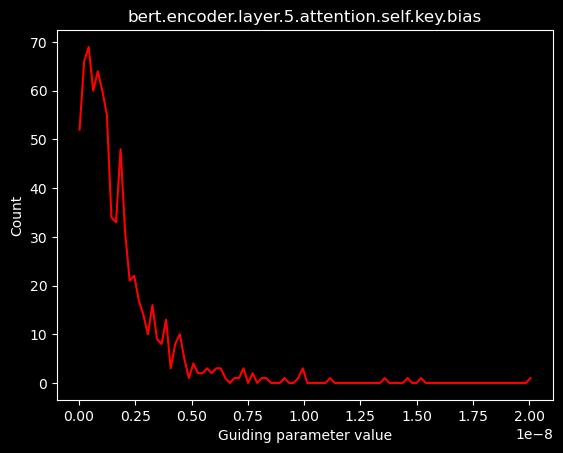

bert.encoder.layer.5.attention.self.key.bias


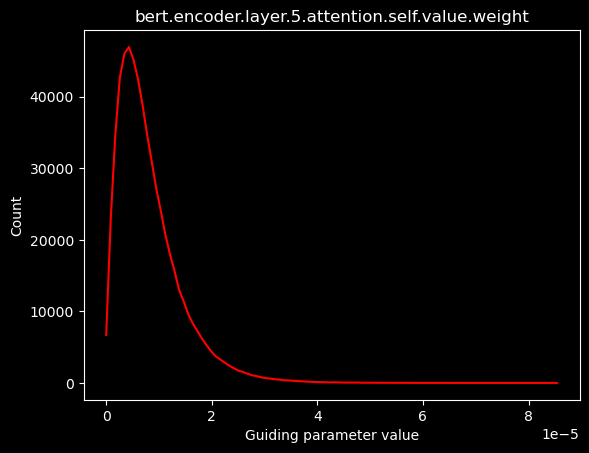

bert.encoder.layer.5.attention.self.value.weight


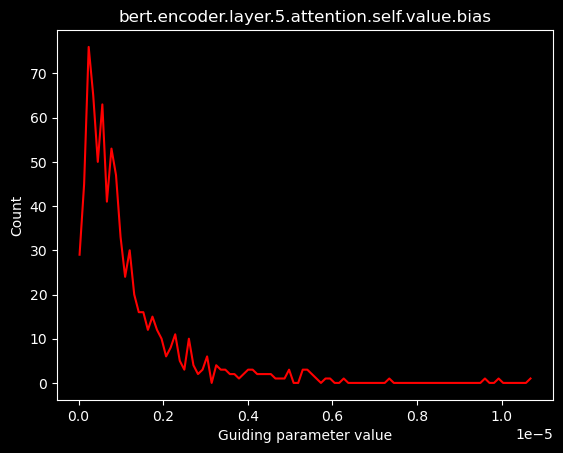

bert.encoder.layer.5.attention.self.value.bias


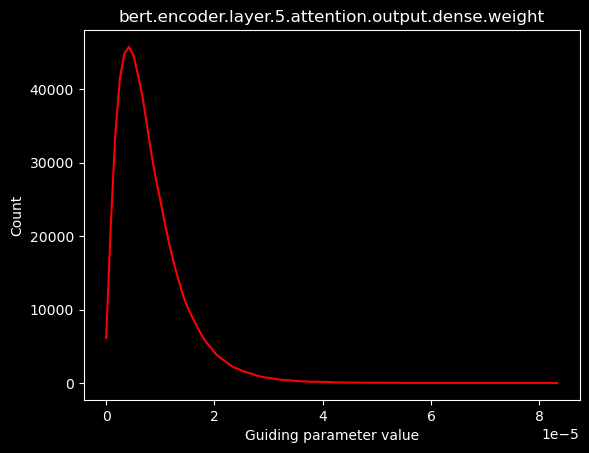

bert.encoder.layer.5.attention.output.dense.weight


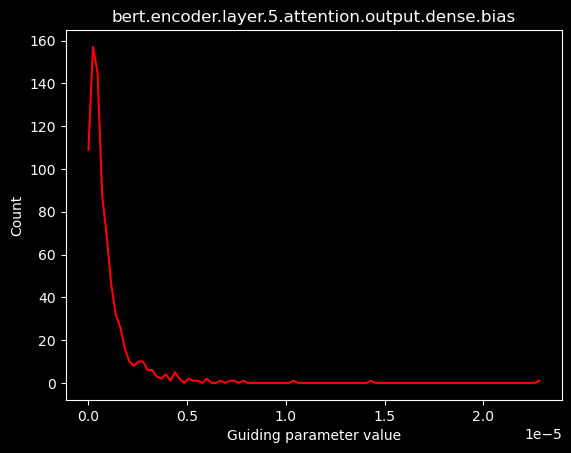

bert.encoder.layer.5.attention.output.dense.bias


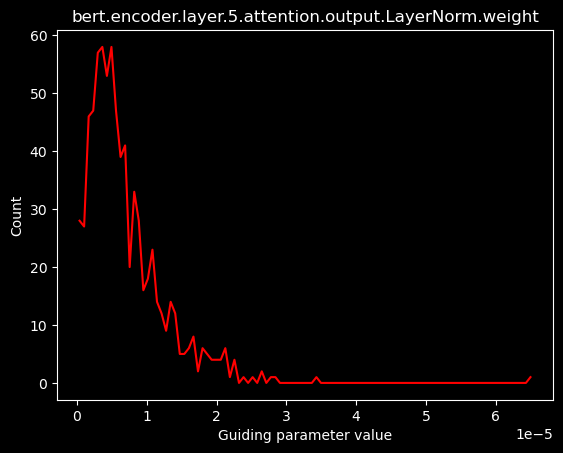

bert.encoder.layer.5.attention.output.LayerNorm.weight


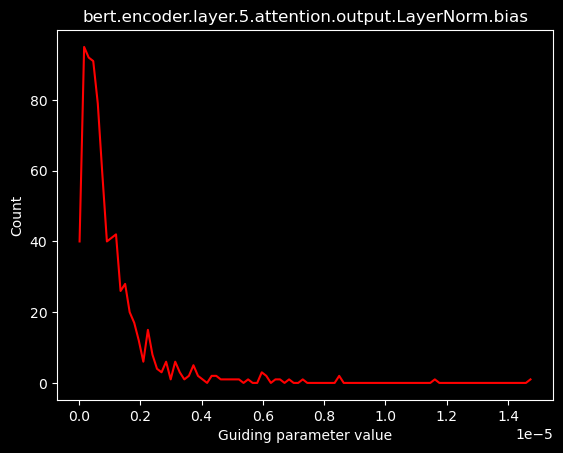

bert.encoder.layer.5.attention.output.LayerNorm.bias


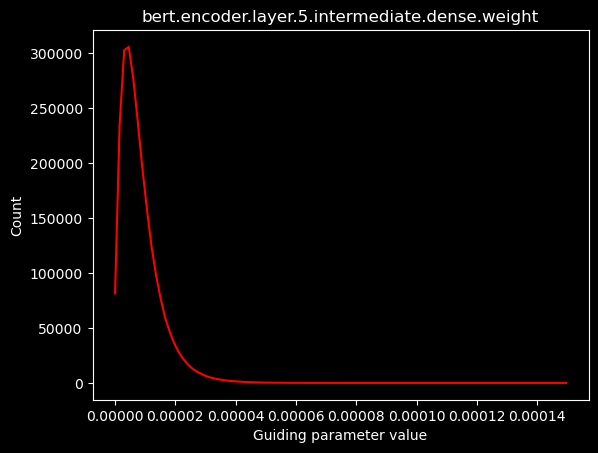

bert.encoder.layer.5.intermediate.dense.weight


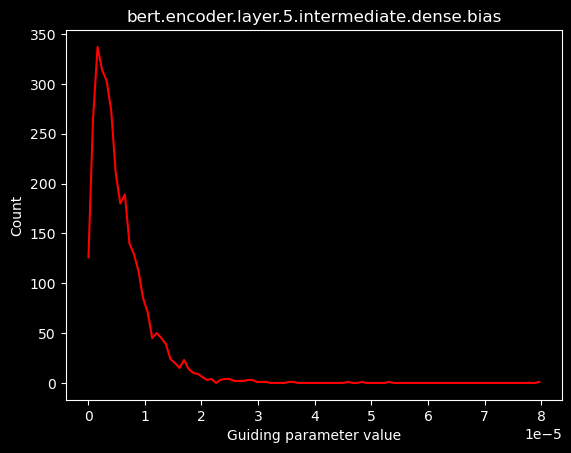

bert.encoder.layer.5.intermediate.dense.bias


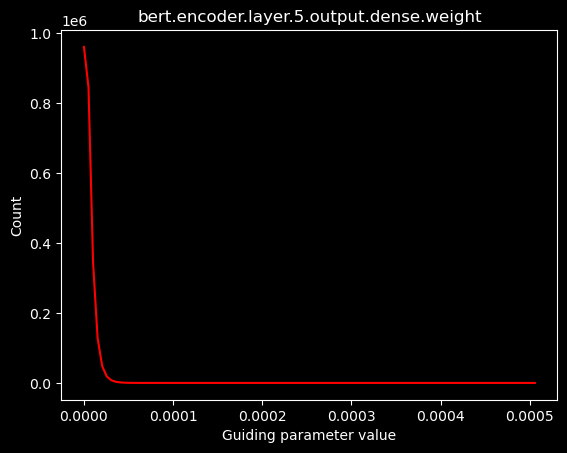

bert.encoder.layer.5.output.dense.weight


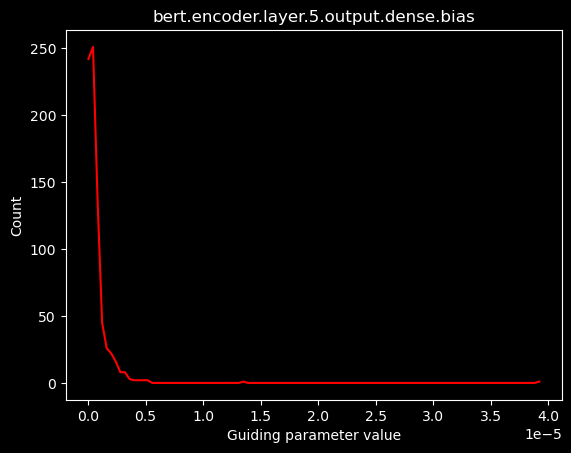

bert.encoder.layer.5.output.dense.bias


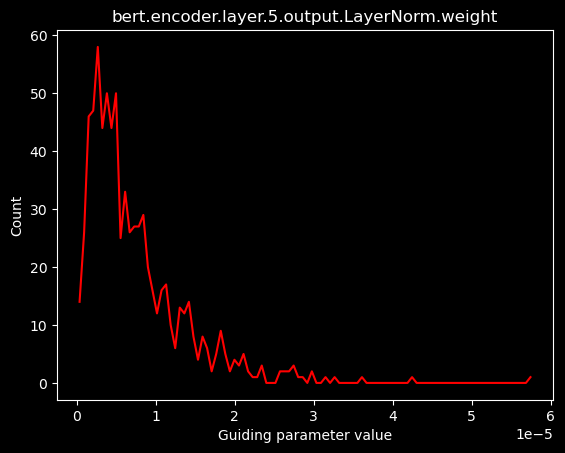

bert.encoder.layer.5.output.LayerNorm.weight


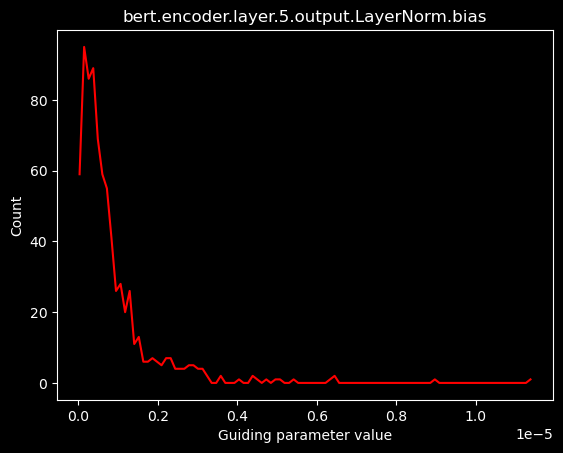

bert.encoder.layer.5.output.LayerNorm.bias


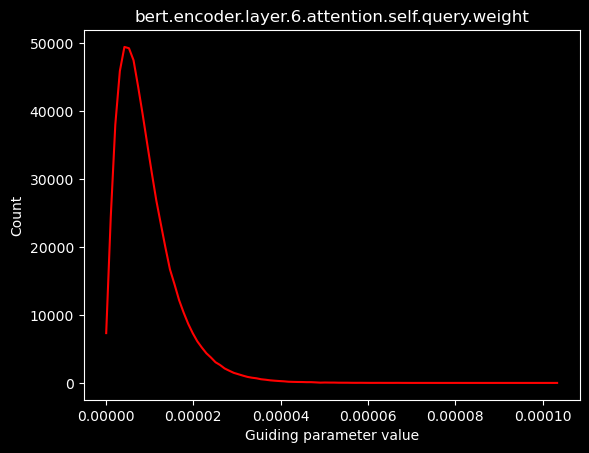

bert.encoder.layer.6.attention.self.query.weight


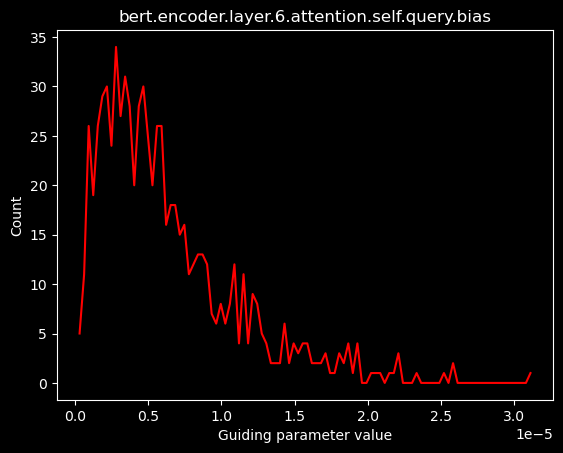

bert.encoder.layer.6.attention.self.query.bias


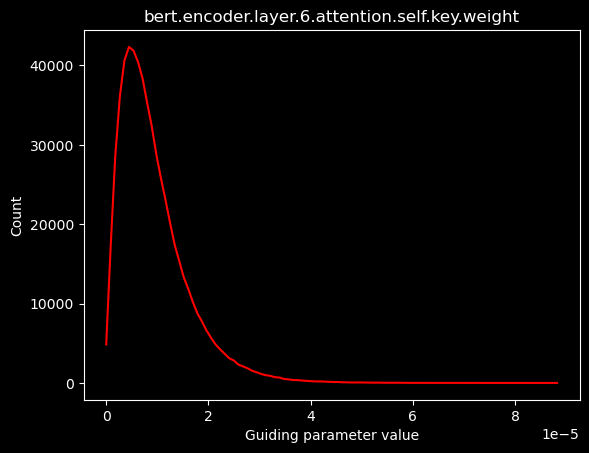

bert.encoder.layer.6.attention.self.key.weight


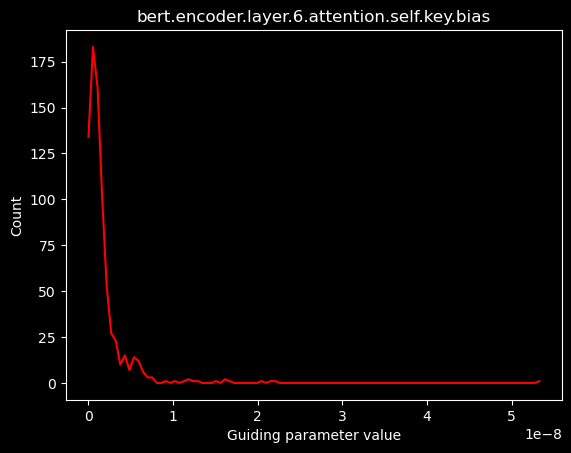

bert.encoder.layer.6.attention.self.key.bias


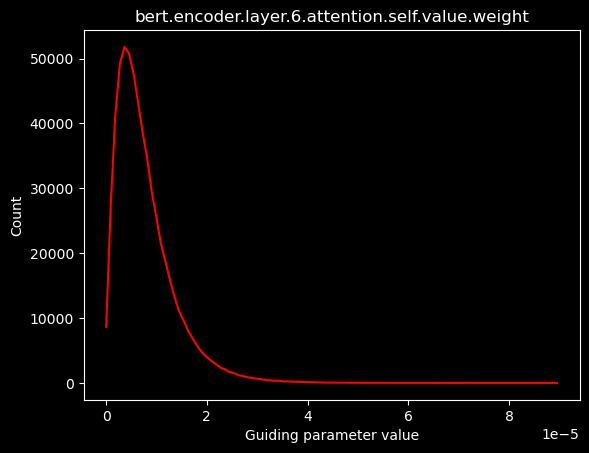

bert.encoder.layer.6.attention.self.value.weight


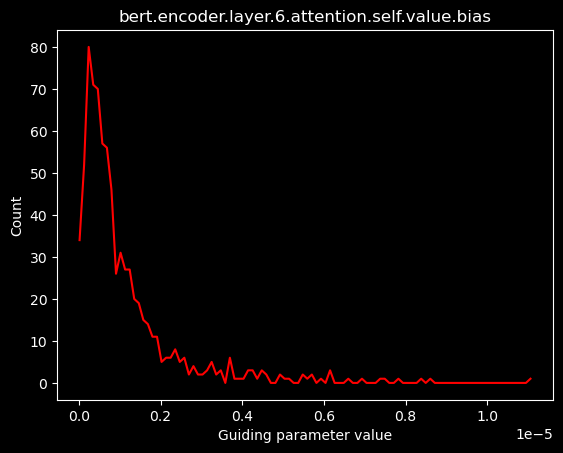

bert.encoder.layer.6.attention.self.value.bias


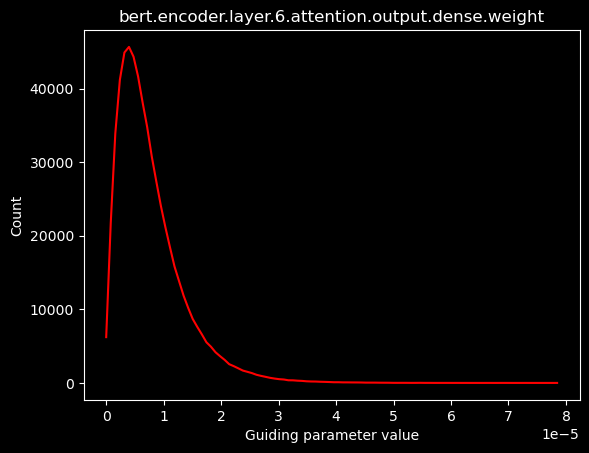

bert.encoder.layer.6.attention.output.dense.weight


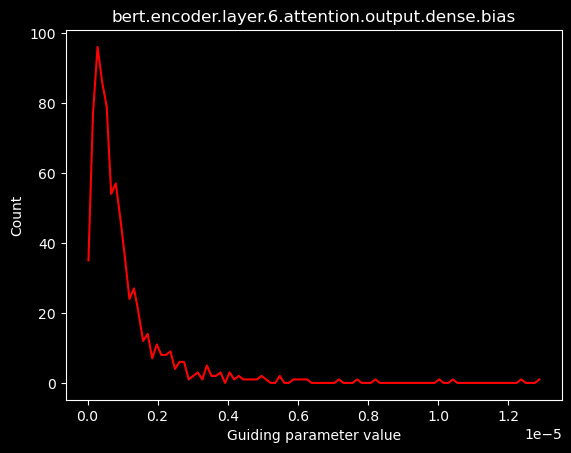

bert.encoder.layer.6.attention.output.dense.bias


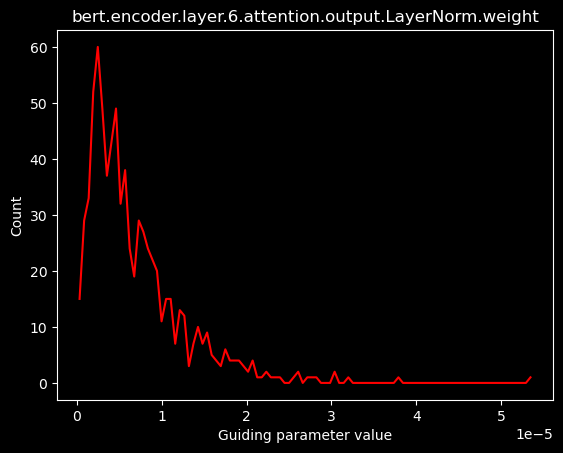

bert.encoder.layer.6.attention.output.LayerNorm.weight


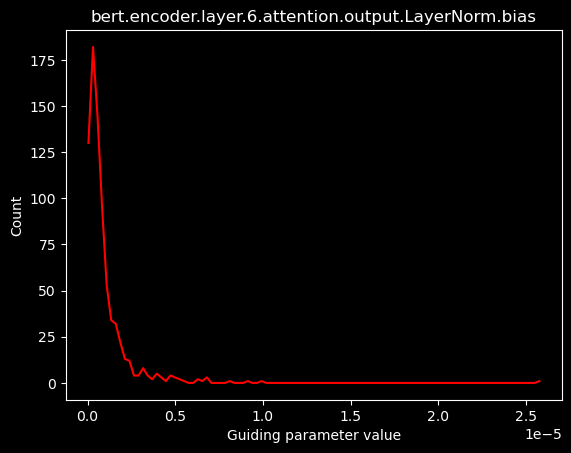

bert.encoder.layer.6.attention.output.LayerNorm.bias


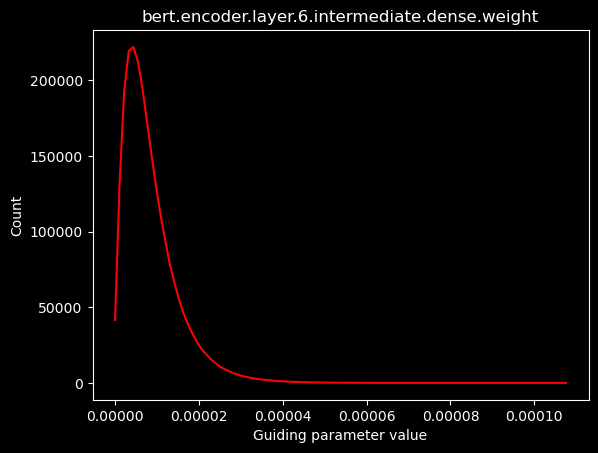

bert.encoder.layer.6.intermediate.dense.weight


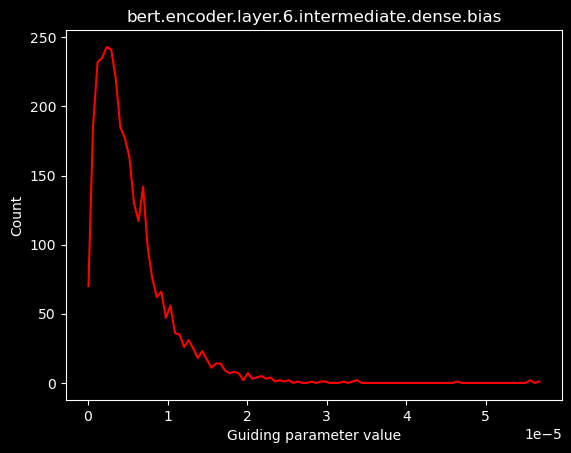

bert.encoder.layer.6.intermediate.dense.bias


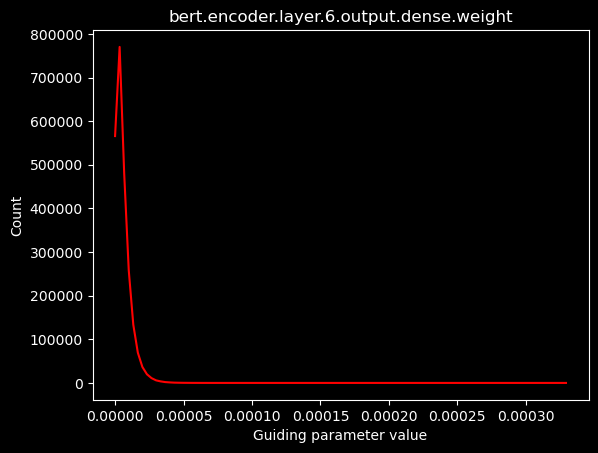

bert.encoder.layer.6.output.dense.weight


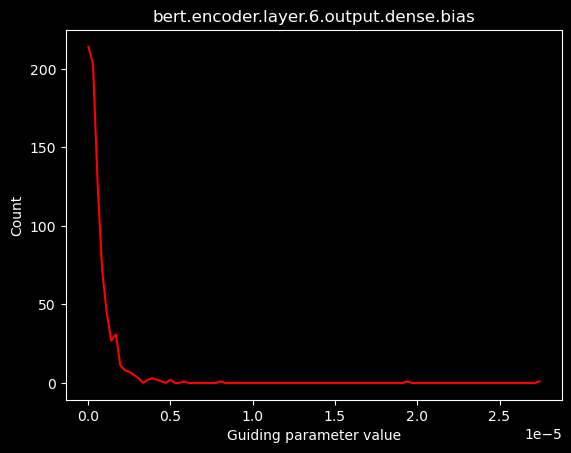

bert.encoder.layer.6.output.dense.bias


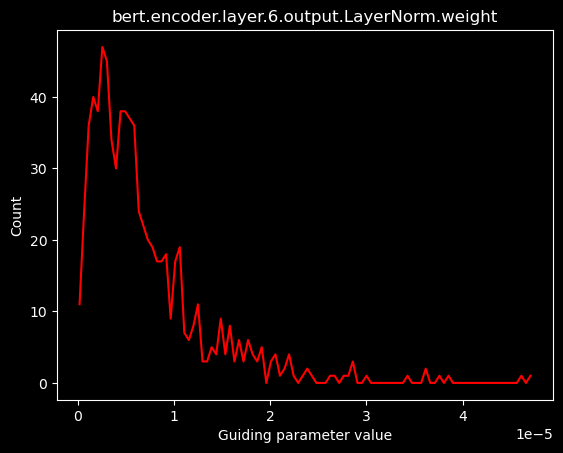

bert.encoder.layer.6.output.LayerNorm.weight


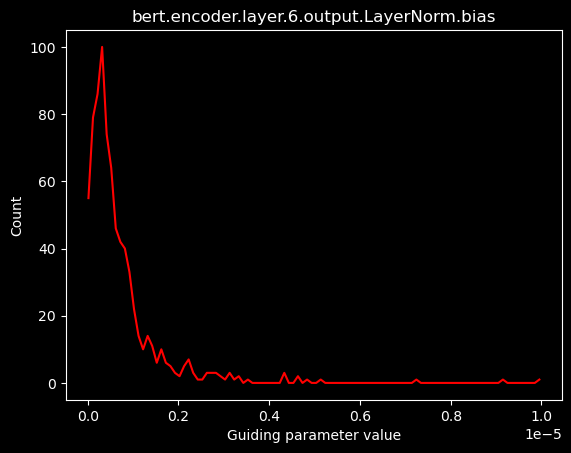

bert.encoder.layer.6.output.LayerNorm.bias


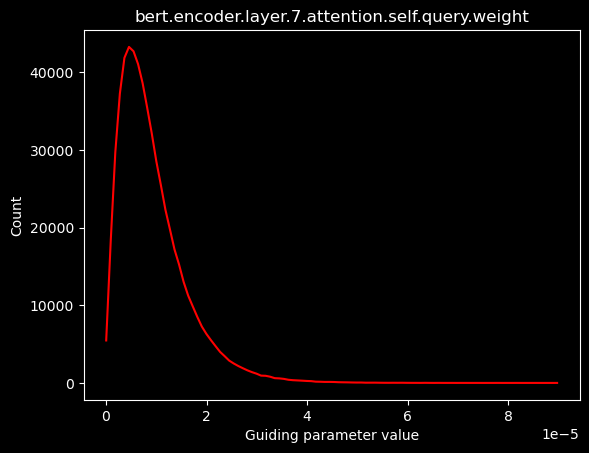

bert.encoder.layer.7.attention.self.query.weight


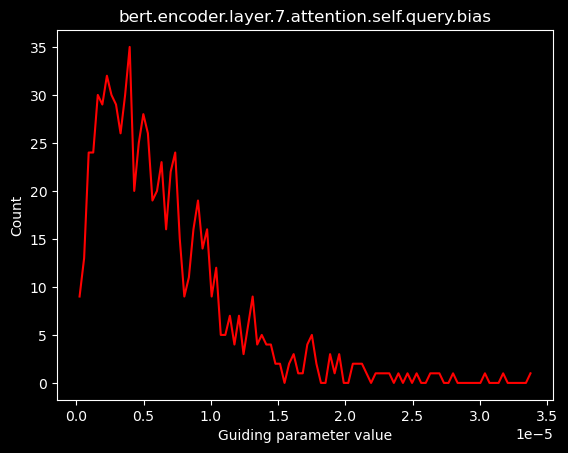

bert.encoder.layer.7.attention.self.query.bias


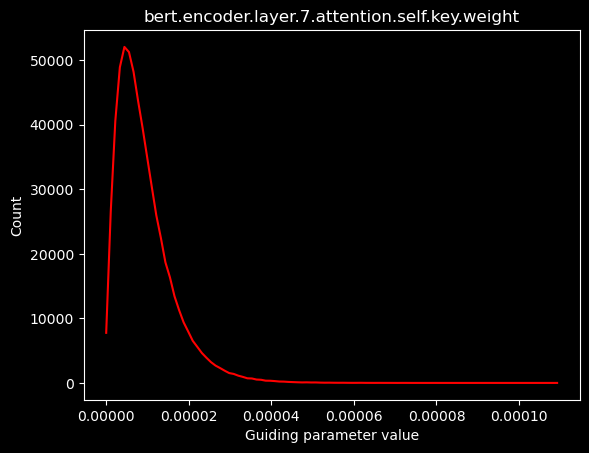

bert.encoder.layer.7.attention.self.key.weight


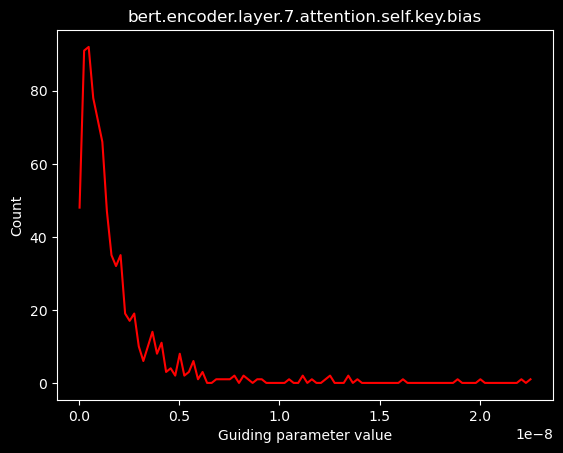

bert.encoder.layer.7.attention.self.key.bias


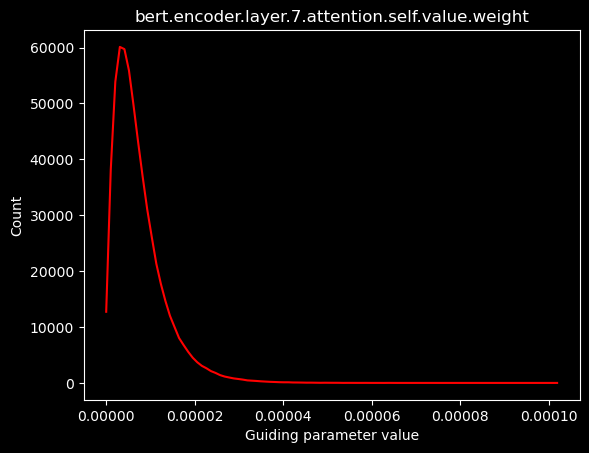

bert.encoder.layer.7.attention.self.value.weight


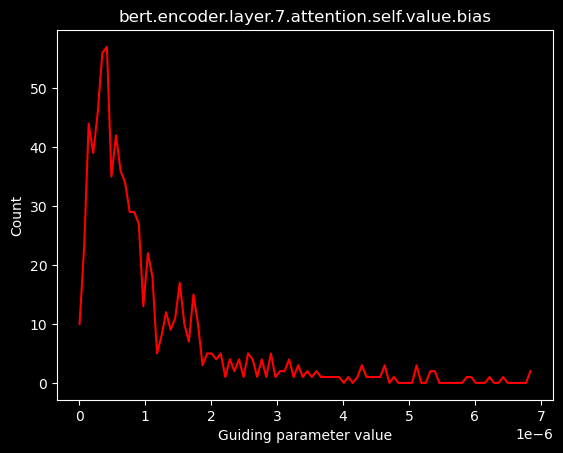

bert.encoder.layer.7.attention.self.value.bias


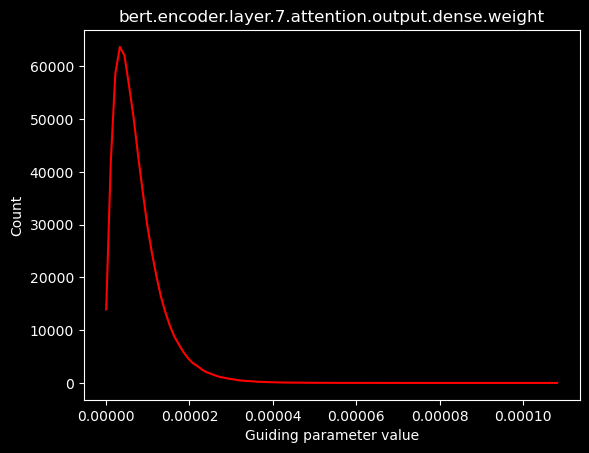

bert.encoder.layer.7.attention.output.dense.weight


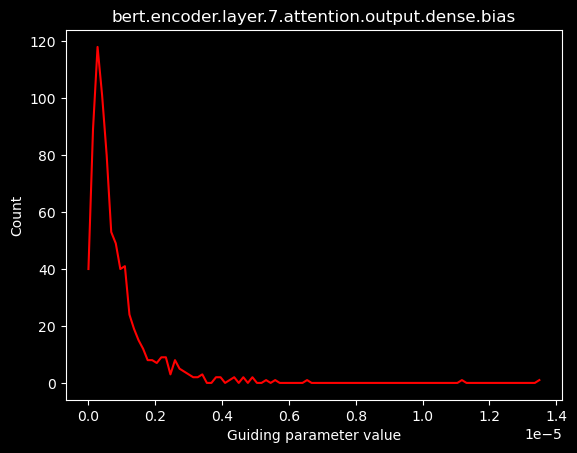

bert.encoder.layer.7.attention.output.dense.bias


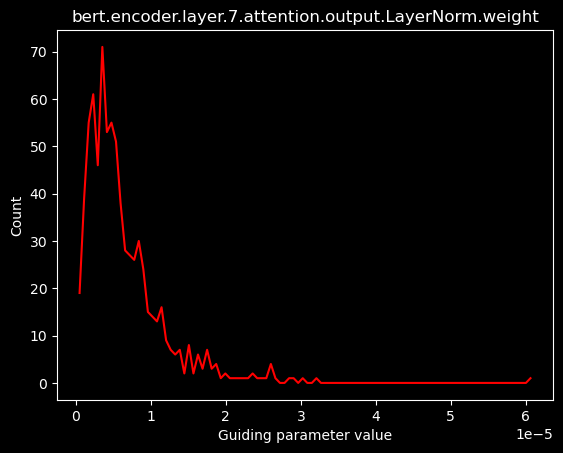

bert.encoder.layer.7.attention.output.LayerNorm.weight


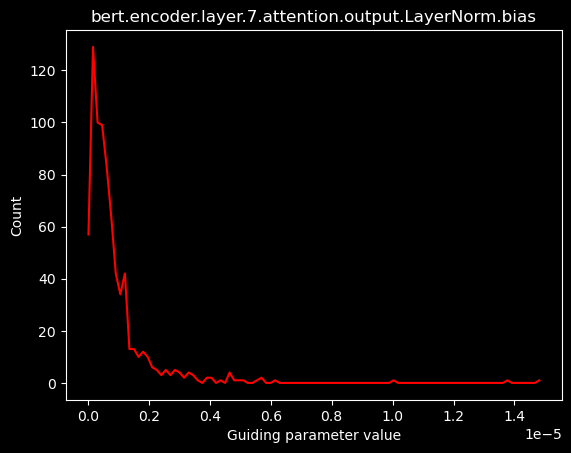

bert.encoder.layer.7.attention.output.LayerNorm.bias


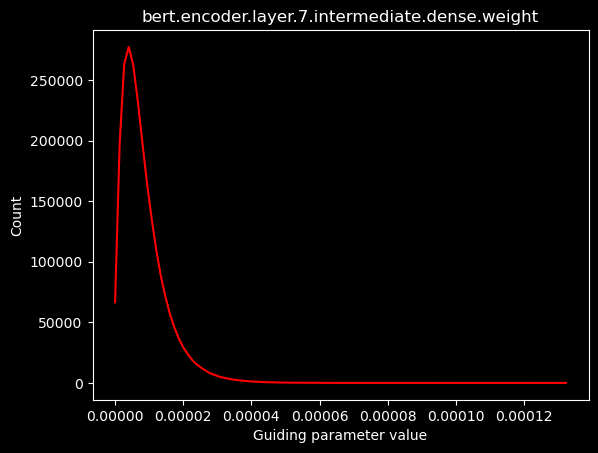

bert.encoder.layer.7.intermediate.dense.weight


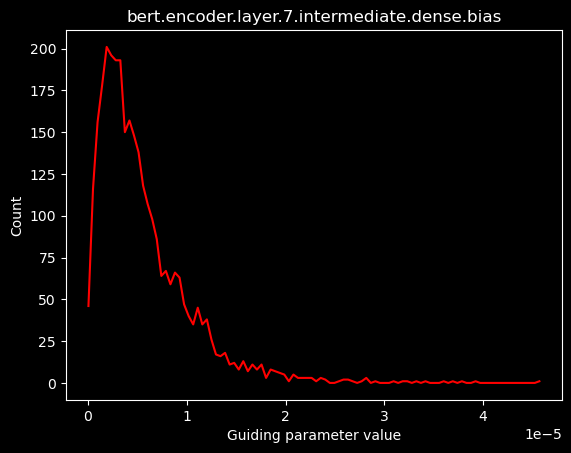

bert.encoder.layer.7.intermediate.dense.bias


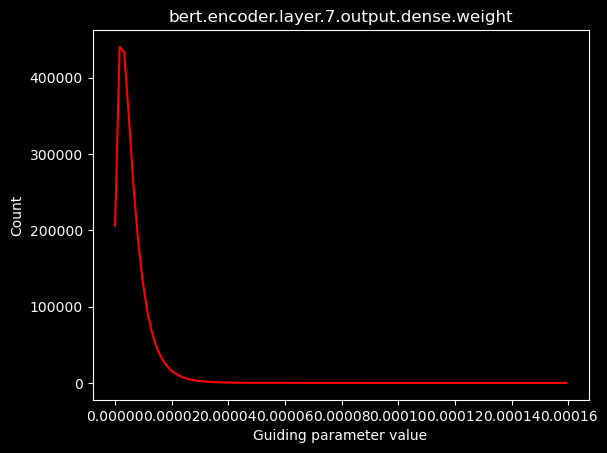

bert.encoder.layer.7.output.dense.weight


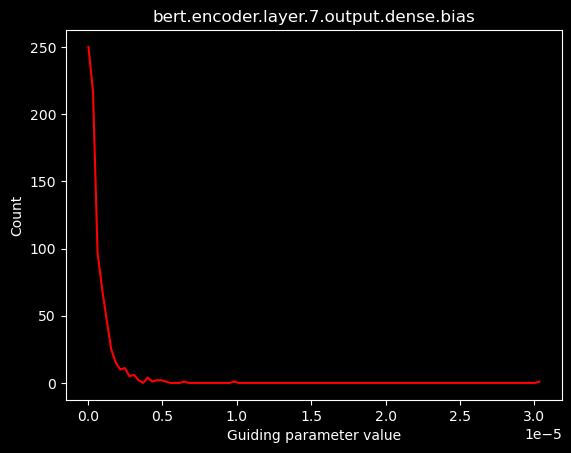

bert.encoder.layer.7.output.dense.bias


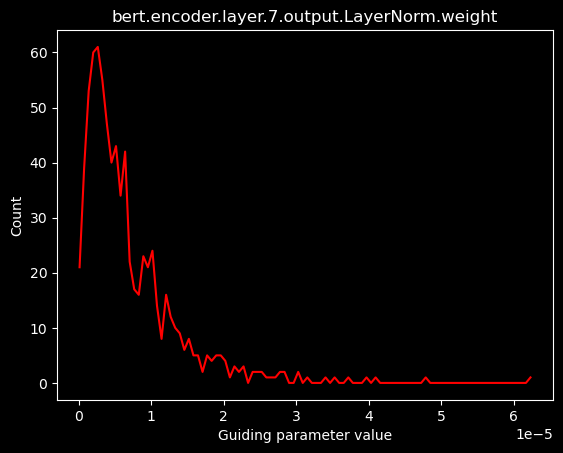

bert.encoder.layer.7.output.LayerNorm.weight


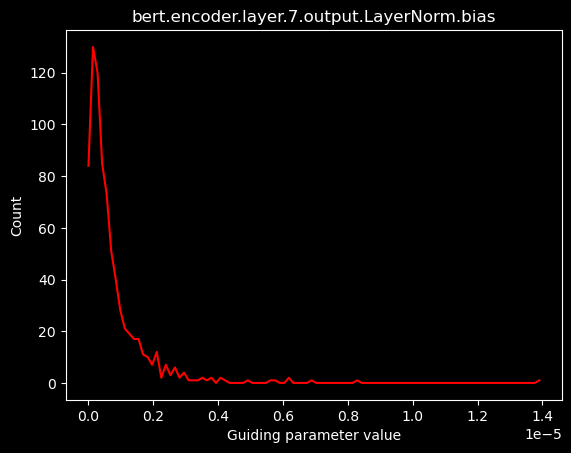

bert.encoder.layer.7.output.LayerNorm.bias


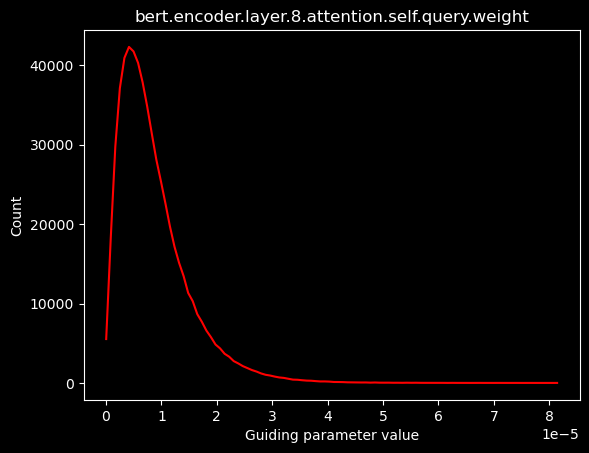

bert.encoder.layer.8.attention.self.query.weight


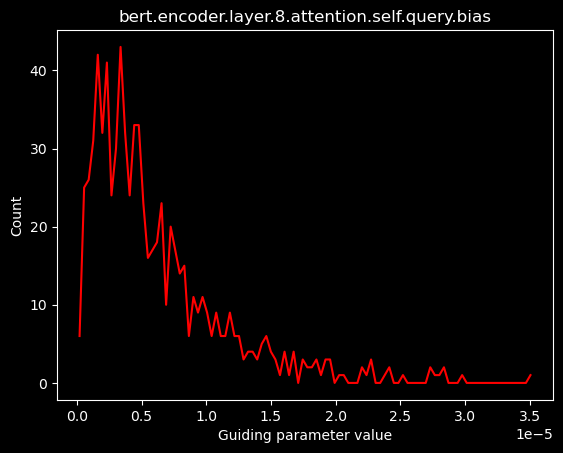

bert.encoder.layer.8.attention.self.query.bias


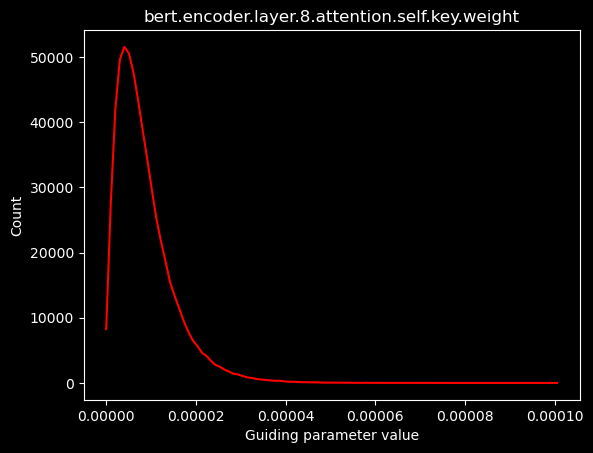

bert.encoder.layer.8.attention.self.key.weight


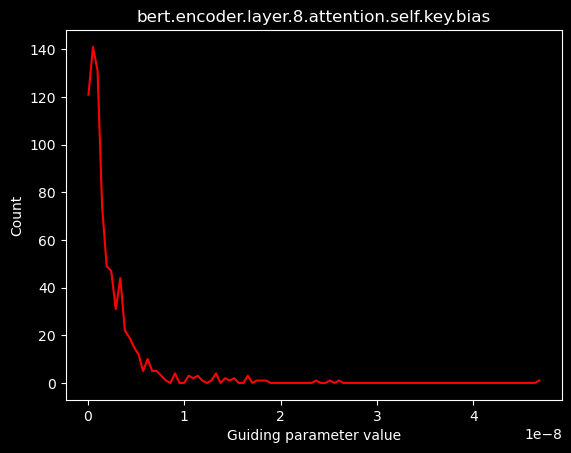

bert.encoder.layer.8.attention.self.key.bias


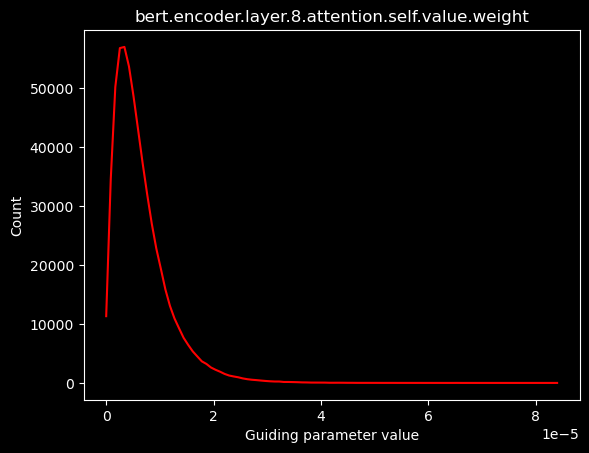

bert.encoder.layer.8.attention.self.value.weight


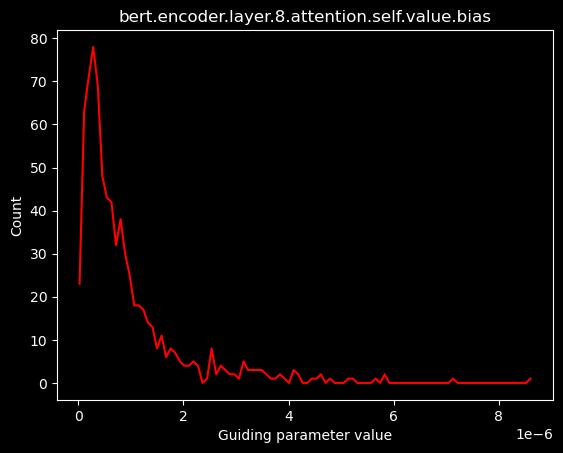

bert.encoder.layer.8.attention.self.value.bias


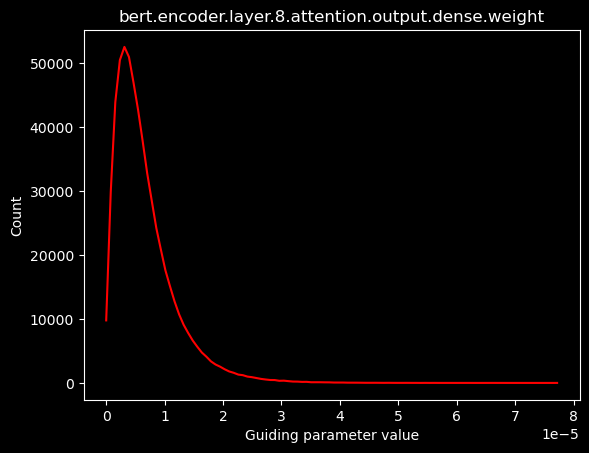

bert.encoder.layer.8.attention.output.dense.weight


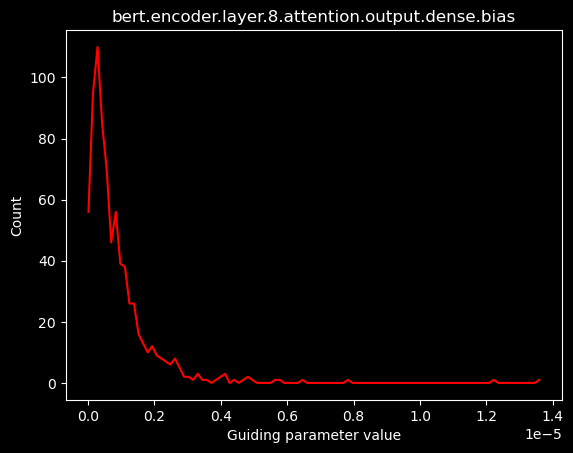

bert.encoder.layer.8.attention.output.dense.bias


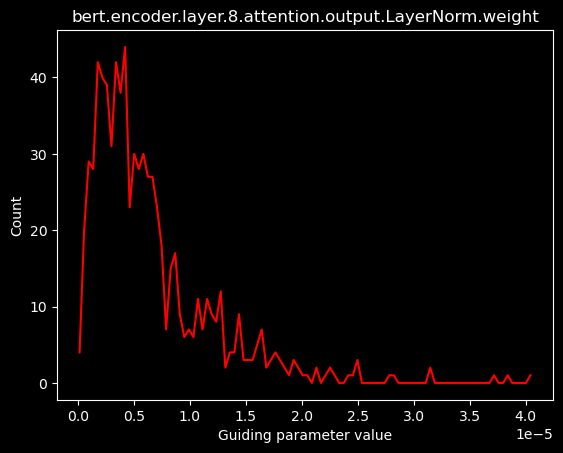

bert.encoder.layer.8.attention.output.LayerNorm.weight


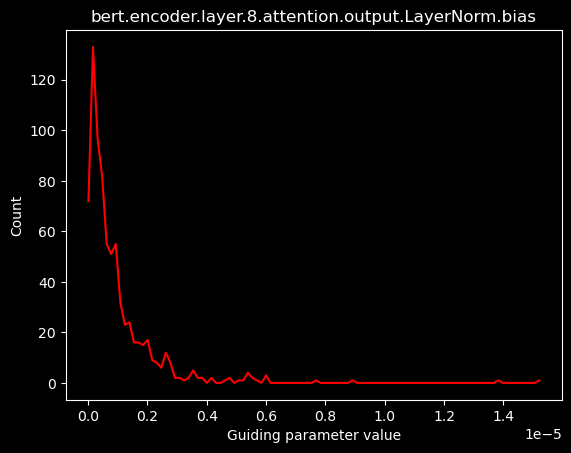

bert.encoder.layer.8.attention.output.LayerNorm.bias


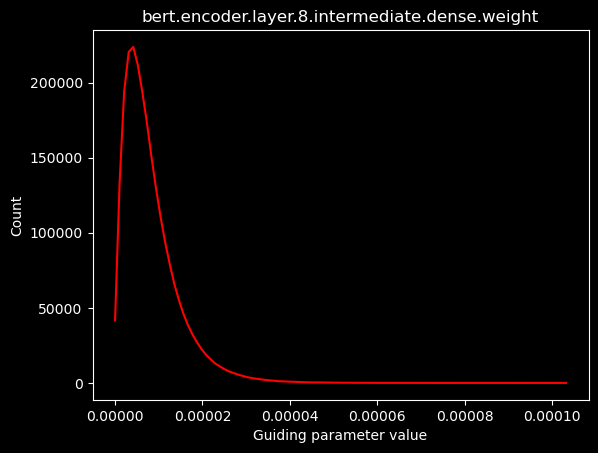

bert.encoder.layer.8.intermediate.dense.weight


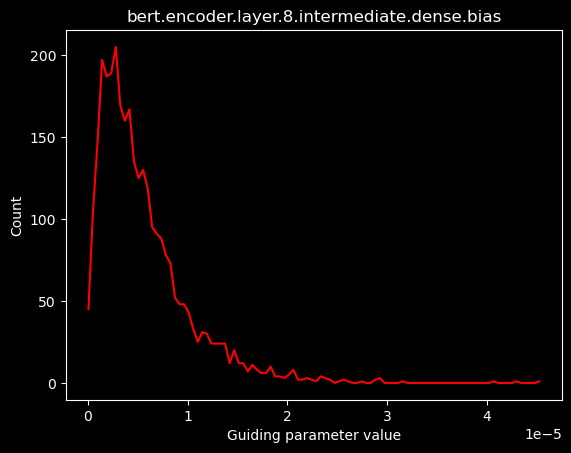

bert.encoder.layer.8.intermediate.dense.bias


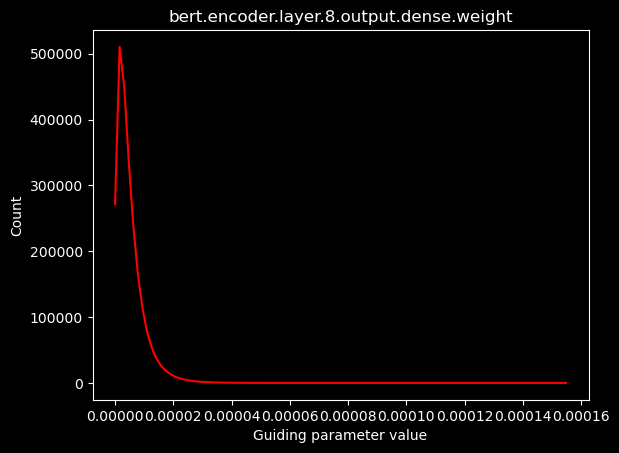

bert.encoder.layer.8.output.dense.weight


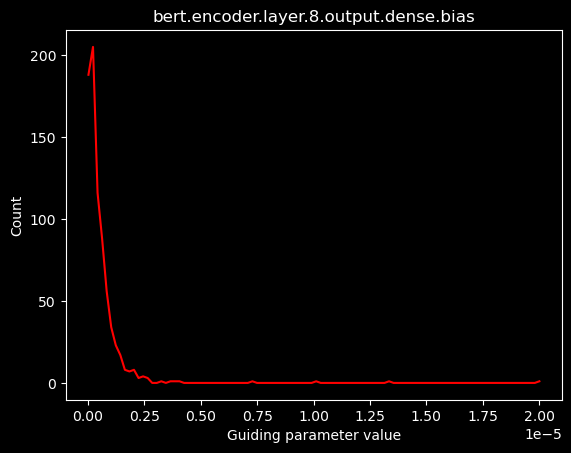

bert.encoder.layer.8.output.dense.bias


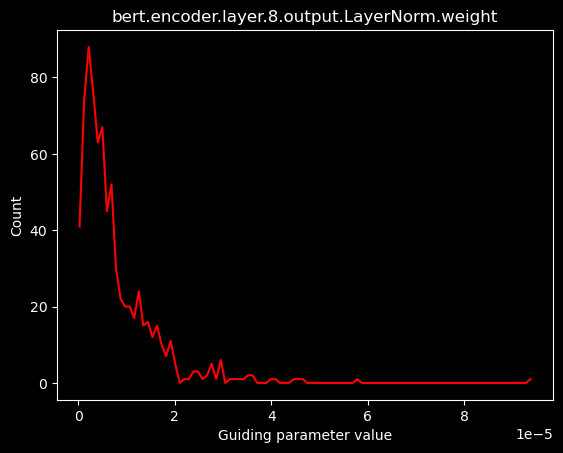

bert.encoder.layer.8.output.LayerNorm.weight


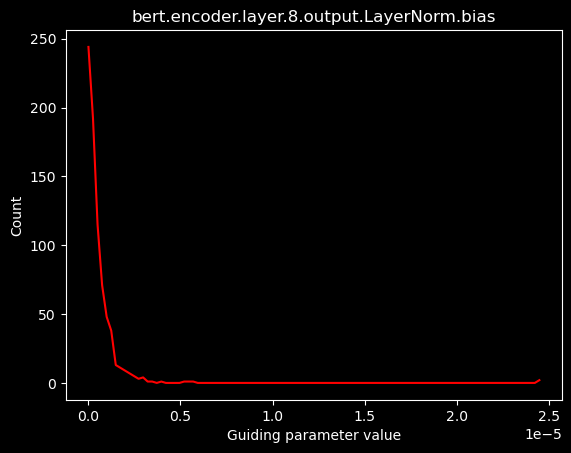

bert.encoder.layer.8.output.LayerNorm.bias


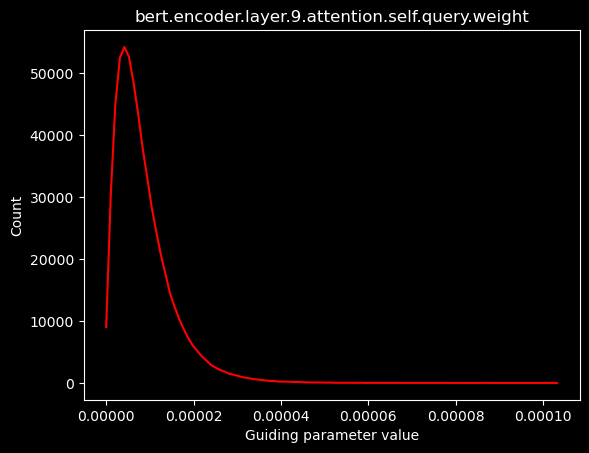

bert.encoder.layer.9.attention.self.query.weight


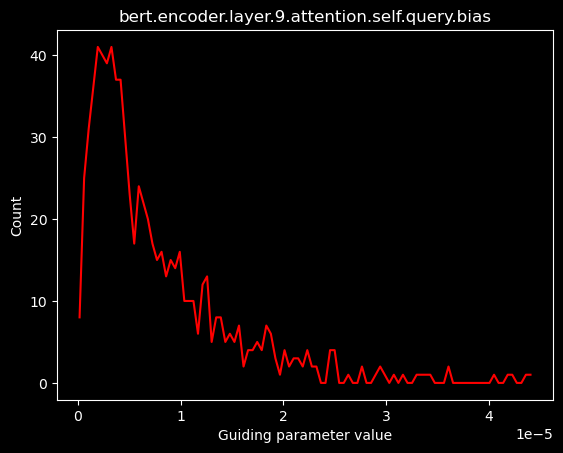

bert.encoder.layer.9.attention.self.query.bias


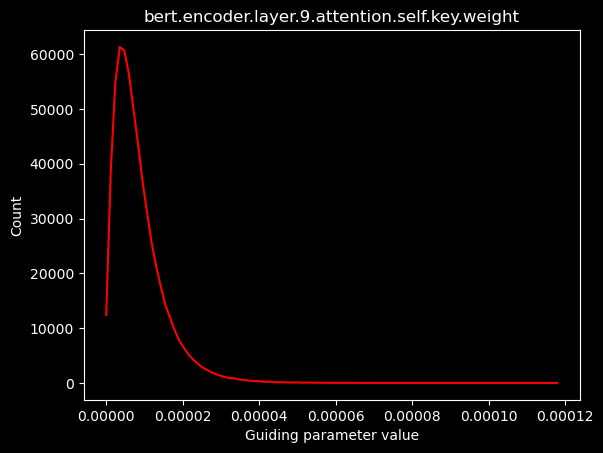

bert.encoder.layer.9.attention.self.key.weight


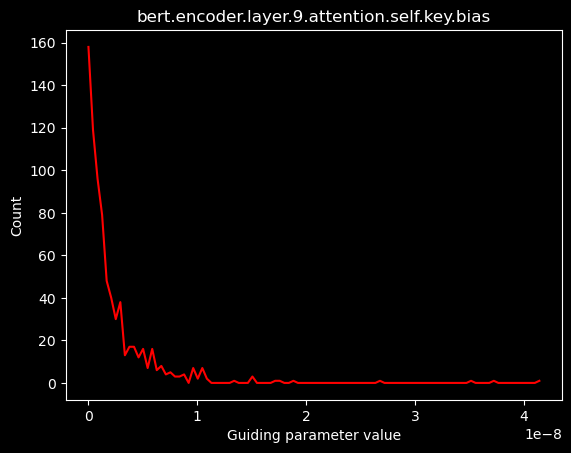

bert.encoder.layer.9.attention.self.key.bias


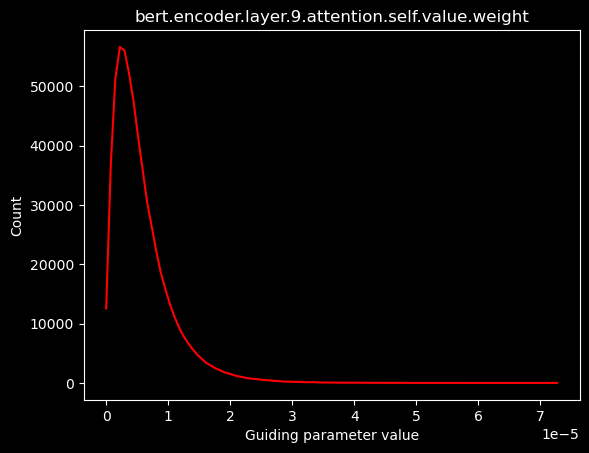

bert.encoder.layer.9.attention.self.value.weight


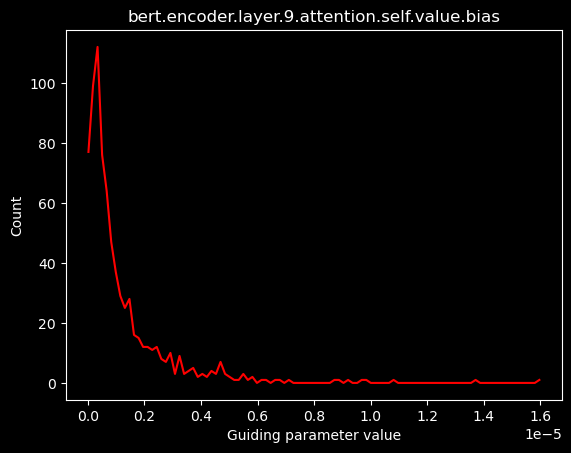

bert.encoder.layer.9.attention.self.value.bias


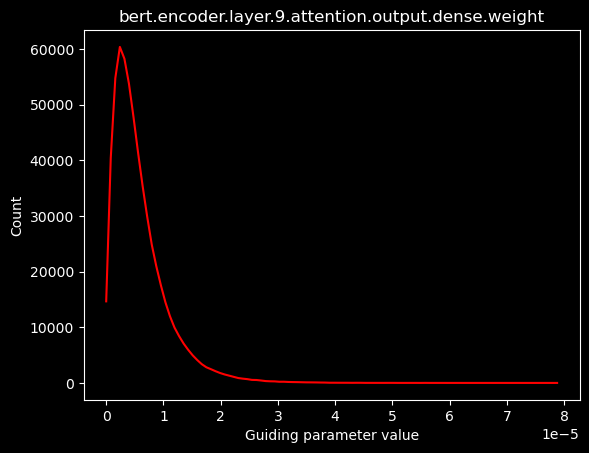

bert.encoder.layer.9.attention.output.dense.weight


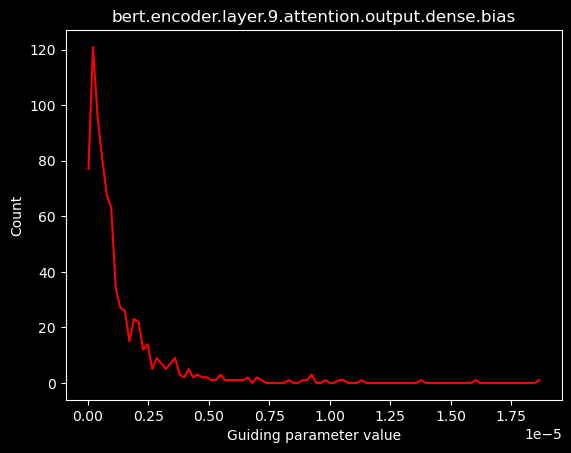

bert.encoder.layer.9.attention.output.dense.bias


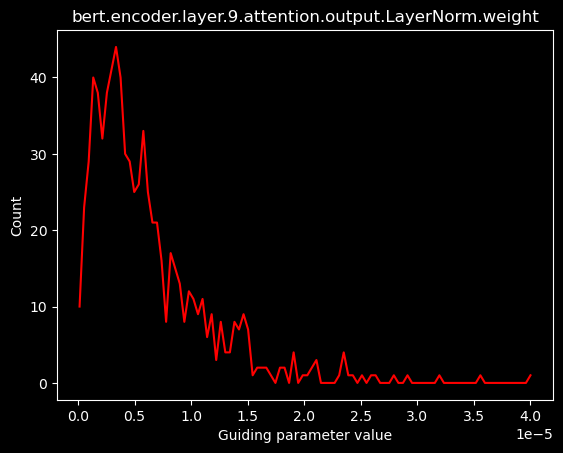

bert.encoder.layer.9.attention.output.LayerNorm.weight


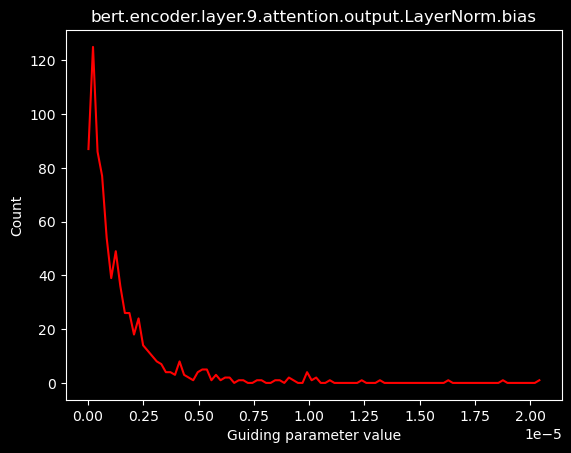

bert.encoder.layer.9.attention.output.LayerNorm.bias


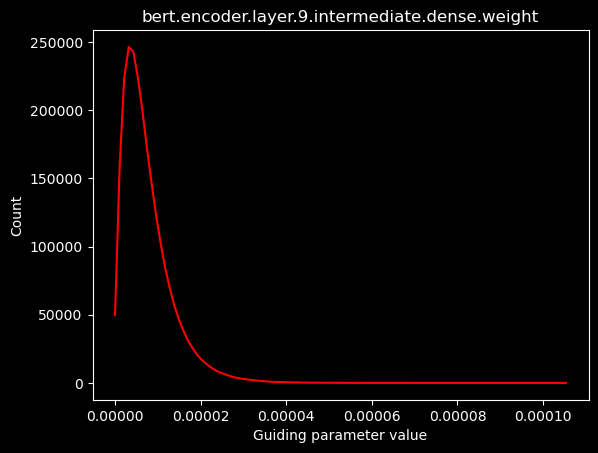

bert.encoder.layer.9.intermediate.dense.weight


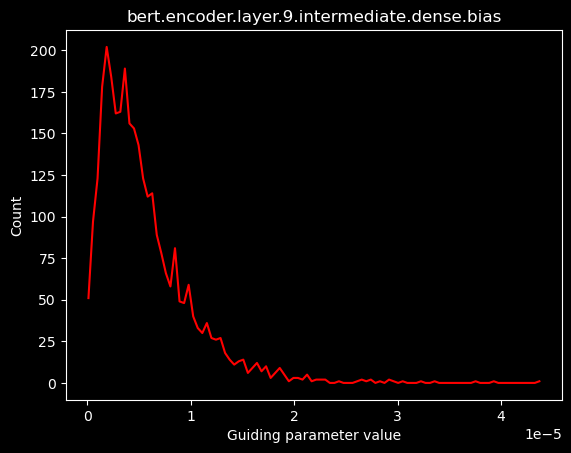

bert.encoder.layer.9.intermediate.dense.bias


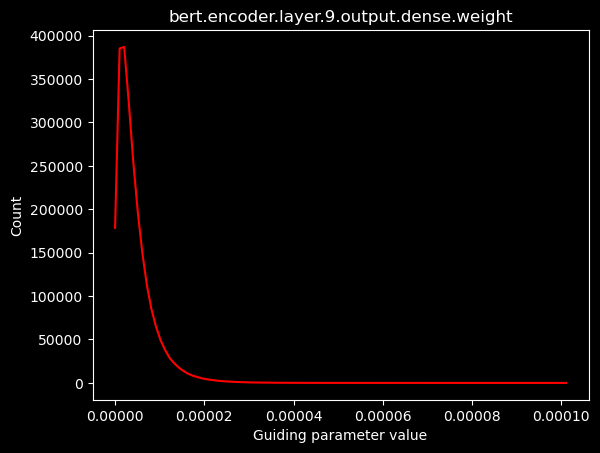

bert.encoder.layer.9.output.dense.weight


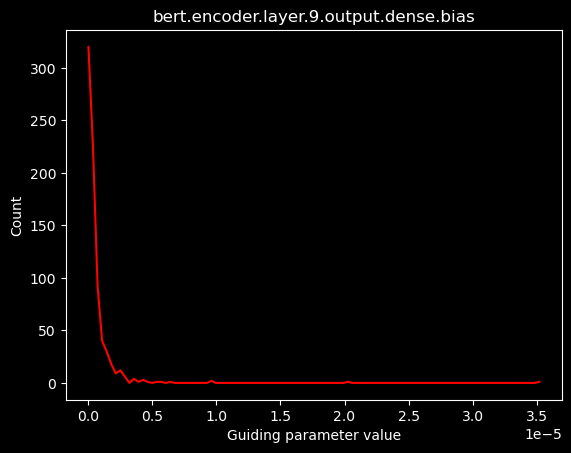

bert.encoder.layer.9.output.dense.bias


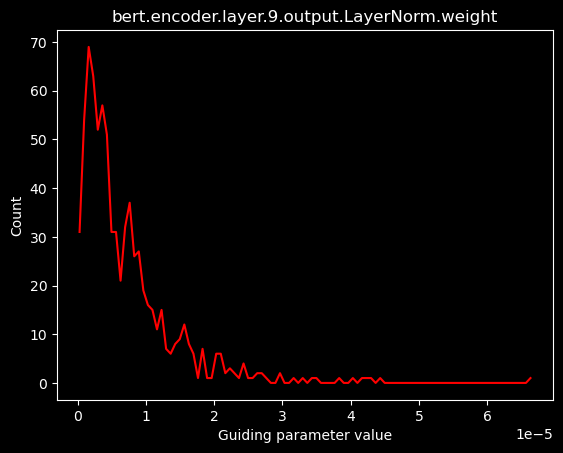

bert.encoder.layer.9.output.LayerNorm.weight


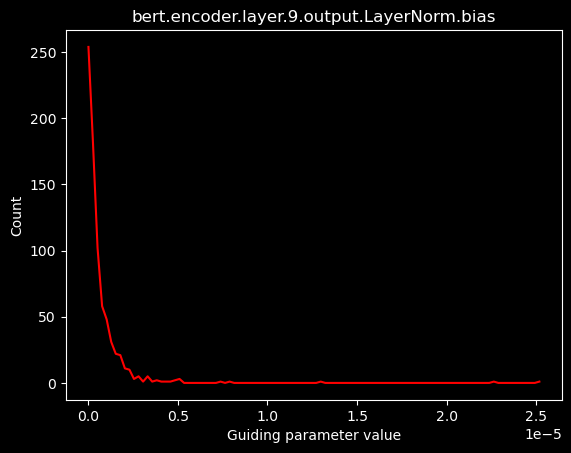

bert.encoder.layer.9.output.LayerNorm.bias


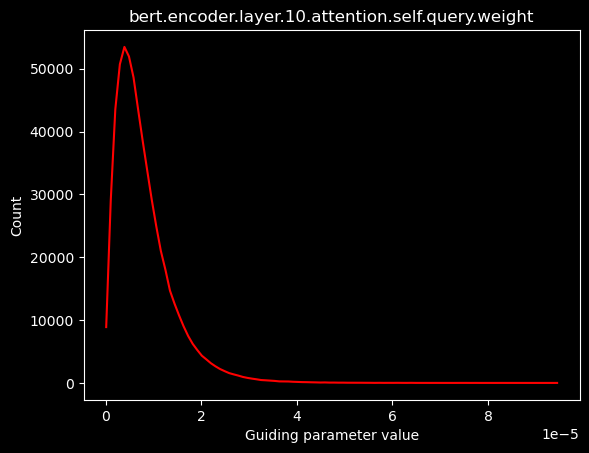

bert.encoder.layer.10.attention.self.query.weight


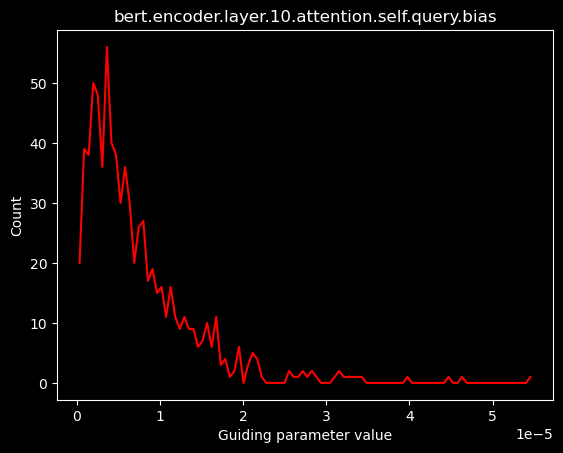

bert.encoder.layer.10.attention.self.query.bias


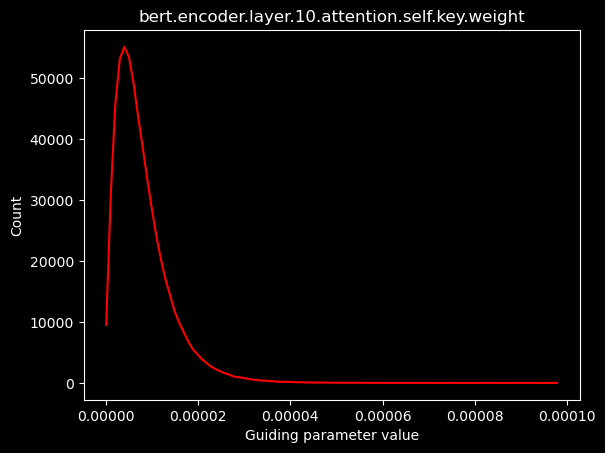

bert.encoder.layer.10.attention.self.key.weight


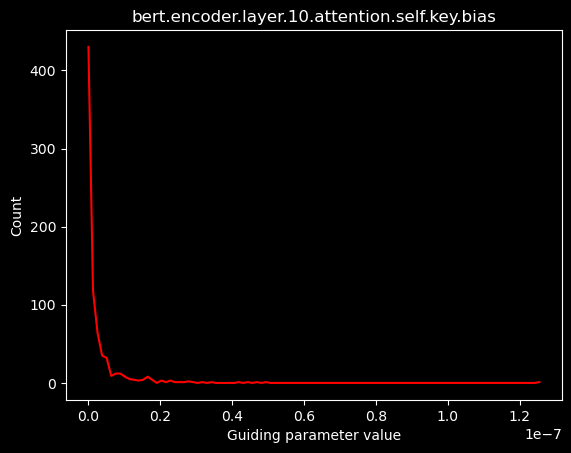

bert.encoder.layer.10.attention.self.key.bias


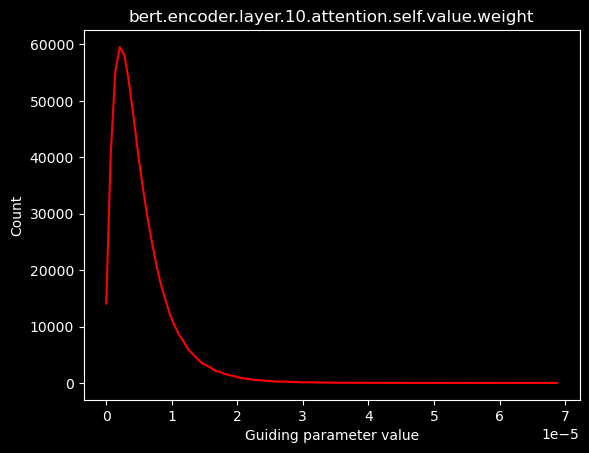

bert.encoder.layer.10.attention.self.value.weight


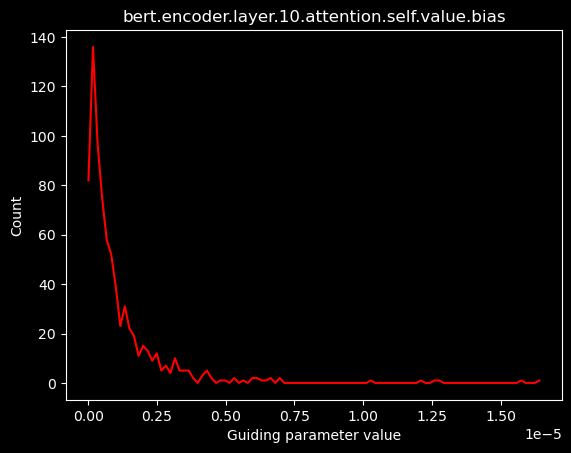

bert.encoder.layer.10.attention.self.value.bias


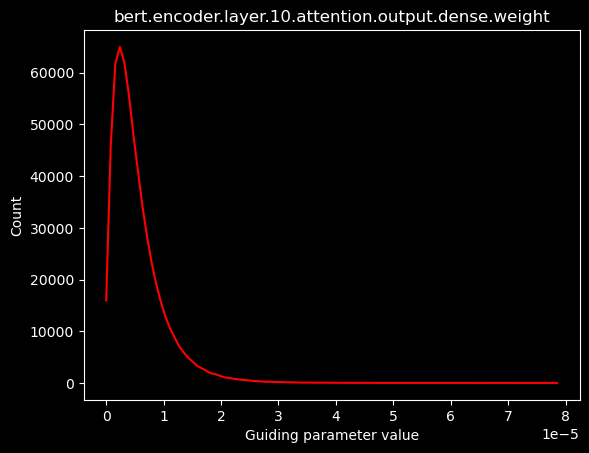

bert.encoder.layer.10.attention.output.dense.weight


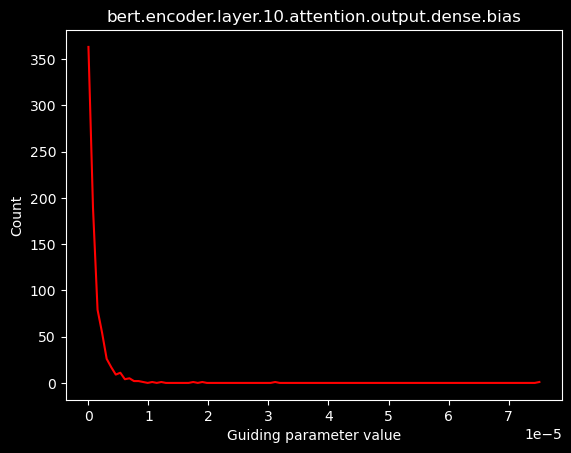

bert.encoder.layer.10.attention.output.dense.bias


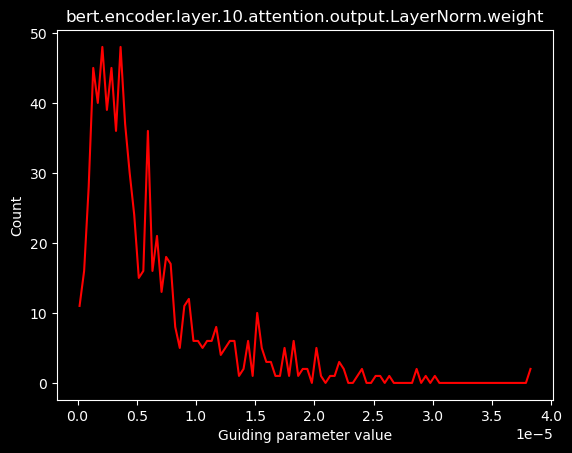

bert.encoder.layer.10.attention.output.LayerNorm.weight


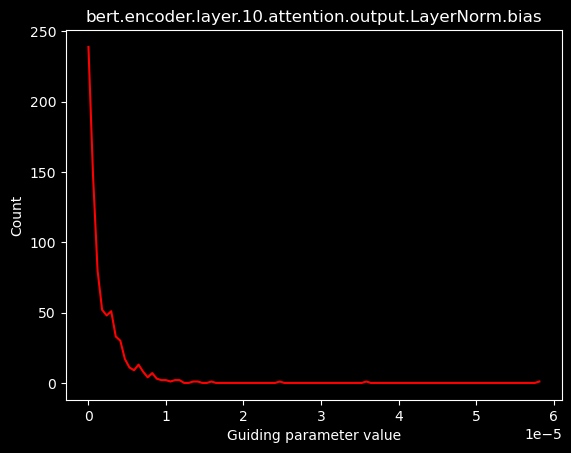

bert.encoder.layer.10.attention.output.LayerNorm.bias


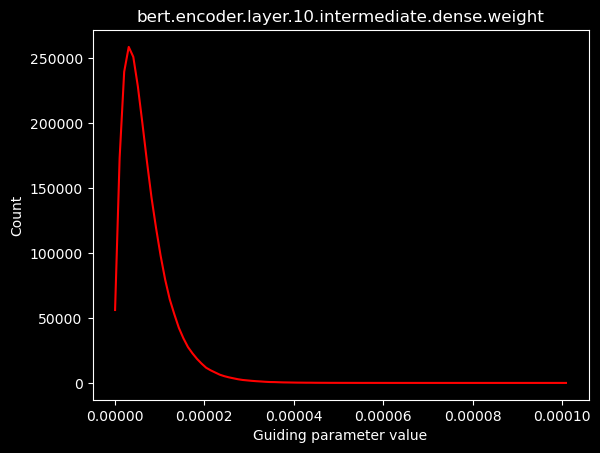

bert.encoder.layer.10.intermediate.dense.weight


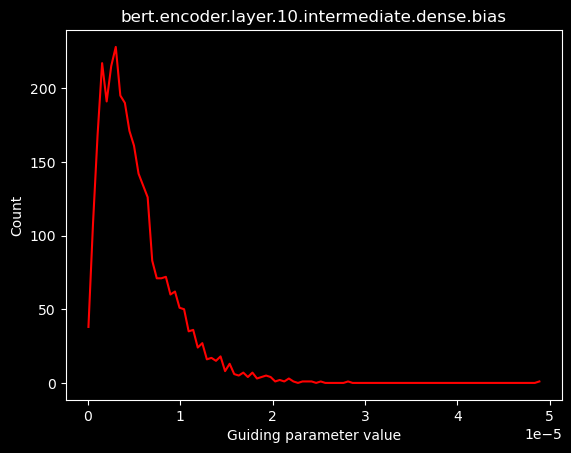

bert.encoder.layer.10.intermediate.dense.bias


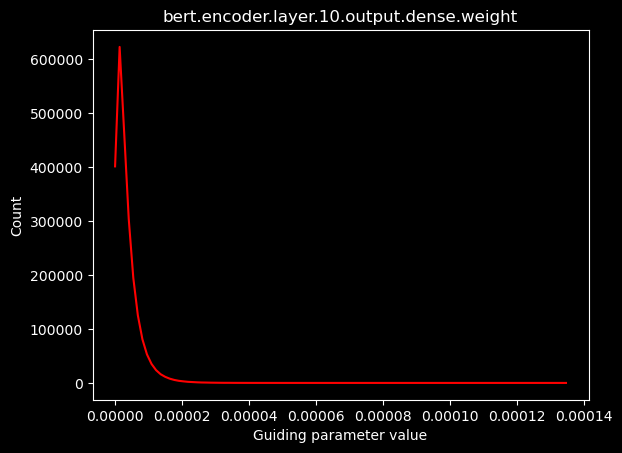

bert.encoder.layer.10.output.dense.weight


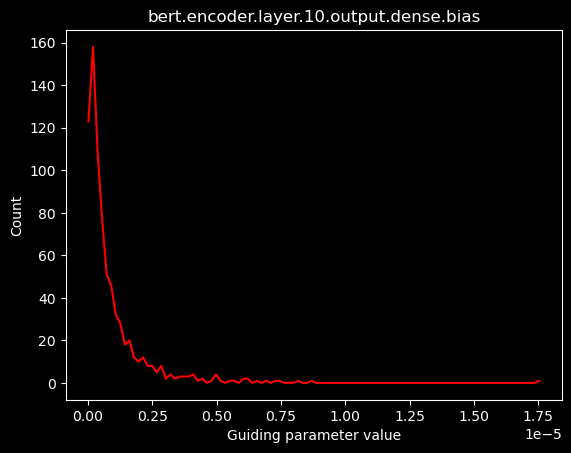

bert.encoder.layer.10.output.dense.bias


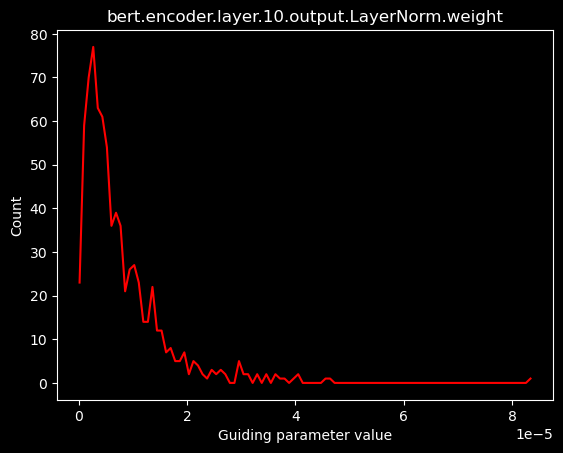

bert.encoder.layer.10.output.LayerNorm.weight


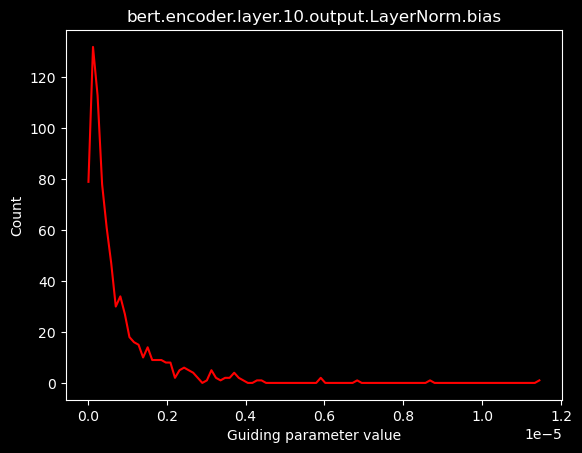

bert.encoder.layer.10.output.LayerNorm.bias


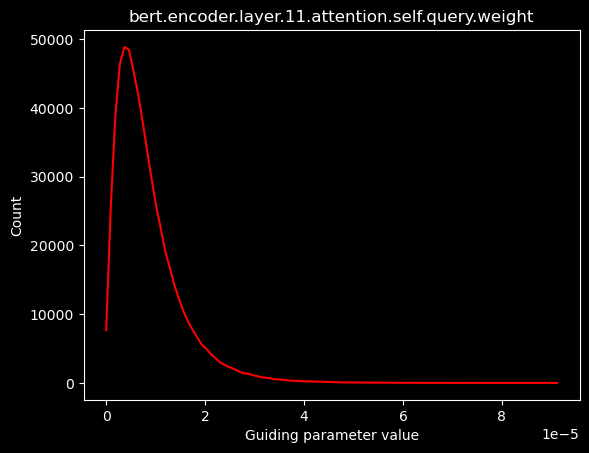

bert.encoder.layer.11.attention.self.query.weight


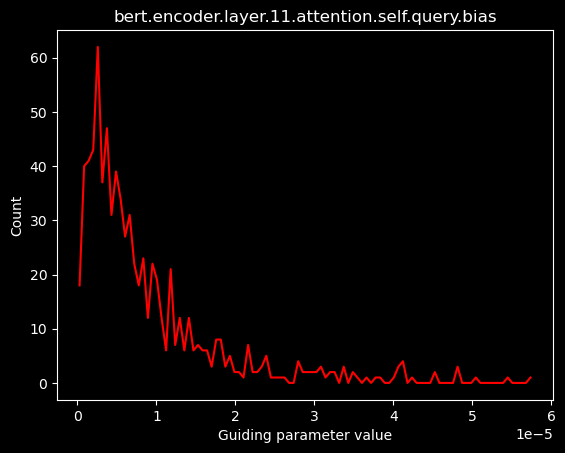

bert.encoder.layer.11.attention.self.query.bias


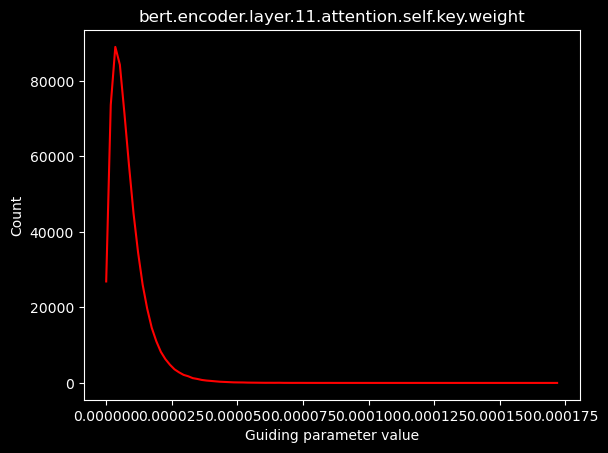

bert.encoder.layer.11.attention.self.key.weight


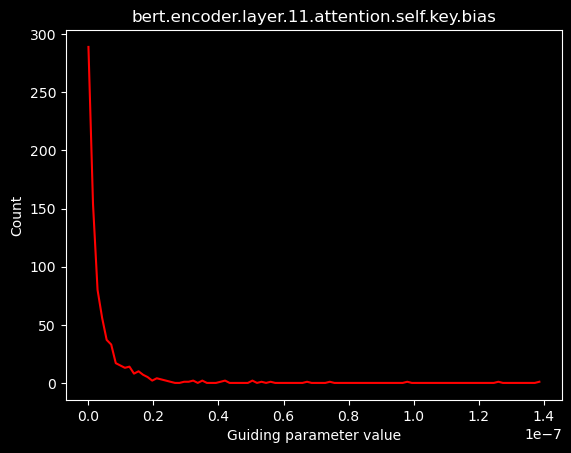

bert.encoder.layer.11.attention.self.key.bias


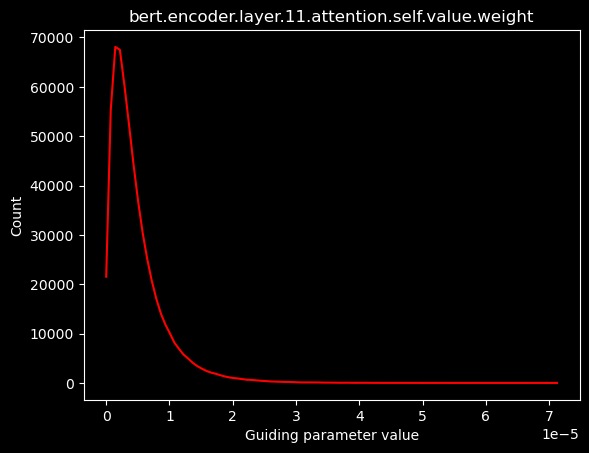

bert.encoder.layer.11.attention.self.value.weight


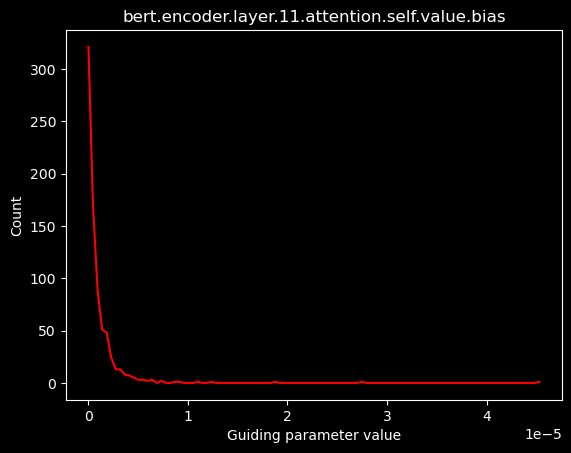

bert.encoder.layer.11.attention.self.value.bias


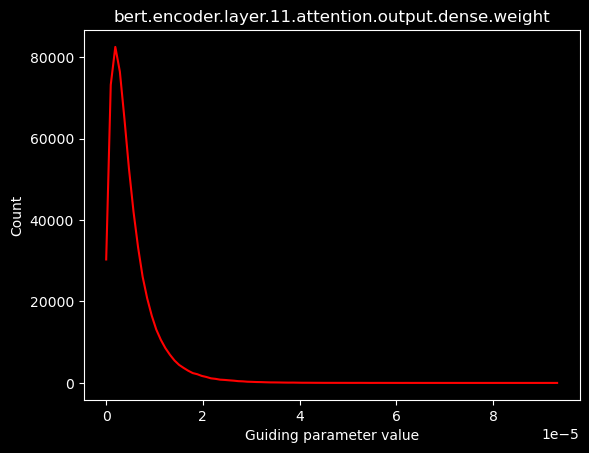

bert.encoder.layer.11.attention.output.dense.weight


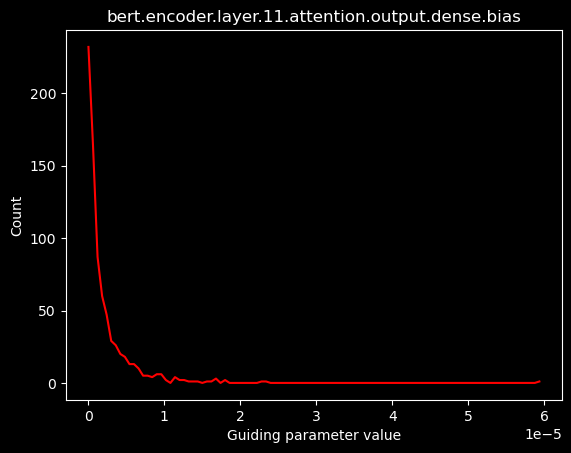

bert.encoder.layer.11.attention.output.dense.bias


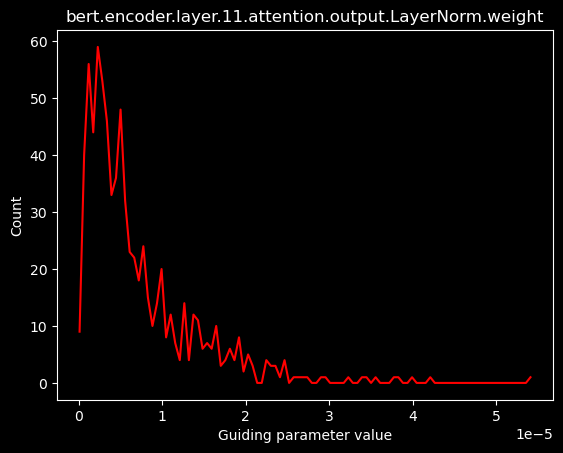

bert.encoder.layer.11.attention.output.LayerNorm.weight


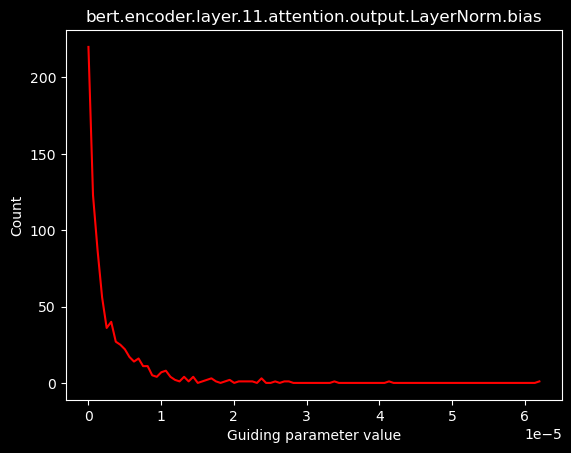

bert.encoder.layer.11.attention.output.LayerNorm.bias


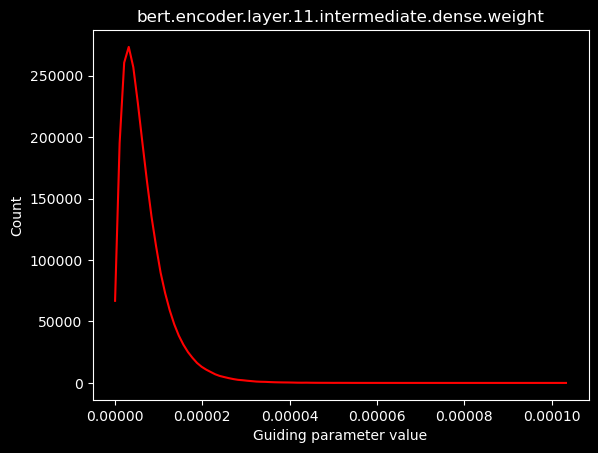

bert.encoder.layer.11.intermediate.dense.weight


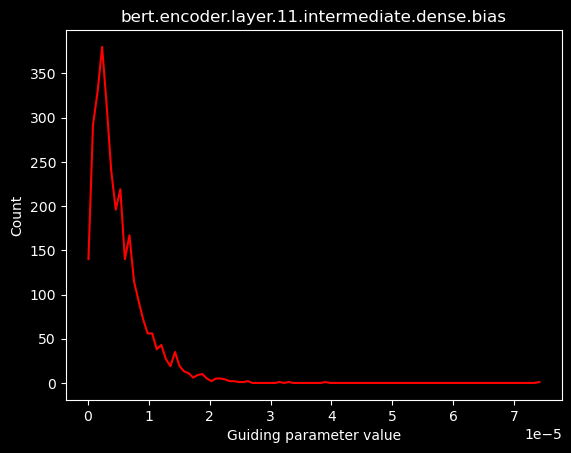

bert.encoder.layer.11.intermediate.dense.bias


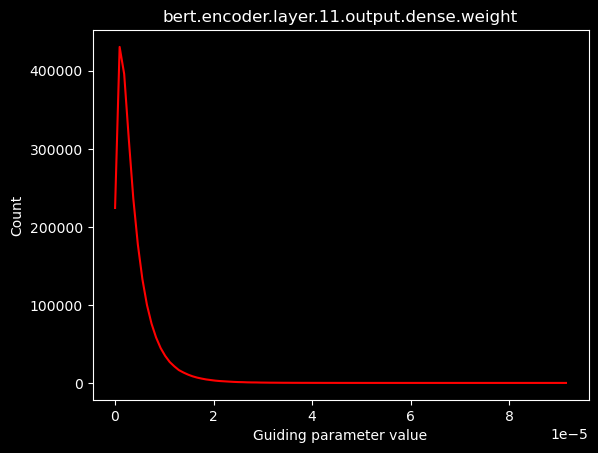

bert.encoder.layer.11.output.dense.weight


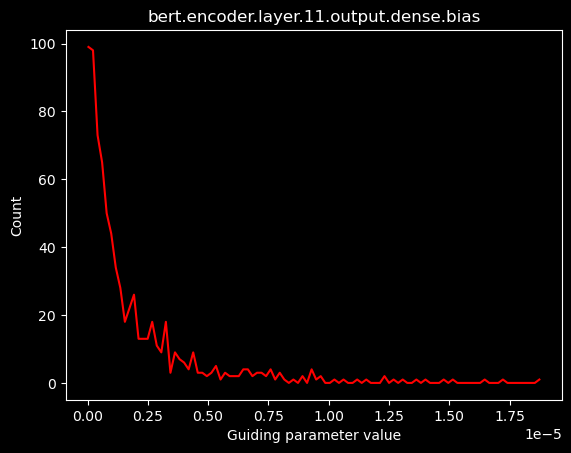

bert.encoder.layer.11.output.dense.bias


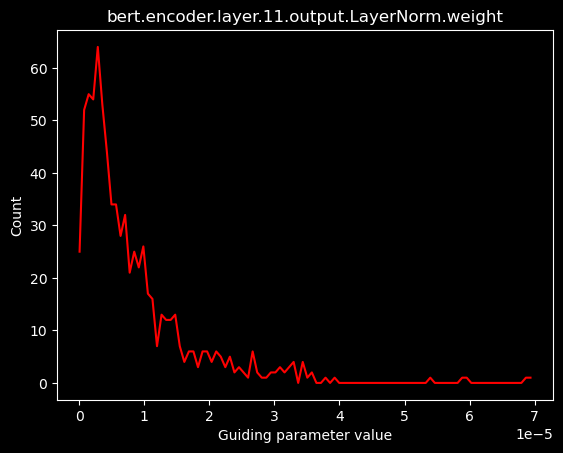

bert.encoder.layer.11.output.LayerNorm.weight


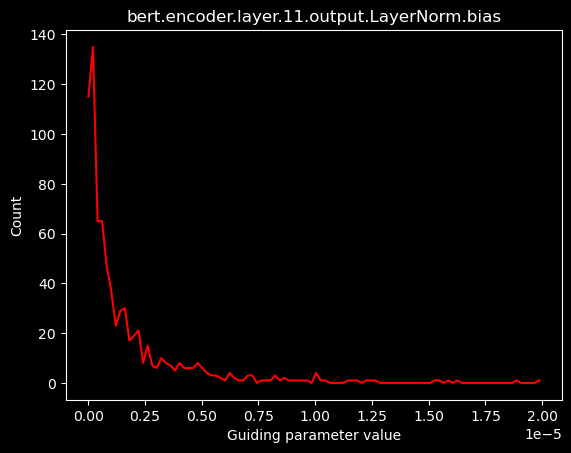

bert.encoder.layer.11.output.LayerNorm.bias
time: 24 s (started: 2024-07-08 19:07:05 +03:00)


In [30]:
for layer_num in range(12-nb_of_layers_to_unfreeze,12):
    for sub_layer in encoder_sub_layers_list:
        gtl.plot_guidance_distribution(raw_guidance_matrix, name=f'bert.encoder.layer.{layer_num}.{sub_layer}')
        print(f'bert.encoder.layer.{layer_num}.{sub_layer}')

# for layer_num in range(0,12):
#     for sub_layer in encoder_sub_layers_list:
#         gtl.plot_guidance_distribution(raw_guidance_matrix, name=f'bert.encoder.layer.{layer_num}.{sub_layer}')
#         # print(f'bert.encoder.layer.{layer_num}.{sub_layer}')


In [31]:
del raw_guidance_matrix

time: 0 ns (started: 2024-07-08 19:07:29 +03:00)


#### Testnig a text output from BERT-28 outputs

In [32]:
test_text = ['I Love BERT'] 
inputs = tokenizer.encode_plus(test_text, add_special_tokens=True, max_length=512,padding='longest',return_tensors='pt')

input_ids = inputs['input_ids'].to(DEVICE)
attention_mask = inputs['attention_mask'].to(DEVICE)
logits = ClassificationBERT_(input_ids, attention_mask=attention_mask)
probs =  torch.nn.functional.softmax(logits, dim=1)
probs

tensor([[0.0197, 0.0981, 0.0262, 0.0330, 0.0283, 0.0271, 0.0230, 0.0416, 0.0174,
         0.0157, 0.0234, 0.0518, 0.0411, 0.0509, 0.0360, 0.0500, 0.0286, 0.0291,
         0.0424, 0.0454, 0.0376, 0.0432, 0.0222, 0.0573, 0.0308, 0.0349, 0.0193,
         0.0260]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

time: 234 ms (started: 2024-07-08 19:08:01 +03:00)


#### New :

This is what needs to be done:

1) We start from a pre-trained model, M. We unfreeze all the parameters.

2) Next, we split the data set into two separate data sets, one with 18 classes (dataset A) and the other with the remaining 10 classes (dataset B).

3) We then create 10 scouts out of dataset A only. We make sure that each scout has only 10 classes randomly picked from the 18 classes of dataset A. Each scout is trained as transfer learning starting from model M.

4) Next, we create the guiding matrix using the parameters of M and of the ten scouts.

5) After that, we use dataset B only as our downstream task. In this task, we start again with model M.

6) (a) We train the model with the 10 classes of dataset B using the guidance matrix. For this training, we use only a single example -- one-shot learning. The rest of the data are used for testing.

6) (b) We do the same as in 6a but without using the guidance matrix.

7) We compare the results obtained in 6a and 6b.